# Data exploration of geoclim and GBS sequencing data from wild coffee tree samples

## About the data
### Source
Hamon P, Grover CE, Davis AP, Rakotomalala JJ, Raharimalala NE, Albert VA, Sreenath HL, Stoffelen P, Mitchell SE, Couturon E, Hamon S, de Kochko A, Crouzillat D, Rigoreau M, Sumirat U, Akaffou S, Guyot R. Genotyping-by-sequencing provides the first well-resolved phylogeny for coffee (Coffea) and insights into the evolution of caffeine content in its species: GBS coffee phylogeny and the evolution of caffeine content. Mol Phylogenet Evol. 2017 Apr;109:351-361. doi: 10.1016/j.ympev.2017.02.009. Epub 2017 Feb 16. PMID: 28212875.

### Metadata
Metadata table in [data directory](coffeaPhyloGeo/data/geoclim/geospatial/coff_madag_species_summary.xlsx)

**Genetic data :**
GBS/Rad-Seq from nuclear DNA. Data cleaning, ref-genome alignement + SNP concat #TODO

**geoclim data :**
GPS positions and other information on speciments available in metadata table. 

To extract, manipulate and visualize data from [Madaclim](https://madaclim.cirad.fr/) db, we use part of our own developped Python package `py_madaclim`

---

**All required imports and utils**

In [2]:
from pathlib import Path
from typing import Union, List, Tuple, Dict
import re
import pickle


import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import rasterio
from rasterio import plot, windows
from shapely import Point
from pyproj import Transformer

from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import VarianceThreshold

from py_madaclim.info import MadaclimLayers
from py_madaclim.raster_manipulation import MadaclimRasters, MadaclimPoint, MadaclimCollection

## Climate data extraction

### GPS position extraction from metadata, cleaning and data-formatting

In [3]:
coff_data_filename = "coff_madag_species_summary.xlsx"
data_dir = Path.cwd() / "data"

**Generate 2 csv files for 2 subsets using Pandas :**
- all specimens WITH GPS positions (df_gps_all)
- only specimens with BOTH GPS and SNP.fasta (df_gbs_only)

In [4]:
# Read from raw table

df = pd.read_excel(data_dir / coff_data_filename, decimal=",")
df = df.dropna(how="all").reset_index().drop(columns="index")
df

Species                        GBS sequence  \
0           C.abbayesii                    C_abbayesii_A601   
1      C.ambodirianenis              C_ambodirianensis_A572   
2         C.ambongensis                       C_ambongensis   
3        C.ankaranensis                 C_ankaranensis_A525   
4        C.ankaranensis                                   -   
5          C.arenesiana                   C_arenesiana_A403   
6          C.augagneuri                   C_augagneuri_A966   
7          C.bertrandii                     C_bertrandii_A5   
8       C.betamponensis                                   -   
9           C.bissetiae                         C_bissetiae   
10          C.boinensis                         C_boinensis   
11         C.boiviniana                   C_boiviniana_A980   
12           C.bonnieri                     C_bonnieri_A535   
13             C.costei                       C_costei_A956   
14          C.coursiana                                   -   
15         C.daphnoides                                   -   
16      C.dolichophylla                C_dolichophylla_A206   
17           C.dubardii                     C_dubardii_A969   
18   C.farafanganensis               C_farafanganensis_A208   
19             C.heimii                       C_heimii_A516   
20           C.homollei                     C_homollei_A945   
21        C.humblotiana               C_humblotiana_BM19_20   
22           C.jumellei                     C_jumellei_A974   
23     C.kianjavatensis               C_kianjavatensis_A602   
24     C.kianjavatensis                                   -   
25         C.lancifolia                   C_lancifolia_A320   
26             C.leroyi                                   -   
27             C.leroyi                       C_leroyi_A315   
28         C.macrocarpa                    C_macrocarpa-pet   
29       C.mangoroensis                                   -   
30       C.mangoroensis                                   -   
31            C.milotti                                   -   
32            C.milotti                     C_millotii_A222   
33          C.mogenetti                     C_mogeneti_A975   
34       C.montis-sacri                 C_montis-sacri_A321   
35           C.perrieri                      C_perrieri_A12   
36        C.pervilleana                  C_pervilleana_A957   
37      C.ratsimamangae                C_ratsimamangae_A528   
38           C.resinosa                       C_resinosa_A8   
39          C.richardii                    C_richardii_A575   
40      C.sahafaryensis                C_sahafaryensis_A978   
41          C.sakarahae                    C_sakarahae_A304   
42          C.tetragona                    C_tetragona_A252   
43         C.tsirananae                   C_tsirananae_A515   
44      C.vatovavyensis                C_vatovavyensis_A830   
45           C.vianneyi                                   -   
46           C.vianneyi                     C_vianneyi_A946   
47       C.vohemarensis  C_mcphersonii_A977 (=vohemarensis)   
48   C_andrambovatensis   C_andrambovatensis_A310 (=Leroyi)   
49          C_humbertii                  C_humbertii_RNF785   
50            C_labatii                   C_labatii_APD3096   
51            C_liaudii                     C_liaudii_A1013   
52       C_kihansiensis              C_kihansiensis_APD2922   
53  Tricalysia congesta         Tricalysia congesta_1442_78   
54         C.mauritiana                C_mauritiana_BM17_25   
55         C.myrtifolia                 C_myrtifolia_MBR_A9   

            Botanical series Genome size (2C. pg)   Latitude      Longitude  \
0                   Millotii                 1.25 -24.754100        46.8624   
1                   Millotii                 1.27 -18.452200        48.9433   
2                 Baracoffea                 1.16 -15.574583     46.4198056   
3             Multiflorae \n                 1.17 -12.949100        49.5433   
4             Multiflorae \n 

**Note for later** Use madaclim to impute missing gps POS on non-outgroup samples: C_liaudii (A1013)

#### Data formatting cleanup:
- Cleanup white space 
- special chars 
- convert to NaN format
- Remove outgroups

In [5]:
df

Species                        GBS sequence  \
0           C.abbayesii                    C_abbayesii_A601   
1      C.ambodirianenis              C_ambodirianensis_A572   
2         C.ambongensis                       C_ambongensis   
3        C.ankaranensis                 C_ankaranensis_A525   
4        C.ankaranensis                                   -   
5          C.arenesiana                   C_arenesiana_A403   
6          C.augagneuri                   C_augagneuri_A966   
7          C.bertrandii                     C_bertrandii_A5   
8       C.betamponensis                                   -   
9           C.bissetiae                         C_bissetiae   
10          C.boinensis                         C_boinensis   
11         C.boiviniana                   C_boiviniana_A980   
12           C.bonnieri                     C_bonnieri_A535   
13             C.costei                       C_costei_A956   
14          C.coursiana                                   -   
15         C.daphnoides                                   -   
16      C.dolichophylla                C_dolichophylla_A206   
17           C.dubardii                     C_dubardii_A969   
18   C.farafanganensis               C_farafanganensis_A208   
19             C.heimii                       C_heimii_A516   
20           C.homollei                     C_homollei_A945   
21        C.humblotiana               C_humblotiana_BM19_20   
22           C.jumellei                     C_jumellei_A974   
23     C.kianjavatensis               C_kianjavatensis_A602   
24     C.kianjavatensis                                   -   
25         C.lancifolia                   C_lancifolia_A320   
26             C.leroyi                                   -   
27             C.leroyi                       C_leroyi_A315   
28         C.macrocarpa                    C_macrocarpa-pet   
29       C.mangoroensis                                   -   
30       C.mangoroensis                                   -   
31            C.milotti                                   -   
32            C.milotti                     C_millotii_A222   
33          C.mogenetti                     C_mogeneti_A975   
34       C.montis-sacri                 C_montis-sacri_A321   
35           C.perrieri                      C_perrieri_A12   
36        C.pervilleana                  C_pervilleana_A957   
37      C.ratsimamangae                C_ratsimamangae_A528   
38           C.resinosa                       C_resinosa_A8   
39          C.richardii                    C_richardii_A575   
40      C.sahafaryensis                C_sahafaryensis_A978   
41          C.sakarahae                    C_sakarahae_A304   
42          C.tetragona                    C_tetragona_A252   
43         C.tsirananae                   C_tsirananae_A515   
44      C.vatovavyensis                C_vatovavyensis_A830   
45           C.vianneyi                                   -   
46           C.vianneyi                     C_vianneyi_A946   
47       C.vohemarensis  C_mcphersonii_A977 (=vohemarensis)   
48   C_andrambovatensis   C_andrambovatensis_A310 (=Leroyi)   
49          C_humbertii                  C_humbertii_RNF785   
50            C_labatii                   C_labatii_APD3096   
51            C_liaudii                     C_liaudii_A1013   
52       C_kihansiensis              C_kihansiensis_APD2922   
53  Tricalysia congesta         Tricalysia congesta_1442_78   
54         C.mauritiana                C_mauritiana_BM17_25   
55         C.myrtifolia                 C_myrtifolia_MBR_A9   

            Botanical series Genome size (2C. pg)   Latitude      Longitude  \
0                   Millotii                 1.25 -24.754100        46.8624   
1                   Millotii                 1.27 -18.452200        48.9433   
2                 Baracoffea                 1.16 -15.574583     46.4198056   
3             Multiflorae \n                 1.17 -12.949100        49.5433   
4             Multiflorae \n 

In [6]:
# Remove blank lines and strs
df["GBS sequence"] = df["GBS sequence"].str.rstrip()    #* \n still present after stripping

# Remove \n in Botanical series
df = df.replace(r"\n","", regex=True)

# Converting to proper NaN and reordering
df = df.replace({"-": np.nan, "NO POSITION": np.nan})
df = df.reindex(columns=["Species", "Species code", "Population code", "GBS sequence", "Botanical series", "Genome size (2C. pg)", "Latitude", "Longitude"])
# Remove NO from AND2 species
df["Longitude"] = df["Longitude"].str.replace("NO ", "")
df["Longitude"] = df["Longitude"].str.replace(",", ".")

# Removing outgroups and resetting index post cleaning
df = df.loc[df["Botanical series"] != "OUTGROUP"]
df = df.reset_index().drop(columns="index")

# Fix float types on continuous data
df["Genome size (2C. pg)"] = df["Genome size (2C. pg)"].astype(float)
df["Latitude"] = df["Latitude"].astype(float)
df["Longitude"] = df["Longitude"].astype(float)

df


Species Species code Population code  \
0          C.abbayesii          ABA            A601   
1     C.ambodirianenis          AMB            A572   
2        C.ambongensis        AMBON           BR071   
3       C.ankaranensis         ANK1            A525   
4       C.ankaranensis         ANK2            A808   
5         C.arenesiana          ARE            A403   
6         C.augagneuri         AUGA            A966   
7         C.bertrandii         BERT              A5   
8      C.betamponensis          BET            A573   
9          C.bissetiae         BISS           BR031   
10         C.boinensis         BOIN           BR051   
11        C.boiviniana          BOI            A980   
12          C.bonnieri          BON            A535   
13            C.costei          COS            A956   
14         C.coursiana          COU            A570   
15        C.daphnoides          DAP            A317   
16     C.dolichophylla          DOL            A206   
17          C.dubardii          DUB            A969   
18  C.farafanganensis           FAR            A208   
19            C.heimii          HEI            A516   
20          C.homollei          HOM            A945   
21       C.humblotiana         HUMB            A230   
22          C.jumellei          JUM            A974   
23    C.kianjavatensis         KIA2            A602   
24    C.kianjavatensis         KIA1            A213   
25        C.lancifolia          LAN            A320   
26            C.leroyi         AND1            A227   
27            C.leroyi          LER            A315   
28        C.macrocarpa          MAC             MAC   
29      C.mangoroensis         MAN1            A401   
30      C.mangoroensis         MAN2            A402   
31           C.milotti         MIL1            A721   
32           C.milotti         MIL2            A222   
33         C.mogenetti          MOG            A975   
34      C.montis-sacri          MON            A321   
35          C.perrieri         PER1             A12   
36       C.pervilleana         PERV            A957   
37     C.ratsimamangae          RAT            A528   
38          C.resinosa         RES1             A71   
39         C.richardii          RIC            A575   
40     C.sahafaryensis         SAHA            A978   
41         C.sakarahae          SAK            A304   
42         C.tetragona          TET            A252   
43        C.tsirananae          TSI            A515   
44     C.vatovavyensis          VAT            A830   
45          C.vianneyi         VIA1             A20   
46          C.vianneyi         VIA2            A946   
47      C.vohemarensis         VOHE            A977   
48  C_andrambovatensis         AND2            A310   
49         C_humbertii        HBERT          RNF785   
50           C_labatii        LABAT         APD3096   
51           C_liaudii        LIAUD           A1013   

                          GBS sequence          Botanical series  \
0                     C_abbayesii_A601                  Millotii   
1               C_ambodirianensis_A572                  Millotii   
2                        C_ambongensis                Baracoffea   
3                  C_ankaranensis_A525              Multiflorae    
4                                  NaN              Multiflorae    
5                    C_arenesiana_A403              Multiflorae    
6                    C_augagneuri_A966            Subterminales    
7                      C_bertrandii_A5              Multiflorae    
8                                  NaN              Multiflorae    
9                          C_bissetiae                Baracoffea   
10                         C_boinensis                Baracoffea   
11                   C_boiviniana_A980            Subterminales    
12                     C_bonnieri_A535            Subterminales    
13                       C_costei_A956              Multiflorae    
14                                 NaN              Multiflorae    
15         

In [7]:
print(f"Number of samples for all specimens WITH GPS positions: {len(df)} (including 1 samples to be imputed)")


Number of samples for all specimens WITH GPS positions: 52 (including 1 samples to be imputed)


In [8]:
print(f"Number of samples with valid GBS sequence : {len(df.dropna(subset='GBS sequence'))}")

Number of samples with valid GBS sequence : 42


In [9]:
# Keep df for all species WITH GPS positions and reorder
df_gps_all = df.copy()
df_gps_all = df_gps_all.dropna(subset=["Latitude", "Longitude"])
print(f"Number of samples for all specimens WITH GPS : {len(df_gps_all)}")
df_gps_all = df_gps_all.reset_index().drop(columns=["index"])

Number of samples for all specimens WITH GPS : 52


In [10]:
# Clean for missing GBS sequences
df_gbs_only = df_gps_all.dropna().copy()
print(f"Number of samples for specimens with BOTH GPS AND genetic data : {len(df_gbs_only)}")
df_gbs_only = df_gbs_only.reset_index().drop(columns=["index"])

Number of samples for specimens with BOTH GPS AND genetic data : 39


**Save as csv to data/geoclim/geospatial/**

In [11]:
# Save cleaned data to csv in geospatial dir
# df_gps_all.to_csv(data_dir / "species_locations_all_positions.csv", index=False)  # All positions available
# df_gbs_only.to_csv(data_dir / "species_locations_with_gbs_only.csv", index=False)    # Species with both gbs AND positions

In [12]:
# WHole dataset of interest
df

Species Species code Population code  \
0          C.abbayesii          ABA            A601   
1     C.ambodirianenis          AMB            A572   
2        C.ambongensis        AMBON           BR071   
3       C.ankaranensis         ANK1            A525   
4       C.ankaranensis         ANK2            A808   
5         C.arenesiana          ARE            A403   
6         C.augagneuri         AUGA            A966   
7         C.bertrandii         BERT              A5   
8      C.betamponensis          BET            A573   
9          C.bissetiae         BISS           BR031   
10         C.boinensis         BOIN           BR051   
11        C.boiviniana          BOI            A980   
12          C.bonnieri          BON            A535   
13            C.costei          COS            A956   
14         C.coursiana          COU            A570   
15        C.daphnoides          DAP            A317   
16     C.dolichophylla          DOL            A206   
17          C.dubardii          DUB            A969   
18  C.farafanganensis           FAR            A208   
19            C.heimii          HEI            A516   
20          C.homollei          HOM            A945   
21       C.humblotiana         HUMB            A230   
22          C.jumellei          JUM            A974   
23    C.kianjavatensis         KIA2            A602   
24    C.kianjavatensis         KIA1            A213   
25        C.lancifolia          LAN            A320   
26            C.leroyi         AND1            A227   
27            C.leroyi          LER            A315   
28        C.macrocarpa          MAC             MAC   
29      C.mangoroensis         MAN1            A401   
30      C.mangoroensis         MAN2            A402   
31           C.milotti         MIL1            A721   
32           C.milotti         MIL2            A222   
33         C.mogenetti          MOG            A975   
34      C.montis-sacri          MON            A321   
35          C.perrieri         PER1             A12   
36       C.pervilleana         PERV            A957   
37     C.ratsimamangae          RAT            A528   
38          C.resinosa         RES1             A71   
39         C.richardii          RIC            A575   
40     C.sahafaryensis         SAHA            A978   
41         C.sakarahae          SAK            A304   
42         C.tetragona          TET            A252   
43        C.tsirananae          TSI            A515   
44     C.vatovavyensis          VAT            A830   
45          C.vianneyi         VIA1             A20   
46          C.vianneyi         VIA2            A946   
47      C.vohemarensis         VOHE            A977   
48  C_andrambovatensis         AND2            A310   
49         C_humbertii        HBERT          RNF785   
50           C_labatii        LABAT         APD3096   
51           C_liaudii        LIAUD           A1013   

                          GBS sequence          Botanical series  \
0                     C_abbayesii_A601                  Millotii   
1               C_ambodirianensis_A572                  Millotii   
2                        C_ambongensis                Baracoffea   
3                  C_ankaranensis_A525              Multiflorae    
4                                  NaN              Multiflorae    
5                    C_arenesiana_A403              Multiflorae    
6                    C_augagneuri_A966            Subterminales    
7                      C_bertrandii_A5              Multiflorae    
8                                  NaN              Multiflorae    
9                          C_bissetiae                Baracoffea   
10                         C_boinensis                Baracoffea   
11                   C_boiviniana_A980            Subterminales    
12                     C_bonnieri_A535            Subterminales    
13                       C_costei_A956              Multiflorae    
14                                 NaN              Multiflorae    
15         

### Exploring Madaclim db with py_madaclim's MadaclimLayers class

In [13]:
mada_info = MadaclimLayers()

all layers metadata df

In [14]:
print(mada_info.all_layers.shape)
mada_info.all_layers

(79, 6)


geoclim_type  layer_number layer_name  \
0          clim             1      tmin1   
1          clim             2      tmin2   
2          clim             3      tmin3   
3          clim             4      tmin4   
4          clim             5      tmin5   
..          ...           ...        ...   
74          env            75        geo   
75          env            76        soi   
76          env            77        veg   
77          env            78        wat   
78          env            79     forcov   

                                    layer_description  is_categorical  \
0               Monthly minimum temperature - January           False   
1              Monthly minimum temperature - February           False   
2                 Monthly minimum temperature - March           False   
3                 Monthly minimum temperature - April           False   
4                   Monthly minimum temperature - May           False   
..                                                ...             ...   
74                                         Rock types            True   
75                                         Soil types            True   
76                                   Vegetation types            True   
77                                         Watersheds            True   
78  Percentage of forest cover in 1 km by 1 km gri...           False   

                                                units  
0                                             °C x 10  
1                                             °C x 10  
2                                             °C x 10  
3                                             °C x 10  
4                                             °C x 10  
..                                                ...  
74  [1=Alluvial_&_Lake_deposits, 2=Unconsolidated_...  
75  [1=Bare_Rocks, 2=Raw_Lithic_Mineral_Soils, 3=P...  
76  [1=VegCat_01, 2=VegCat_02, 3=VegCat_03, 4=VegC...  
77  [1=CoE_N-Bemarivo, 2=CoE_S-Bemarivo_N-Mangoro,...  
78                                                  %  

[79 rows x 6 columns]

categorical data in-depth

In [15]:
mada_info.categorical_layers

geoclim_type  layer_number layer_name layer_description value  \
0           env            75        geo        Rock types     1   
1           env            75        geo        Rock types     2   
2           env            75        geo        Rock types     4   
3           env            75        geo        Rock types     5   
4           env            75        geo        Rock types     6   
..          ...           ...        ...               ...   ...   
74          env            78        wat        Watersheds    21   
75          env            78        wat        Watersheds    22   
76          env            78        wat        Watersheds    23   
77          env            78        wat        Watersheds    24   
78          env            78        wat        Watersheds    25   

                                category  
0               Alluvial_&_Lake_deposits  
1                   Unconsolidated_Sands  
2                         Mangrove_Swamp  
3   Tertiary_Limestones_+_Marls_&_Chalks  
4                             Sandstones  
..                                   ...  
74                   RetDisp_Tsiribihina  
75                     RetDisp_Betsiboka  
76             RetDisp_Maevarana_(1/2_N)  
77                     RetDisp_Sambirano  
78                      RetDisp_Mahavavy  

[79 rows x 6 columns]

Select layers based on raster

In [16]:
mada_info.select_geoclim_type_layers(geoclim_type="env")

geoclim_type  layer_number layer_name  \
70          env            71        alt   
71          env            72        slo   
72          env            73        asp   
73          env            74     solrad   
74          env            75        geo   
75          env            76        soi   
76          env            77        veg   
77          env            78        wat   
78          env            79     forcov   

                                    layer_description  is_categorical  \
70                                           Altitude           False   
71                                              Slope           False   
72                       Aspect; clockwise from North           False   
73  Solar radiation; computed from altitude, slope...           False   
74                                         Rock types            True   
75                                         Soil types            True   
76                                   Vegetation types            True   
77                                         Watersheds            True   
78  Percentage of forest cover in 1 km by 1 km gri...           False   

                                                units  
70                                             meters  
71                                            degrees  
72                                            degrees  
73                                       Wh.m-2.day-1  
74  [1=Alluvial_&_Lake_deposits, 2=Unconsolidated_...  
75  [1=Bare_Rocks, 2=Raw_Lithic_Mineral_Soils, 3=P...  
76  [1=VegCat_01, 2=VegCat_02, 3=VegCat_03, 4=VegC...  
77  [1=CoE_N-Bemarivo, 2=CoE_S-Bemarivo_N-Mangoro,...  
78                                                  %

We can directly download the rasters and instantiate a new MadaclimLayers instance while passing them in the constructor

In [17]:
data_dir

PosixPath('/home/local/USHERBROOKE/lals2906/programming/python_projects/mascarocoffea_classification/data')

In [18]:
# mada_info.download_data(save_dir=data_dir)

In [19]:
[file for file in data_dir.iterdir() if file.suffix == ".tif"]    # Download successfull!

[PosixPath('/home/local/USHERBROOKE/lals2906/programming/python_projects/mascarocoffea_classification/data/madaclim_current.tif'),
 PosixPath('/home/local/USHERBROOKE/lals2906/programming/python_projects/mascarocoffea_classification/data/madaclim_enviro.tif')]

We can use the MadaclimRasters helper class from raster_manipulation module to work with both raster files

In [23]:
mada_rasters = MadaclimRasters(clim_raster=data_dir / "madaclim_current.tif", env_raster=data_dir / "madaclim_enviro.tif")

In [24]:
mada_rasters

MadaclimRasters(
	clim_raster = /home/local/USHERBROOKE/lals2906/programming/python_projects/mascarocoffea_classification/data/madaclim_current.tif,
	clim_crs = EPSG:32738,
	clim_nodata_val = -32768.0
	env_raster = /home/local/USHERBROOKE/lals2906/programming/python_projects/mascarocoffea_classification/data/madaclim_enviro.tif,
	env_crs = EPSG:32738,
	env_nodata_val = -32768.0
)

In [25]:
mada_rasters.clim_crs

<Derived Projected CRS: EPSG:32738>
Name: WGS 84 / UTM zone 38S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 42°E and 48°E, southern hemisphere between 80°S and equator, onshore and offshore. Madagascar.
- bounds: (42.0, -80.0, 48.0, 0.0)
Coordinate Operation:
- name: UTM zone 38S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

It also allows us to use some methods inside MadaclimLayers that are depend on having the rasters at instantiation (see later on)

In [26]:
# New MadaLayers instance with rasters
mada_info = MadaclimLayers(mada_rasters.clim_raster, mada_rasters.env_raster)
print(f'layer_75 is band number {mada_info.get_bandnums_from_layers(["layer_75"])[0]} on {mada_rasters.env_raster}')


layer_75 is band number 5 on /home/local/USHERBROOKE/lals2906/programming/python_projects/mascarocoffea_classification/data/madaclim_enviro.tif


**Layers metadata**

Let's look at the layers labels in the database. All values are unique, with an option to get a more descriptive label

In [27]:
all_labels = mada_info.get_layers_labels()
all_labels[:5]

['layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5']

In [28]:
env_layers = mada_info.get_layers_labels(layers_subset="env")
env_layers

['layer_71',
 'layer_72',
 'layer_73',
 'layer_74',
 'layer_75',
 'layer_76',
 'layer_77',
 'layer_78',
 'layer_79']

In [29]:
# Get a more descriptive label
env_layers = mada_info.get_layers_labels("env", as_descriptive_labels=True)
env_layers

['env_71_alt_Altitude (meters)',
 'env_72_slo_Slope (degrees)',
 'env_73_asp_Aspect; clockwise from North (degrees)',
 'env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)',
 'env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)',
 'env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)',
 'env_77_veg_Vegetation types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25)',
 'env_78_wat_Watersheds (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)',
 'env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)']

In [30]:
# Get a single layer
mada_info.get_layers_labels(37, as_descriptive_labels=True)

['clim_37_bio1_Annual mean temperature (degrees)']

**Fetch specific layers**
Using our previously generated labels, or numbers, we can fetch specific data from the `all_layers` df

In [31]:
# From a list of layer_numbers
mada_info.fetch_specific_layers([1, 15, 55, 71])

geoclim_type  layer_number layer_name  \
0          clim             1      tmin1   
14         clim            15      tmax3   
54         clim            55      bio19   
70          env            71        alt   

                        layer_description  is_categorical         units  
0   Monthly minimum temperature - January           False       °C x 10  
14    Monthly maximum temperature - March           False       °C x 10  
54       Precipitation of coldest quarter           False  mm.3months-1  
70                               Altitude           False        meters

In [32]:
# Using the output from `get_layers_labels` method
bioclim_labels = [label for label in mada_info.get_layers_labels(as_descriptive_labels=True) if "bio" in label]
mada_info.fetch_specific_layers(layers_labels=bioclim_labels)

geoclim_type  layer_number layer_name  \
36         clim            37       bio1   
37         clim            38       bio2   
38         clim            39       bio3   
39         clim            40       bio4   
40         clim            41       bio5   
41         clim            42       bio6   
42         clim            43       bio7   
43         clim            44       bio8   
44         clim            45       bio9   
45         clim            46      bio10   
46         clim            47      bio11   
47         clim            48      bio12   
48         clim            49      bio13   
49         clim            50      bio14   
50         clim            51      bio15   
51         clim            52      bio16   
52         clim            53      bio17   
53         clim            54      bio18   
54         clim            55      bio19   

                        layer_description  is_categorical  \
36                Annual mean temperature           False   
37                     Mean diurnal range           False   
38        Isothermality = BIO2/BIO7 x 100           False   
39                Temperature seasonality           False   
40       Max temperature of warmest month           False   
41       Min temperature of coldest month           False   
42  Temperature annual range  = BIO5-BIO6           False   
43    Mean temperature of wettest quarter           False   
44     Mean temperature of driest quarter           False   
45    Mean temperature of warmest quarter           False   
46    Mean temperature of coldest quarter           False   
47                   Annual precipitation           False   
48         Precipitation of wettest month           False   
49          Precipitation of driest month           False   
50              Precipitation seasonality           False   
51       Precipitation of wettest quarter           False   
52        Precipitation of driest quarter           False   
53       Precipitation of warmest quarter           False   
54       Precipitation of coldest quarter           False   

                                         units  
36                                     degrees  
37  mean of monthly max temp - monthy min temp  
38                                    No units  
39                    standard deviation x 100  
40                                     degrees  
41                                     degrees  
42                                     degrees  
43                                     degrees  
44                                     degrees  
45                                     degrees  
46                                     degrees  
47                                   mm.year-1  
48                                          mm  
49                                          mm  
50                    coefficient of variation  
51                                mm.3months-1  
52                                mm.3months-1  
53                                mm.3months-1  
54                                mm.3months-1

In [33]:
# or from simple labels
print(env_layers)
mada_info.fetch_specific_layers(env_layers,)

['env_71_alt_Altitude (meters)', 'env_72_slo_Slope (degrees)', 'env_73_asp_Aspect; clockwise from North (degrees)', 'env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)', 'env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)', 'env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)', 'env_77_veg_Vegetation types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25)', 'env_78_wat_Watersheds (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)', 'env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)']


geoclim_type  layer_number layer_name  \
70          env            71        alt   
71          env            72        slo   
72          env            73        asp   
73          env            74     solrad   
74          env            75        geo   
75          env            76        soi   
76          env            77        veg   
77          env            78        wat   
78          env            79     forcov   

                                    layer_description  is_categorical  \
70                                           Altitude           False   
71                                              Slope           False   
72                       Aspect; clockwise from North           False   
73  Solar radiation; computed from altitude, slope...           False   
74                                         Rock types            True   
75                                         Soil types            True   
76                                   Vegetation types            True   
77                                         Watersheds            True   
78  Percentage of forest cover in 1 km by 1 km gri...           False   

                                                units  
70                                             meters  
71                                            degrees  
72                                            degrees  
73                                       Wh.m-2.day-1  
74  [1=Alluvial_&_Lake_deposits, 2=Unconsolidated_...  
75  [1=Bare_Rocks, 2=Raw_Lithic_Mineral_Soils, 3=P...  
76  [1=VegCat_01, 2=VegCat_02, 3=VegCat_03, 4=VegC...  
77  [1=CoE_N-Bemarivo, 2=CoE_S-Bemarivo_N-Mangoro,...  
78                                                  %

We can also select specific cols and save to dict

In [34]:
# Fetch as dict with keys as layer_<num> and vals of choice using 
mada_info.fetch_specific_layers([15, 55, 75], "geoclim_type", "layer_name", "is_categorical")

{'layer_15': {'geoclim_type': 'clim',
  'layer_name': 'tmax3',
  'is_categorical': False},
 'layer_55': {'geoclim_type': 'clim',
  'layer_name': 'bio19',
  'is_categorical': False},
 'layer_75': {'geoclim_type': 'env',
  'layer_name': 'geo',
  'is_categorical': True}}

In [35]:
# Get all keys with the `all` argument
mada_info.fetch_specific_layers(bioclim_labels[0], "all")

{'layer_37': {'geoclim_type': 'clim',
  'layer_number': 37,
  'layer_name': 'bio1',
  'layer_description': 'Annual mean temperature',
  'is_categorical': False,
  'units': 'degrees'}}

**Categorical layers**

We can explore the categorical data layers and get their labels/value combinations

In [36]:
mada_info.categorical_layers    # DF with details

geoclim_type  layer_number layer_name layer_description value  \
0           env            75        geo        Rock types     1   
1           env            75        geo        Rock types     2   
2           env            75        geo        Rock types     4   
3           env            75        geo        Rock types     5   
4           env            75        geo        Rock types     6   
..          ...           ...        ...               ...   ...   
74          env            78        wat        Watersheds    21   
75          env            78        wat        Watersheds    22   
76          env            78        wat        Watersheds    23   
77          env            78        wat        Watersheds    24   
78          env            78        wat        Watersheds    25   

                                category  
0               Alluvial_&_Lake_deposits  
1                   Unconsolidated_Sands  
2                         Mangrove_Swamp  
3   Tertiary_Limestones_+_Marls_&_Chalks  
4                             Sandstones  
..                                   ...  
74                   RetDisp_Tsiribihina  
75                     RetDisp_Betsiboka  
76             RetDisp_Maevarana_(1/2_N)  
77                     RetDisp_Sambirano  
78                      RetDisp_Mahavavy  

[79 rows x 6 columns]

In [37]:
# as dict format for all layers
mada_info.get_categorical_combinations()

{'layer_75': {1: 'Alluvial_&_Lake_deposits',
  2: 'Unconsolidated_Sands',
  4: 'Mangrove_Swamp',
  5: 'Tertiary_Limestones_+_Marls_&_Chalks',
  6: 'Sandstones',
  7: 'Mesozoic_Limestones_+_Marls_(inc._"Tsingy")',
  9: 'Lavas_(including_Basalts_&_Gabbros)',
  10: 'Basement_Rocks_(Ign_&_Met)',
  11: 'Ultrabasics',
  12: 'Quartzites',
  13: 'Marble_(Cipolin)'},
 'layer_76': {1: 'Bare_Rocks',
  2: 'Raw_Lithic_Mineral_Soils',
  3: 'Poorly_Evolved_Erosion_Soils,_Lithosols',
  4: 'Wind-deposited_Soils',
  5: 'Alluvio-colluvial_Deposited_Soils',
  6: 'Salty_Deposited_Soils',
  7: 'Fluvio-marine_Deposited_Soils_-_Mangroves',
  8: 'Vertisols',
  9: 'Andosols',
  10: 'Podzolic_Soils_and_Podzols',
  11: 'Hydromorphic_Soils',
  12: 'Red_Fersiallitic_Soils',
  13: 'Yellow_Fersiallitic_Soils',
  14: 'Yellow-red_Ferruginous_Soils_(Red_Sands)',
  15: 'Red_Ferruginous_Soils',
  16: 'Skeletal_Shallow_Eroded_Ferruginous_Soils',
  17: 'Typical_Reddish-brown_Ferralitic_Soils_with_Little_Degrading_Structure'

In [38]:
# If a single layer is specified, it returns:
mada_info.get_categorical_combinations("layer_76")

{'layer_76': {1: 'Bare_Rocks',
  2: 'Raw_Lithic_Mineral_Soils',
  3: 'Poorly_Evolved_Erosion_Soils,_Lithosols',
  4: 'Wind-deposited_Soils',
  5: 'Alluvio-colluvial_Deposited_Soils',
  6: 'Salty_Deposited_Soils',
  7: 'Fluvio-marine_Deposited_Soils_-_Mangroves',
  8: 'Vertisols',
  9: 'Andosols',
  10: 'Podzolic_Soils_and_Podzols',
  11: 'Hydromorphic_Soils',
  12: 'Red_Fersiallitic_Soils',
  13: 'Yellow_Fersiallitic_Soils',
  14: 'Yellow-red_Ferruginous_Soils_(Red_Sands)',
  15: 'Red_Ferruginous_Soils',
  16: 'Skeletal_Shallow_Eroded_Ferruginous_Soils',
  17: 'Typical_Reddish-brown_Ferralitic_Soils_with_Little_Degrading_Structure',
  18: 'Humic_Ferralitic_Soils',
  19: 'Indurated-Concretion_Ferralitic_Soils',
  20: 'Humic_Rejuvenated_Ferralitic_Soils',
  21: 'Rejuvenated_Ferralitic_Soils_with_Little_Degrading_Structure',
  22: 'Rejuvenated_Ferralitic_Soils_with_Degrading_Structure',
  23: 'Highly_Rejuvenated,_Penevoluted_Ferralitic_Soils'}}

In [39]:
# To match the descriptive labels from the previous output, one can also specify
mada_info.get_categorical_combinations("layer_76", as_descriptive_keys=True)

{'env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)': {1: 'Bare_Rocks',
  2: 'Raw_Lithic_Mineral_Soils',
  3: 'Poorly_Evolved_Erosion_Soils,_Lithosols',
  4: 'Wind-deposited_Soils',
  5: 'Alluvio-colluvial_Deposited_Soils',
  6: 'Salty_Deposited_Soils',
  7: 'Fluvio-marine_Deposited_Soils_-_Mangroves',
  8: 'Vertisols',
  9: 'Andosols',
  10: 'Podzolic_Soils_and_Podzols',
  11: 'Hydromorphic_Soils',
  12: 'Red_Fersiallitic_Soils',
  13: 'Yellow_Fersiallitic_Soils',
  14: 'Yellow-red_Ferruginous_Soils_(Red_Sands)',
  15: 'Red_Ferruginous_Soils',
  16: 'Skeletal_Shallow_Eroded_Ferruginous_Soils',
  17: 'Typical_Reddish-brown_Ferralitic_Soils_with_Little_Degrading_Structure',
  18: 'Humic_Ferralitic_Soils',
  19: 'Indurated-Concretion_Ferralitic_Soils',
  20: 'Humic_Rejuvenated_Ferralitic_Soils',
  21: 'Rejuvenated_Ferralitic_Soils_with_Little_Degrading_Structure',
  22: 'Rejuvenated_Ferralitic_Soils_with_Degrading_Struct

### Exploring the raster data itself from Madaclim using the MadaclimRasters class

In [40]:
mada_rasters

MadaclimRasters(
	clim_raster = /home/local/USHERBROOKE/lals2906/programming/python_projects/mascarocoffea_classification/data/madaclim_current.tif,
	clim_crs = EPSG:32738,
	clim_nodata_val = -32768.0
	env_raster = /home/local/USHERBROOKE/lals2906/programming/python_projects/mascarocoffea_classification/data/madaclim_enviro.tif,
	env_crs = EPSG:32738,
	env_nodata_val = -32768.0
)

Using the `plot_layer` method, we can look at a single layer for the whole map of madagascar

In [41]:
env_labels = mada_info.get_layers_labels("env", as_descriptive_labels=True)
env_labels

['env_71_alt_Altitude (meters)',
 'env_72_slo_Slope (degrees)',
 'env_73_asp_Aspect; clockwise from North (degrees)',
 'env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)',
 'env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)',
 'env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)',
 'env_77_veg_Vegetation types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25)',
 'env_78_wat_Watersheds (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)',
 'env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)']

In [42]:
mada_info.get_layers_labels("clim", as_descriptive_labels=True)

['clim_1_tmin1_Monthly minimum temperature - January (°C x 10)',
 'clim_2_tmin2_Monthly minimum temperature - February (°C x 10)',
 'clim_3_tmin3_Monthly minimum temperature - March (°C x 10)',
 'clim_4_tmin4_Monthly minimum temperature - April (°C x 10)',
 'clim_5_tmin5_Monthly minimum temperature - May (°C x 10)',
 'clim_6_tmin6_Monthly minimum temperature - June (°C x 10)',
 'clim_7_tmin7_Monthly minimum temperature - July (°C x 10)',
 'clim_8_tmin8_Monthly minimum temperature - August (°C x 10)',
 'clim_9_tmin9_Monthly minimum temperature - September (°C x 10)',
 'clim_10_tmin10_Monthly minimum temperature - October (°C x 10)',
 'clim_11_tmin11_Monthly minimum temperature - November (°C x 10)',
 'clim_12_tmin12_Monthly minimum temperature - December (°C x 10)',
 'clim_13_tmax1_Monthly maximum temperature - January (°C x 10)',
 'clim_14_tmax2_Monthly maximum temperature - February (°C x 10)',
 'clim_15_tmax3_Monthly maximum temperature - March (°C x 10)',
 'clim_16_tmax4_Monthly max

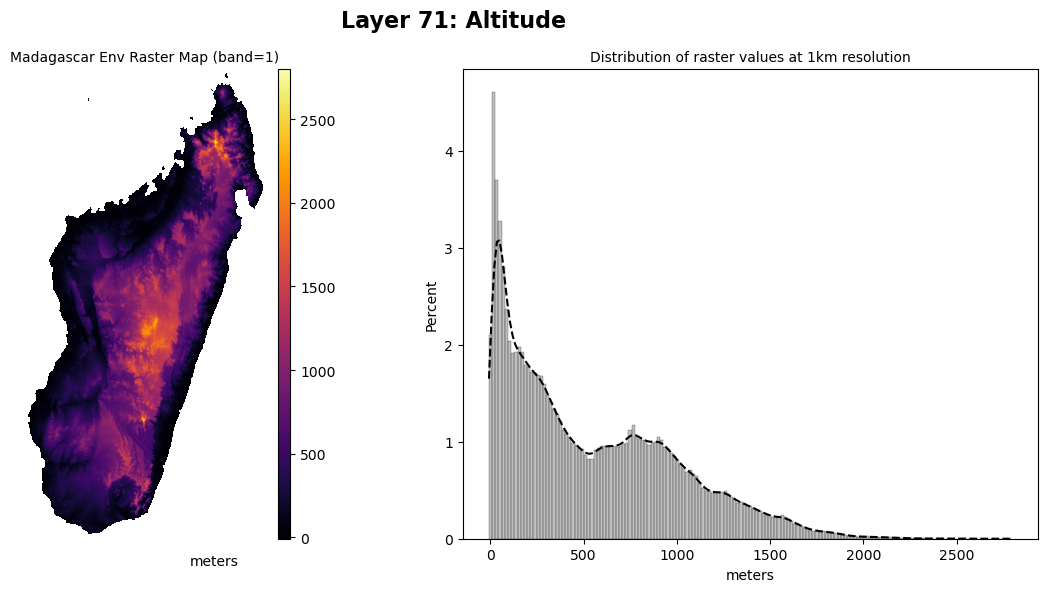

In [43]:
# Default visualization
mada_rasters.plot_layer(71)

Pass in any number of kwargs to the imshow or cax (raster + colorbarax) or histplot or subplots for customization

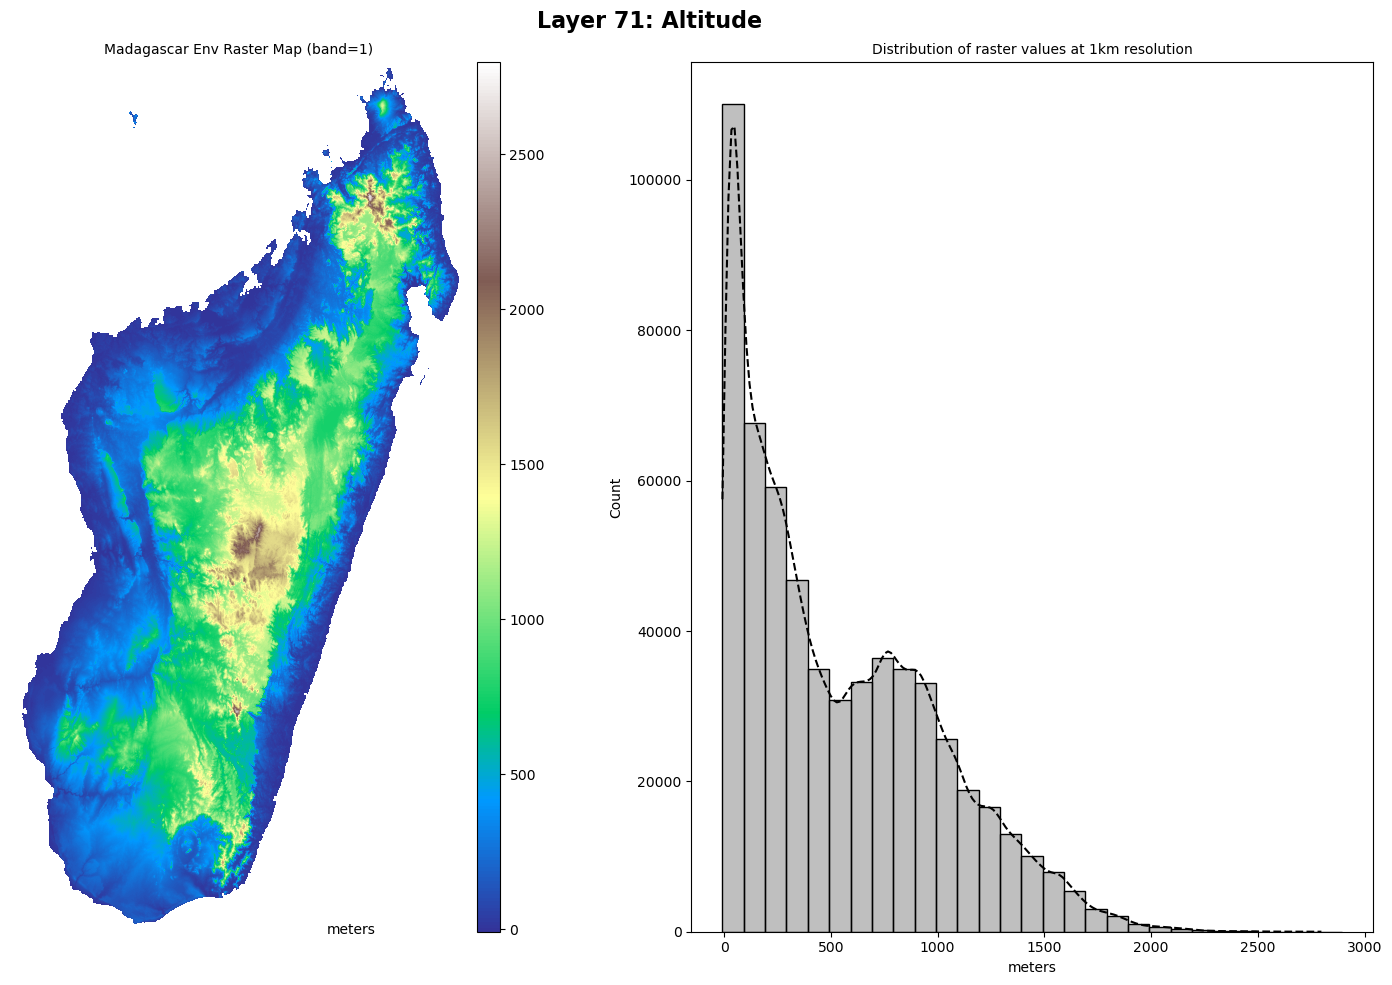

In [44]:
mada_rasters.plot_layer(
    layer=env_labels[0], 
    imshow_cmap="terrain", 
    histplot_binwidth=100, histplot_stat="count", 
    subplots_figsize=(15, 10)
)

For numerical features with highly skewed distribution, specify vmin or vmax for the raster map to at least have a better colorbar scaling

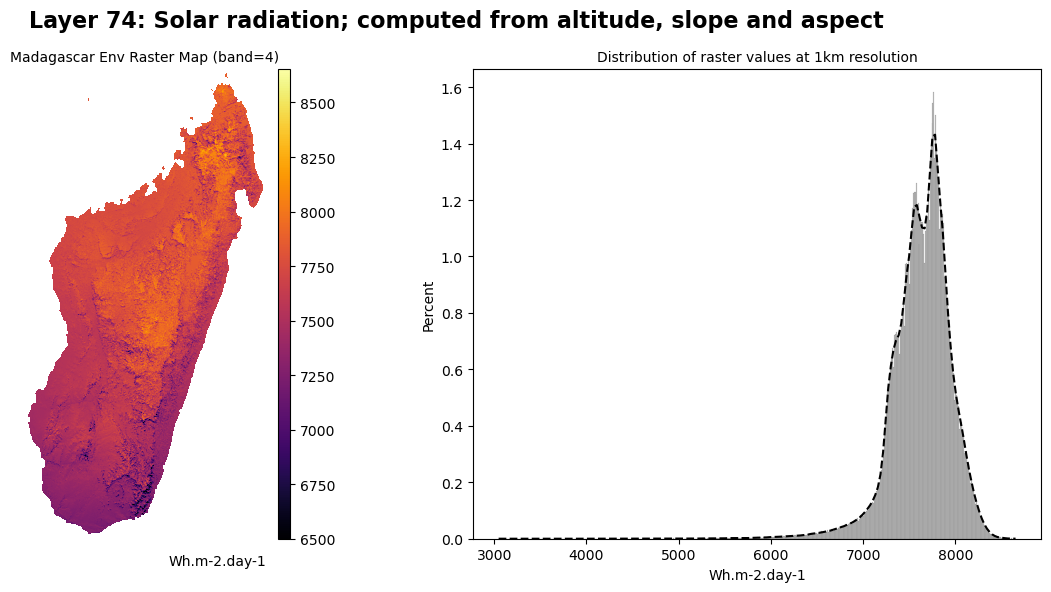

In [45]:
# For numerical features with highly skewed distribution, specify vmin or vmax for the raster map
mada_rasters.plot_layer(layer=env_labels[3], imshow_vmin=6500)

**Categorical data viz**
Reminder: some layers are categorical in that env_raster

In [46]:
categ_layers = mada_info.get_categorical_combinations(as_descriptive_keys=True)
print(f"There are {len(categ_layers)} categorical layers in the Madaclim db")

There are 4 categorical layers in the Madaclim db


In [47]:
list(categ_layers.keys())

['env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)',
 'env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)',
 'env_77_veg_Vegetation types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25)',
 'env_78_wat_Watersheds (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)']

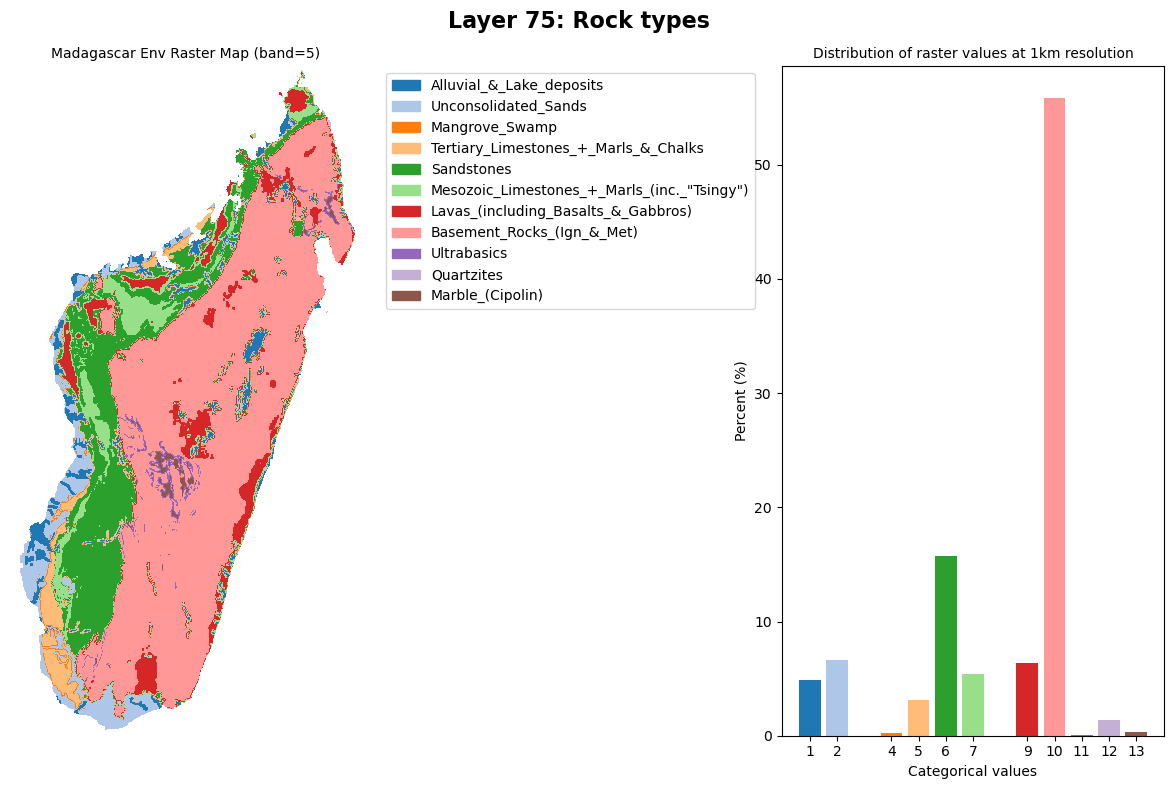

In [48]:
mada_rasters.plot_layer(list(categ_layers.keys())[0], subplots_figsize=(12, 8))

### MadaclimPoint and MadaclimCollection classes


<!-- Checking for similar crs proj between the 2 rasters

OK for this project, if not we can create multiple geometries within a single df and "activate" each one when required. See this github gist : https://gist.github.com/maptastik/0f657b86d7b893c5d7130e487f80d486 -->

#### MadaclimPoint class utilites

In [49]:
df.head()

Species Species code Population code            GBS sequence  \
0       C.abbayesii          ABA            A601        C_abbayesii_A601   
1  C.ambodirianenis          AMB            A572  C_ambodirianensis_A572   
2     C.ambongensis        AMBON           BR071           C_ambongensis   
3    C.ankaranensis         ANK1            A525     C_ankaranensis_A525   
4    C.ankaranensis         ANK2            A808                     NaN   

  Botanical series  Genome size (2C. pg)   Latitude  Longitude  
0         Millotii                  1.25 -24.754100  46.862400  
1         Millotii                  1.27 -18.452200  48.943300  
2       Baracoffea                  1.16 -15.574583  46.419806  
3     Multiflorae                   1.17 -12.949100  49.543300  
4     Multiflorae                   1.17 -12.849100  49.543300

In [50]:
# Rename col for better class handling
df.columns = ["species_name", "specimen_id", "pop_code", "gbs_seq", "botanical_series", "genome_size (2C. pg)", "latitude", "longitude"]
df.head()

species_name specimen_id pop_code                 gbs_seq  \
0       C.abbayesii         ABA     A601        C_abbayesii_A601   
1  C.ambodirianenis         AMB     A572  C_ambodirianensis_A572   
2     C.ambongensis       AMBON    BR071           C_ambongensis   
3    C.ankaranensis        ANK1     A525     C_ankaranensis_A525   
4    C.ankaranensis        ANK2     A808                     NaN   

  botanical_series  genome_size (2C. pg)   latitude  longitude  
0         Millotii                  1.25 -24.754100  46.862400  
1         Millotii                  1.27 -18.452200  48.943300  
2       Baracoffea                  1.16 -15.574583  46.419806  
3     Multiflorae                   1.17 -12.949100  49.543300  
4     Multiflorae                   1.17 -12.849100  49.543300

Example with C abbayesii for MadaclimPoint functionalities

In [51]:
abbayesi = df.iloc[0].to_dict()
abbayesi

{'species_name': 'C.abbayesii',
 'specimen_id': 'ABA',
 'pop_code': 'A601',
 'gbs_seq': 'C_abbayesii_A601',
 'botanical_series': 'Millotii',
 'genome_size (2C. pg)': 1.25,
 'latitude': -24.7541,
 'longitude': 46.8624}

In [52]:
# Create an object with the df cols
spe1 = MadaclimPoint(**abbayesi)

In [53]:
spe1

MadaclimPoint(
	specimen_id = ABA,
	source_crs = 4326,
	longitude = 46.8624,
	latitude = -24.7541,
	mada_geom_point = POINT (688328.2403248843 7260998.022932809),
	sampled_layers = None (Not sampled yet),
	nodata_layers = None (Not sampled yet),
	is_categorical_encoded = False,
	species_name = C.abbayesii,
	pop_code = A601,
	gbs_seq = C_abbayesii_A601,
	botanical_series = Millotii,
	genome_size (2C. pg) = 1.25,
	gdf.shape = (1, 13)
)

In [54]:
try:
    error_test = MadaclimPoint(specimen_id="test", latitude=55123, longitude=-123123, source_crs=3333)
except Exception as e:
    print(e)

longitude=-123123.0 is out of bounds of the Madaclim rasters' for test.
Longitude must fall between 6379618.136561 and 7617913.891767 (according to `source_crs`).


Looking at the class constructor, we need to specify the specimen_id, latitude and longitude. 

If no source_crs is given, it will assume we are supplying lat/lon in the 4326 (GPS) projection. If a source_crs is given, it will validate the lat/lon if it is within possible bounds.

If all checks are OK, it will the create a mada_geom_point based on the climate and environmental rasters CRS' of the Madaclim db. It will also save any addition kwargs as an attribute.

Access the gdf

In [55]:
spe1.gdf

specimen_id  source_crs  longitude  latitude  \
0         ABA        4326    46.8624  -24.7541   

                  mada_geom_point sampled_layers nodata_layers  \
0  POINT (688328.240 7260998.023)           None          None   

   is_categorical_encoded species_name pop_code           gbs_seq  \
0                   False  C.abbayesii     A601  C_abbayesii_A601   

  botanical_series  genome_size (2C. pg)  
0         Millotii                  1.25

**Sample the rasters for that single point**

Using the `sample_from_rasters` and `gdf` attribute to visualize the changes to the instance

In [56]:
spe1.sample_from_rasters(
    clim_raster=mada_rasters.clim_raster, 
    env_raster=mada_rasters.env_raster, 
    layers_to_sample="all", 
    layer_info=True
)


######################################## Extracting data for: ABA ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.



In [57]:
# Update attributes and the geodataframe
spe1

MadaclimPoint(
	specimen_id = ABA,
	source_crs = 4326,
	longitude = 46.8624,
	latitude = -24.7541,
	mada_geom_point = POINT (688328.2403248843 7260998.022932809),
	len(sampled_layers) = 79 layer(s),
	len(nodata_layers) = None (0 layers),
	is_categorical_encoded = False,
	species_name = C.abbayesii,
	pop_code = A601,
	gbs_seq = C_abbayesii_A601,
	botanical_series = Millotii,
	genome_size (2C. pg) = 1.25,
	gdf.shape = (1, 92)
)

In [58]:
spe1.gdf

specimen_id  source_crs  longitude  latitude  \
0         ABA        4326    46.8624  -24.7541   

                  mada_geom_point  sampled_layers  nodata_layers  \
0  POINT (688328.240 7260998.023)              79              0   

   is_categorical_encoded species_name pop_code  ...  \
0                   False  C.abbayesii     A601  ...   

  clim_70_ndm_Number of dry months in the year (months.year-1)  \
0                                                  4             

  env_71_alt_Altitude (meters)  env_72_slo_Slope (degrees)  \
0                          350                          14   

   env_73_asp_Aspect; clockwise from North (degrees)  \
0                                                167   

   env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)  \
0                                               6475                                        

   env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)  \
0                                                 10                         

   env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)  \
0                                                  9                                                                       

   env_77_veg_Vegetation types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25)  \
0                                                 14                                                                  

   env_78_wat_Watersheds (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)  \
0                                                  5                                                                               

   env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)  
0                                                100                        

[1 rows x 92 columns]

In [59]:
print(f"There are {len(spe1.nodata_layers) if spe1.nodata_layers else 0} layers with missing values")

There are 0 layers with missing values


Now we know we have categorical data, we can encode it using `binary_encode_categorical`

In [60]:
spe1.is_categorical_encoded

False

In [61]:
spe1.binary_encode_categorical()

In [62]:
spe1.is_categorical_encoded

True

In [63]:
spe1.gdf

specimen_id  source_crs  longitude  latitude  \
0         ABA        4326    46.8624  -24.7541   

                  mada_geom_point  sampled_layers  nodata_layers  \
0  POINT (688328.240 7260998.023)              79              0   

   is_categorical_encoded species_name pop_code  ...  \
0                    True  C.abbayesii     A601  ...   

  env_78_wat_Watersheds_RetDisp_Mahavavy  \
0                                      0   

  env_78_wat_Watersheds_RetDisp_Manampatrana  \
0                                          0   

   env_78_wat_Watersheds_RetDisp_Mananara_du_Sud  \
0                                              0   

   env_78_wat_Watersheds_RetDisp_Mandrare  \
0                                       0   

   env_78_wat_Watersheds_RetDisp_Mangoky  \
0                                      0   

   env_78_wat_Watersheds_RetDisp_Mangoro  \
0                                      0   

   env_78_wat_Watersheds_RetDisp_Onilahy  \
0                                      0   

   env_78_wat_Watersheds_RetDisp_Sambirano  \
0                                        0   

   env_78_wat_Watersheds_RetDisp_Tsiribihina  env_78_wat_Watersheds__nodata  
0                                          0                              0  

[1 rows x 171 columns]

Also reflected in the `encoded_categ_layers` attribute

In [64]:
spe1.encoded_categ_layers

{'env_75_geo_Rock types_Alluvial_&_Lake_deposits': 0,
 'env_75_geo_Rock types_Basement_Rocks_(Ign_&_Met)': 1,
 'env_75_geo_Rock types_Lavas_(including_Basalts_&_Gabbros)': 0,
 'env_75_geo_Rock types_Mangrove_Swamp': 0,
 'env_75_geo_Rock types_Marble_(Cipolin)': 0,
 'env_75_geo_Rock types_Mesozoic_Limestones_+_Marls_(inc._"Tsingy")': 0,
 'env_75_geo_Rock types_Quartzites': 0,
 'env_75_geo_Rock types_Sandstones': 0,
 'env_75_geo_Rock types_Tertiary_Limestones_+_Marls_&_Chalks': 0,
 'env_75_geo_Rock types_Ultrabasics': 0,
 'env_75_geo_Rock types_Unconsolidated_Sands': 0,
 'env_75_geo_Rock types__nodata': 0,
 'env_76_soi_Soil types_Alluvio-colluvial_Deposited_Soils': 0,
 'env_76_soi_Soil types_Andosols': 1,
 'env_76_soi_Soil types_Bare_Rocks': 0,
 'env_76_soi_Soil types_Fluvio-marine_Deposited_Soils_-_Mangroves': 0,
 'env_76_soi_Soil types_Highly_Rejuvenated,_Penevoluted_Ferralitic_Soils': 0,
 'env_76_soi_Soil types_Humic_Ferralitic_Soils': 0,
 'env_76_soi_Soil types_Humic_Rejuvenated_Ferr

Other methods and properties of interest or helper methods on the MadaclimPoint

In [65]:
spe1.get_default_source_crs()

4326

In [66]:
try:
    spe1.validate_lat(45, mada_rasters.clim_crs)
except Exception as e:
    print(e)

'MadaclimPoint' object has no attribute 'validate_lat'


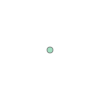

In [67]:
spe1.mada_geom_point

In [68]:
spe1.nodata_layers

We can also smaple the rasters with a specific subset of layers using the layers labels from the `get_layers_labels` method.

In [69]:
# Reminder of our env labels
env_labels

['env_71_alt_Altitude (meters)',
 'env_72_slo_Slope (degrees)',
 'env_73_asp_Aspect; clockwise from North (degrees)',
 'env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)',
 'env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)',
 'env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)',
 'env_77_veg_Vegetation types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25)',
 'env_78_wat_Watersheds (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)',
 'env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)']

In [70]:
spe1.sample_from_rasters(mada_rasters.clim_raster, mada_rasters.env_raster, layers_to_sample=env_labels)


######################################## Extracting data for: ABA ########################################

Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


Finished raster sampling operation in 0.05 seconds.



Dynamicaly updates the attributes and geodataframe

In [71]:
spe1

MadaclimPoint(
	specimen_id = ABA,
	source_crs = 4326,
	longitude = 46.8624,
	latitude = -24.7541,
	mada_geom_point = POINT (688328.2403248843 7260998.022932809),
	len(sampled_layers) = 9 layer(s),
	len(nodata_layers) = None (0 layers),
	is_categorical_encoded = False,
	species_name = C.abbayesii,
	pop_code = A601,
	gbs_seq = C_abbayesii_A601,
	botanical_series = Millotii,
	genome_size (2C. pg) = 1.25,
	gdf.shape = (1, 22)
)

In [72]:
spe1.gdf

specimen_id  source_crs  longitude  latitude  \
0         ABA        4326    46.8624  -24.7541   

                  mada_geom_point  sampled_layers  nodata_layers  \
0  POINT (688328.240 7260998.023)               9              0   

   is_categorical_encoded species_name pop_code  ... genome_size (2C. pg)  \
0                   False  C.abbayesii     A601  ...                 1.25   

  layer_71  layer_72  layer_73  layer_74  layer_75  layer_76  layer_77  \
0      350        14       167      6475        10         9        14   

   layer_78  layer_79  
0         5       100  

[1 rows x 22 columns]

In [73]:
spe1.binary_encode_categorical()

In [74]:
spe1.gdf

specimen_id  source_crs  longitude  latitude  \
0         ABA        4326    46.8624  -24.7541   

                  mada_geom_point  sampled_layers  nodata_layers  \
0  POINT (688328.240 7260998.023)               9              0   

   is_categorical_encoded species_name pop_code  ...  \
0                    True  C.abbayesii     A601  ...   

  layer_78_RetDisp_Mahavavy layer_78_RetDisp_Manampatrana  \
0                         0                             0   

   layer_78_RetDisp_Mananara_du_Sud  layer_78_RetDisp_Mandrare  \
0                                 0                          0   

   layer_78_RetDisp_Mangoky  layer_78_RetDisp_Mangoro  \
0                         0                         0   

   layer_78_RetDisp_Onilahy  layer_78_RetDisp_Sambirano  \
0                         0                           0   

   layer_78_RetDisp_Tsiribihina  layer_78__nodata  
0                             0                 0  

[1 rows x 101 columns]

#### MadaclimCollection class utilites

The MadaclimCollection let's us group MadaclimPoints together and perform operations on the whole set of points

Examples with manually entered data

In [75]:
specimen_1 = MadaclimPoint(specimen_id="spe1_aren", latitude=-18.9333, longitude=48.2, genus="Coffea", species="arenesiana", has_sequencing=True)
specimen_2 = MadaclimPoint(specimen_id="spe2_humb", latitude=-12.716667, longitude=45.066667, source_crs=4326, genus="Coffea", species="humblotiana", has_sequencing=True)
specimen_3 = MadaclimPoint(specimen_id="fictional", latitude=-20.138470, longitude=46.054688, family="Rubiaceae", has_sequencing=False, num_samples=1)

Either populate from an empty collection and use the `add_points` method

In [76]:
example_coll = MadaclimCollection()
example_coll

No MadaclimPoint inside the collection.

In [77]:
example_coll.add_points([specimen_1, specimen_2, specimen_3])
example_coll


MadaclimCollection = [
	MadaclimPoint(specimen_id=spe1_aren, lat=-18.933300, lon=48.200000, sampled_layers=False, categ_encoded=False),
	MadaclimPoint(specimen_id=spe2_humb, lat=-12.716667, lon=45.066667, sampled_layers=False, categ_encoded=False),
	MadaclimPoint(specimen_id=fictional, lat=-20.138470, lon=46.054688, sampled_layers=False, categ_encoded=False)
]

In [78]:
example_coll = MadaclimCollection(madaclim_points=[specimen_1, specimen_2, specimen_3])
example_coll

MadaclimCollection = [
	MadaclimPoint(specimen_id=spe1_aren, lat=-18.933300, lon=48.200000, sampled_layers=False, categ_encoded=False),
	MadaclimPoint(specimen_id=spe2_humb, lat=-12.716667, lon=45.066667, sampled_layers=False, categ_encoded=False),
	MadaclimPoint(specimen_id=fictional, lat=-20.138470, lon=46.054688, sampled_layers=False, categ_encoded=False)
]

Remove points or clear the collection

In [79]:
# By objects
example_coll.remove_points(madaclim_points=specimen_2)
example_coll

MadaclimCollection = [
	MadaclimPoint(specimen_id=spe1_aren, lat=-18.933300, lon=48.200000, sampled_layers=False, categ_encoded=False),
	MadaclimPoint(specimen_id=fictional, lat=-20.138470, lon=46.054688, sampled_layers=False, categ_encoded=False)
]

In [84]:
# By indices
example_coll = MadaclimCollection(madaclim_points=[specimen_1, specimen_2, specimen_3])
example_coll.remove_points(indices=-1)    # rm last 'fictional'
example_coll

MadaclimCollection = [
	MadaclimPoint(specimen_id=spe1_aren, lat=-18.933300, lon=48.200000, sampled_layers=False, categ_encoded=False),
	MadaclimPoint(specimen_id=spe2_humb, lat=-12.716667, lon=45.066667, sampled_layers=False, categ_encoded=False)
]

We can instantiate a collection from a df or a csv using the `populate_from_df` or `populate_from_csv` class methods

In [85]:
example_coll = MadaclimCollection.populate_from_csv(data_dir / "collection_example.csv")
example_coll

Warning! No source_crs column in the csv. Using the default value of EPSG:4326...
Creating MadaclimPoint(specimen_id=ABA...)
Creating MadaclimPoint(specimen_id=AMB...)
Creating MadaclimPoint(specimen_id=AMBON...)
Creating MadaclimPoint(specimen_id=ANK1...)
Created new MadaclimCollection with 4 samples.


MadaclimCollection = [
	MadaclimPoint(specimen_id=ABA, lat=-24.754100, lon=46.862400, sampled_layers=False, categ_encoded=False),
	MadaclimPoint(specimen_id=AMB, lat=-18.452200, lon=48.943300, sampled_layers=False, categ_encoded=False),
	MadaclimPoint(specimen_id=AMBON, lat=-15.574583, lon=46.419806, sampled_layers=False, categ_encoded=False),
	MadaclimPoint(specimen_id=ANK1, lat=-12.949100, lon=49.543300, sampled_layers=False, categ_encoded=False)
]

We can access individual points from the collection

In [86]:
example_coll.all_points[0]

MadaclimPoint(
	specimen_id = ABA,
	source_crs = 4326,
	longitude = 46.8624,
	latitude = -24.7541,
	mada_geom_point = POINT (688328.2403248843 7260998.022932809),
	sampled_layers = None (Not sampled yet),
	nodata_layers = None (Not sampled yet),
	is_categorical_encoded = False,
	Species = C.abbayesii,
	Population_code = A601,
	GBS_sequence = C_abbayesii_A601,
	Botanical_series = Millotii,
	Genome_size_2C_pg = 1.25,
	gdf.shape = (1, 13)
)

We can access the GeoDataFrame `gdf` of the collection based on the `mada_geom_point` attribute of each Point

In [87]:
example_coll.gdf

specimen_id  source_crs  longitude   latitude  \
0         ABA        4326  46.862400 -24.754100   
1         AMB        4326  48.943300 -18.452200   
2       AMBON        4326  46.419806 -15.574583   
3        ANK1        4326  49.543300 -12.949100   

                  mada_geom_point sampled_layers nodata_layers  \
0  POINT (688328.240 7260998.023)           None          None   
1  POINT (916635.952 7955240.629)           None          None   
2  POINT (652237.905 8277614.406)           None          None   
3  POINT (993250.150 8564104.062)           None          None   

   is_categorical_encoded           Species Population_code  \
0                   False       C.abbayesii            A601   
1                   False  C.ambodirianenis            A572   
2                   False     C.ambongensis           BR071   
3                   False    C.ankaranensis            A525   

             GBS_sequence Botanical_series  Genome_size_2C_pg  
0        C_abbayesii_A601         Millotii               1.25  
1  C_ambodirianensis_A572         Millotii               1.27  
2           C_ambongensis       Baracoffea               1.16  
3     C_ankaranensis_A525      Multiflorae               1.17

In [88]:
print(example_coll.sampled_layers)

None


In [89]:
print(example_coll.nodata_layers)

None


**Collection sampling and categorical encoding**

Let's sample all the layers and binary encode the categorical values

In [90]:
example_coll.sample_from_rasters(
    clim_raster=mada_rasters.clim_raster,
    env_raster=mada_rasters.env_raster,
    layers_to_sample="all",
    layer_info=True
)


######################################## Extracting data for: ABA ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.36 seconds.


######################################## Extracting data for: AMB ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.35 seconds.


######################################## Extracting data for: AMBON ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.31 seconds.


######################################## Extracting data for: ANK1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.34 seconds.



In [91]:
example_coll

MadaclimCollection = [
	MadaclimPoint(specimen_id=ABA, lat=-24.754100, lon=46.862400, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=AMB, lat=-18.452200, lon=48.943300, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=AMBON, lat=-15.574583, lon=46.419806, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=ANK1, lat=-12.949100, lon=49.543300, sampled_layers=True, categ_encoded=False)
]

In [92]:
example_coll.sampled_layers

{'ABA': {'clim_1_tmin1_Monthly minimum temperature - January (°C x 10)': 155,
  'clim_2_tmin2_Monthly minimum temperature - February (°C x 10)': 195,
  'clim_3_tmin3_Monthly minimum temperature - March (°C x 10)': 188,
  'clim_4_tmin4_Monthly minimum temperature - April (°C x 10)': 171,
  'clim_5_tmin5_Monthly minimum temperature - May (°C x 10)': 136,
  'clim_6_tmin6_Monthly minimum temperature - June (°C x 10)': 122,
  'clim_7_tmin7_Monthly minimum temperature - July (°C x 10)': 120,
  'clim_8_tmin8_Monthly minimum temperature - August (°C x 10)': 124,
  'clim_9_tmin9_Monthly minimum temperature - September (°C x 10)': 138,
  'clim_10_tmin10_Monthly minimum temperature - October (°C x 10)': 173,
  'clim_11_tmin11_Monthly minimum temperature - November (°C x 10)': 188,
  'clim_12_tmin12_Monthly minimum temperature - December (°C x 10)': 196,
  'clim_13_tmax1_Monthly maximum temperature - January (°C x 10)': 276,
  'clim_14_tmax2_Monthly maximum temperature - February (°C x 10)': 295,


### Exploring the incongruent and missing data in our dataset

#### The case of the MAC specimen

In [93]:
df[df["specimen_id"] == "MAC"].index

Int64Index([28], dtype='int64')

In [94]:
# We need to remove samples with missing lat/lon values
try:
    coffea_collection = MadaclimCollection.populate_from_df(df=df.drop(df[df["specimen_id"] == "MAC"].index))
except Exception as e:
    print(e)

Warning! No source_crs column in the df. Using the default value of EPSG:4326...
Creating MadaclimPoint(specimen_id=ABA...)
Creating MadaclimPoint(specimen_id=AMB...)
Creating MadaclimPoint(specimen_id=AMBON...)
Creating MadaclimPoint(specimen_id=ANK1...)
Creating MadaclimPoint(specimen_id=ANK2...)
Creating MadaclimPoint(specimen_id=ARE...)
Creating MadaclimPoint(specimen_id=AUGA...)
Creating MadaclimPoint(specimen_id=BERT...)
Creating MadaclimPoint(specimen_id=BET...)
Creating MadaclimPoint(specimen_id=BISS...)
Creating MadaclimPoint(specimen_id=BOIN...)
Creating MadaclimPoint(specimen_id=BOI...)
Creating MadaclimPoint(specimen_id=BON...)
Creating MadaclimPoint(specimen_id=COS...)
Creating MadaclimPoint(specimen_id=COU...)
Creating MadaclimPoint(specimen_id=DAP...)
Creating MadaclimPoint(specimen_id=DOL...)
Creating MadaclimPoint(specimen_id=DUB...)
Creating MadaclimPoint(specimen_id=FAR...)
Creating MadaclimPoint(specimen_id=HEI...)
Creating MadaclimPoint(specimen_id=HOM...)
Creating

In [95]:
df.tail()

species_name specimen_id pop_code  \
47      C.vohemarensis        VOHE     A977   
48  C_andrambovatensis        AND2     A310   
49         C_humbertii       HBERT   RNF785   
50           C_labatii       LABAT  APD3096   
51           C_liaudii       LIAUD    A1013   

                               gbs_seq botanical_series  genome_size (2C. pg)  \
47  C_mcphersonii_A977 (=vohemarensis)   Subterminales                   1.08   
48   C_andrambovatensis_A310 (=Leroyi)     Multiflorae                   1.20   
49                  C_humbertii_RNF785       Baracoffea                   NaN   
50                   C_labatii_APD3096       Baracoffea                   NaN   
51                     C_liaudii_A1013              NaN                   NaN   

     latitude  longitude  
47 -15.233300  50.141600  
48 -21.400830  47.942000  
49 -22.875000  43.797500  
50 -18.689444  44.700833  
51 -18.952390  48.225160

In [96]:
# Drop missing lat/lon
specimens_missing_latlon = df.loc[df[["latitude", "longitude"]].isnull().all(axis=1)]
specimens_missing_latlon

Empty DataFrame
Columns: [species_name, specimen_id, pop_code, gbs_seq, botanical_series, genome_size (2C. pg), latitude, longitude]
Index: []

In [97]:
df = df.drop(specimens_missing_latlon.index)
df.tail()

species_name specimen_id pop_code  \
47      C.vohemarensis        VOHE     A977   
48  C_andrambovatensis        AND2     A310   
49         C_humbertii       HBERT   RNF785   
50           C_labatii       LABAT  APD3096   
51           C_liaudii       LIAUD    A1013   

                               gbs_seq botanical_series  genome_size (2C. pg)  \
47  C_mcphersonii_A977 (=vohemarensis)   Subterminales                   1.08   
48   C_andrambovatensis_A310 (=Leroyi)     Multiflorae                   1.20   
49                  C_humbertii_RNF785       Baracoffea                   NaN   
50                   C_labatii_APD3096       Baracoffea                   NaN   
51                     C_liaudii_A1013              NaN                   NaN   

     latitude  longitude  
47 -15.233300  50.141600  
48 -21.400830  47.942000  
49 -22.875000  43.797500  
50 -18.689444  44.700833  
51 -18.952390  48.225160

Now we have to deal with the 'MAC' specimen_id outlier

In [98]:
try:
    coffea_collection = MadaclimCollection.populate_from_df(df=df)
except Exception as e:
    print(e)

Warning! No source_crs column in the df. Using the default value of EPSG:4326...
Creating MadaclimPoint(specimen_id=ABA...)
Creating MadaclimPoint(specimen_id=AMB...)
Creating MadaclimPoint(specimen_id=AMBON...)
Creating MadaclimPoint(specimen_id=ANK1...)
Creating MadaclimPoint(specimen_id=ANK2...)
Creating MadaclimPoint(specimen_id=ARE...)
Creating MadaclimPoint(specimen_id=AUGA...)
Creating MadaclimPoint(specimen_id=BERT...)
Creating MadaclimPoint(specimen_id=BET...)
Creating MadaclimPoint(specimen_id=BISS...)
Creating MadaclimPoint(specimen_id=BOIN...)
Creating MadaclimPoint(specimen_id=BOI...)
Creating MadaclimPoint(specimen_id=BON...)
Creating MadaclimPoint(specimen_id=COS...)
Creating MadaclimPoint(specimen_id=COU...)
Creating MadaclimPoint(specimen_id=DAP...)
Creating MadaclimPoint(specimen_id=DOL...)
Creating MadaclimPoint(specimen_id=DUB...)
Creating MadaclimPoint(specimen_id=FAR...)
Creating MadaclimPoint(specimen_id=HEI...)
Creating MadaclimPoint(specimen_id=HOM...)
Creating

Creating MadaclimPoint(specimen_id=JUM...)
Creating MadaclimPoint(specimen_id=KIA2...)
Creating MadaclimPoint(specimen_id=KIA1...)
Creating MadaclimPoint(specimen_id=LAN...)
Creating MadaclimPoint(specimen_id=AND1...)
Creating MadaclimPoint(specimen_id=LER...)
Creating MadaclimPoint(specimen_id=MAC...)
longitude=57.43 is out of bounds of the Madaclim rasters' for MAC.
Longitude must fall between 42.986762 and 50.978377 (according to `source_crs`).


In [99]:
mac_df = pd.DataFrame(df.loc[df["specimen_id"] == "MAC"])
mac_x, mac_y = mac_df["longitude"].values[0], mac_df["latitude"].values[0]
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32738", always_xy=True)
mac_x, mac_y = transformer.transform(mac_x, mac_y)
mac_df["geometry"] = Point(mac_x, mac_y)
mac_gdf = gpd.GeoDataFrame(mac_df.to_dict(), crs="EPSG:32738",geometry="geometry")
mac_gdf


species_name specimen_id pop_code           gbs_seq  \
28  C.macrocarpa         MAC      MAC  C_macrocarpa-pet   

            botanical_series  genome_size (2C. pg)  latitude  longitude  \
28  Mauritianae_Humblotianae                  1.17   -20.378      57.43   

                           geometry  
28  POINT (1804918.843 7696851.850)

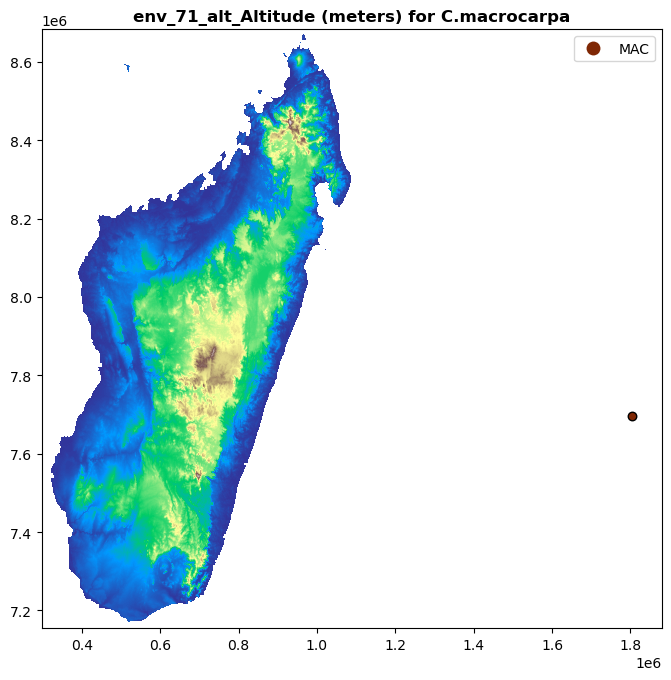

In [100]:
# Lets visualize it on the map
with rasterio.open(mada_rasters.env_raster) as env_raster:
    band_num = mada_info.get_bandnums_from_layers([env_labels[0]])[0]
    band_data = env_raster.read(band_num, masked=True)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plot.show(
        source=band_data, 
        transform=env_raster.transform, 
        cmap="terrain", 
        ax=ax, 
        title=f"{env_labels[0]} for {mac_gdf['species_name'].values[0]}")

    mac_gdf.plot(column="specimen_id", ax=ax, cmap="Oranges_r", markersize=150, marker=".", legend=True, edgecolor="k")

This is because the Macrocarpa species is resident to Mauritius which is not on Madagascar. This species is part of the Non-Madagascar botanical series Humblotianae/Mauritianae originating from Comoros Islands. We will drop the sample from the collection

See Tree Genetics & Genomes (2012) 8:1345–1358
DOI 10.1007/s11295-012-0520-9

***Example to change a specimens lat/lon if it were a typo or other mislabelling***

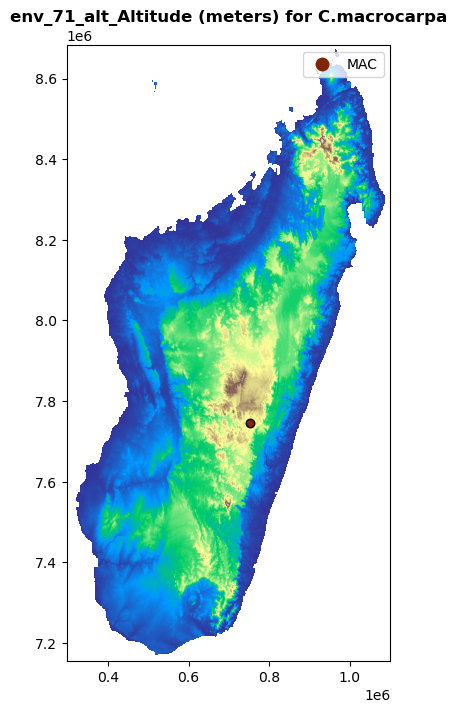

In [101]:
mac_df = pd.DataFrame(df.loc[df["specimen_id"] == "MAC"])
mac_x, mac_y = mac_df["longitude"].values[0] - 10, mac_df["latitude"].values[0]    # REMOVING 10 FROM THE LONGITUDE
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32738", always_xy=True)
mac_x, mac_y = transformer.transform(mac_x, mac_y)
mac_df["geometry"] = Point(mac_x, mac_y)
mac_gdf = gpd.GeoDataFrame(mac_df.to_dict(), crs="EPSG:32738",geometry="geometry")

# Plot the new point on the map
with rasterio.open(mada_rasters.env_raster) as env_raster:
    band_num = mada_info.get_bandnums_from_layers([env_labels[0]])[0]
    band_data = env_raster.read(band_num, masked=True)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plot.show(
        source=band_data, 
        transform=env_raster.transform, 
        cmap="terrain", 
        ax=ax, 
        title=f"{env_labels[0]} for {mac_gdf['species_name'].values[0]}")

    mac_gdf.plot(column="specimen_id", ax=ax, cmap="Oranges_r", markersize=150, marker=".", legend=True, edgecolor="k")

Modifying the df and reconstructing the collection

In [102]:
# Remove Macrocarpa since out of bounds
df = df.drop(df.loc[df["species_name"] == "C.macrocarpa"].index)

In [103]:
coffea_collection = MadaclimCollection.populate_from_df(df=df)

Warning! No source_crs column in the df. Using the default value of EPSG:4326...
Creating MadaclimPoint(specimen_id=ABA...)
Creating MadaclimPoint(specimen_id=AMB...)
Creating MadaclimPoint(specimen_id=AMBON...)
Creating MadaclimPoint(specimen_id=ANK1...)
Creating MadaclimPoint(specimen_id=ANK2...)
Creating MadaclimPoint(specimen_id=ARE...)
Creating MadaclimPoint(specimen_id=AUGA...)
Creating MadaclimPoint(specimen_id=BERT...)
Creating MadaclimPoint(specimen_id=BET...)
Creating MadaclimPoint(specimen_id=BISS...)
Creating MadaclimPoint(specimen_id=BOIN...)
Creating MadaclimPoint(specimen_id=BOI...)
Creating MadaclimPoint(specimen_id=BON...)
Creating MadaclimPoint(specimen_id=COS...)
Creating MadaclimPoint(specimen_id=COU...)
Creating MadaclimPoint(specimen_id=DAP...)
Creating MadaclimPoint(specimen_id=DOL...)
Creating MadaclimPoint(specimen_id=DUB...)
Creating MadaclimPoint(specimen_id=FAR...)
Creating MadaclimPoint(specimen_id=HEI...)
Creating MadaclimPoint(specimen_id=HOM...)
Creating

In [104]:
coffea_collection.sample_from_rasters(
    clim_raster=mada_rasters.clim_raster,
    env_raster=mada_rasters.env_raster,
    layers_to_sample="all",
    layer_info=True
)


######################################## Extracting data for: ABA ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 2: Monthly minimum temperature - February:  1%|▏         | layer 1/70 [Time remaining: 00:00]

Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: AMB ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.35 seconds.


######################################## Extracting data for: AMBON ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.38 seconds.


######################################## Extracting data for: ANK1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.37 seconds.


######################################## Extracting data for: ANK2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.39 seconds.


######################################## Extracting data for: ARE ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.36 seconds.


######################################## Extracting data for: AUGA ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.39 seconds.


######################################## Extracting data for: BERT ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.38 seconds.


######################################## Extracting data for: BET ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.35 seconds.


######################################## Extracting data for: BISS ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.39 seconds.


######################################## Extracting data for: BOIN ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.38 seconds.


######################################## Extracting data for: BOI ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.42 seconds.


######################################## Extracting data for: BON ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: COS ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.37 seconds.


######################################## Extracting data for: COU ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.37 seconds.


######################################## Extracting data for: DAP ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.36 seconds.


######################################## Extracting data for: DOL ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.42 seconds.


######################################## Extracting data for: DUB ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.41 seconds.


######################################## Extracting data for: FAR ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: HEI ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.42 seconds.


######################################## Extracting data for: HOM ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: HUMB ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 5 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.41 seconds.


######################################## Extracting data for: JUM ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.36 seconds.


######################################## Extracting data for: KIA2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: KIA1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.39 seconds.


######################################## Extracting data for: LAN ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.41 seconds.


######################################## Extracting data for: AND1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: LER ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.41 seconds.


######################################## Extracting data for: MAN1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.52 seconds.


######################################## Extracting data for: MAN2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.69 seconds.


######################################## Extracting data for: MIL1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.71 seconds.


######################################## Extracting data for: MIL2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.77 seconds.


######################################## Extracting data for: MOG ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.60 seconds.


######################################## Extracting data for: MON ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.56 seconds.


######################################## Extracting data for: PER1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.55 seconds.


######################################## Extracting data for: PERV ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.58 seconds.


######################################## Extracting data for: RAT ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.57 seconds.


######################################## Extracting data for: RES1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 78 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.52 seconds.


######################################## Extracting data for: RIC ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.49 seconds.


######################################## Extracting data for: SAHA ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.48 seconds.


######################################## Extracting data for: SAK ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.52 seconds.


######################################## Extracting data for: TET ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.39 seconds.


######################################## Extracting data for: TSI ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.39 seconds.


######################################## Extracting data for: VAT ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.52 seconds.


######################################## Extracting data for: VIA1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.49 seconds.


######################################## Extracting data for: VIA2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.44 seconds.


######################################## Extracting data for: VOHE ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.44 seconds.


######################################## Extracting data for: AND2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.41 seconds.


######################################## Extracting data for: HBERT ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: LABAT ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.42 seconds.


######################################## Extracting data for: LIAUD ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.36 seconds.



Looking at those status statements, we have a few samples that contain nodata layers (sampled data that == to NaN)

In [105]:
nan_rich_specimens = {}
for index, point in enumerate(coffea_collection.all_points):
    if point.nodata_layers:
        print(f"{point.species_name} ({point.specimen_id}) has {len(point.nodata_layers)} nodata layers after sampling")
        if len(point.nodata_layers) > round(len(mada_info.all_layers) / 2):    # More than 50% unknowns
            nan_rich_specimens[point.specimen_id] = index

C.ambongensis (AMBON) has 1 nodata layers after sampling
C.humblotiana (HUMB) has 5 nodata layers after sampling
C.resinosa (RES1) has 78 nodata layers after sampling
C.sahafaryensis (SAHA) has 1 nodata layers after sampling


In [106]:
print(nan_rich_specimens)

{'RES1': 37}


We see that RES1 has a lot of nodata layers. Let's look at its position on the raster map

In [107]:
gdf = coffea_collection.gdf.copy()

In [108]:
# Save nan_rich_specimen gdf 
nan_rich_specimens_gdf = gdf.loc[gdf["specimen_id"].isin(nan_rich_specimens.keys())]
nan_rich_specimens_gdf

specimen_id  source_crs  longitude  latitude  \
37        RES1        4326    49.7333    -15.45   

                    mada_geom_point  sampled_layers  nodata_layers  \
37  POINT (1008284.884 8286298.730)              79             78   

    is_categorical_encoded species_name pop_code  ...  \
37                   False   C.resinosa      A71  ...   

   clim_70_ndm_Number of dry months in the year (months.year-1)  \
37                                                NaN             

   env_71_alt_Altitude (meters)  env_72_slo_Slope (degrees)  \
37                          NaN                         NaN   

    env_73_asp_Aspect; clockwise from North (degrees)  \
37                                                NaN   

    env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)  \
37                                                NaN                                        

    env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)  \
37                                                NaN                         

    env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)  \
37                                                NaN                                                                       

    env_77_veg_Vegetation types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25)  \
37                                               25.0                                                                  

    env_78_wat_Watersheds (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)  \
37                                                NaN                                                                               

    env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)  
37                                                NaN                        

[1 rows x 92 columns]

**#TODO: I need to implement those methods as part of the MadaclimPoint and MadaclimCollection classes**

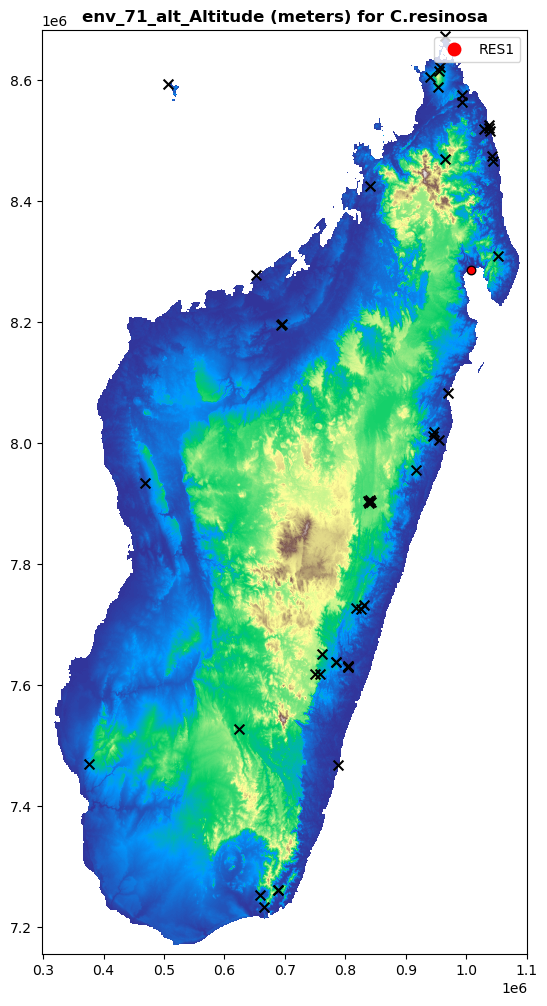

In [109]:
# Plotting with matplotlib.pyplot, rasterio.show and GeoPandas.plot modules
with rasterio.open(mada_rasters.env_raster) as env_raster:
    band_num = mada_info.get_bandnums_from_layers([env_labels[0]])[0]
    band_data = env_raster.read(band_num, masked=True)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax = plot.show(
        source=band_data, 
        transform=env_raster.transform, 
        cmap="terrain", 
        ax=ax, 
        title=f"{env_labels[0]} for {nan_rich_specimens_gdf['species_name'].values[0]}")
    gdf.drop(nan_rich_specimens_gdf.index).plot(ax=ax, color="black", markersize=50, marker="x")
    nan_rich_specimens_gdf.plot(column="specimen_id", ax=ax, cmap="hsv", markersize=150, marker=".", legend=True, edgecolor="k")

**TODO KNN FOR IMPUTATION, WEIGHT PER K NEIGHT + OPTIM FOR K**

C Resinosa might be just a little off-shore. Before we get an actual confirmation, we can artificially resample it's position in terms of latitude to get it to be onshore

**C Resinosa resampling**

In [110]:
# Get the point coord of the base MAC sample
nan_rich_specimens_gdf.iloc[:, :5]

specimen_id  source_crs  longitude  latitude  \
37        RES1        4326    49.7333    -15.45   

                    mada_geom_point  
37  POINT (1008284.884 8286298.730)

In [111]:
nan_rich_specimens_gdf["mada_geom_point"].y.values[0]

8286298.73033832

In [112]:
res1_x, res1_y  = nan_rich_specimens_gdf["mada_geom_point"].x.values[0], nan_rich_specimens_gdf["mada_geom_point"].y.values[0]
print(res1_x, res1_y)


1008284.8837856787 8286298.73033832


In [113]:
# Resample based on 10 intervals for y dist of 1500 meters (150 meters each)
res1_test_resampling = []

intervals = 10
test_range_res1_y = np.linspace(res1_y, res1_y + 1500, intervals)
for i in range (intervals):
    res1_test = {}
    res1_test["specimen_id"] = f"interval_{i}"
    res1_test["longitude"] = res1_x
    res1_test["source_crs"] = mada_rasters.clim_crs
    res1_test["latitude"] = test_range_res1_y[i]
    res1_test_resampling.append(res1_test)      
res1_test_collection = MadaclimCollection(madaclim_points=[MadaclimPoint(**res1_test) for res1_test in res1_test_resampling])

In [114]:
res1_test_collection.gdf

specimen_id  source_crs     longitude      latitude  \
0  interval_0       32738  1.008285e+06  8.286299e+06   
1  interval_1       32738  1.008285e+06  8.286465e+06   
2  interval_2       32738  1.008285e+06  8.286632e+06   
3  interval_3       32738  1.008285e+06  8.286799e+06   
4  interval_4       32738  1.008285e+06  8.286965e+06   
5  interval_5       32738  1.008285e+06  8.287132e+06   
6  interval_6       32738  1.008285e+06  8.287299e+06   
7  interval_7       32738  1.008285e+06  8.287465e+06   
8  interval_8       32738  1.008285e+06  8.287632e+06   
9  interval_9       32738  1.008285e+06  8.287799e+06   

                   mada_geom_point sampled_layers nodata_layers  \
0  POINT (1008284.884 8286298.730)           None          None   
1  POINT (1008284.884 8286465.397)           None          None   
2  POINT (1008284.884 8286632.064)           None          None   
3  POINT (1008284.884 8286798.730)           None          None   
4  POINT (1008284.884 8286965.397)           None          None   
5  POINT (1008284.884 8287132.064)           None          None   
6  POINT (1008284.884 8287298.730)           None          None   
7  POINT (1008284.884 8287465.397)           None          None   
8  POINT (1008284.884 8287632.064)           None          None   
9  POINT (1008284.884 8287798.730)           None          None   

   is_categorical_encoded  
0                   False  
1                   False  
2                   False  
3                   False  
4                   False  
5                   False  
6                   False  
7                   False  
8                   False  
9                   False

We can them sample all the layers and see where the nodata layers are reduced significantly while still being close to the original position

In [115]:
res1_test_collection.sample_from_rasters(mada_rasters.clim_raster, mada_rasters.env_raster)


######################################## Extracting data for: interval_0 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 48: Annual precipitation:  67%|██████▋   | layer 47/70 [Time remaining: 00:00]                   

Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 78 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.55 seconds.


######################################## Extracting data for: interval_1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 78 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.49 seconds.


######################################## Extracting data for: interval_2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 78 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.47 seconds.


######################################## Extracting data for: interval_3 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 78 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.53 seconds.


######################################## Extracting data for: interval_4 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 78 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.75 seconds.


######################################## Extracting data for: interval_5 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.49 seconds.


######################################## Extracting data for: interval_6 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.50 seconds.


######################################## Extracting data for: interval_7 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: interval_8 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.39 seconds.


######################################## Extracting data for: interval_9 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.49 seconds.



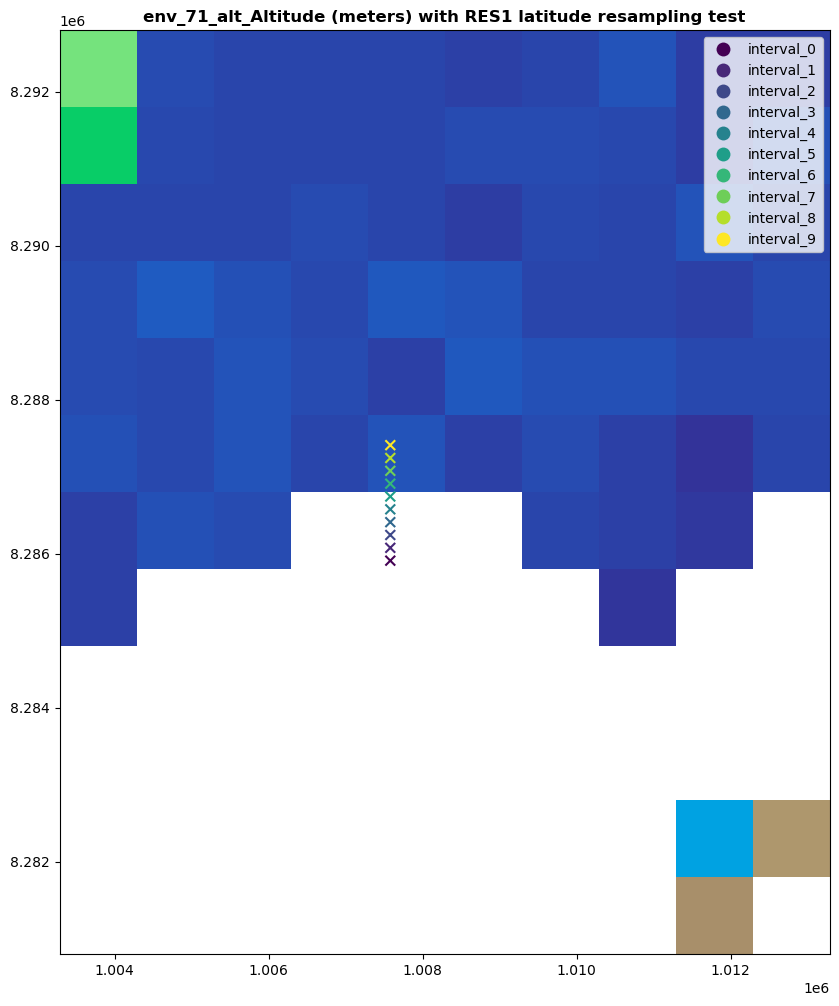

In [116]:
# Plot them on the map
with rasterio.open(mada_rasters.env_raster) as env_raster:
    band_num = mada_info.get_bandnums_from_layers([env_labels[0]])[0]
    
    # Get min and max coordinates of your points, add/subtract a buffer for a clear view
    buffer = 5000  # Adjust this value based on your specific needs
    min_x, min_y, max_x, max_y = res1_test_collection.gdf.total_bounds
    min_x -= buffer
    max_x += buffer
    min_y -= buffer
    max_y += buffer
    
    # Define window from these bounds
    window = windows.from_bounds(min_x, min_y, max_x, max_y, env_raster.transform)
    

    band_data = env_raster.read(band_num, masked=True, window=window)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax = plot.show(
        source=band_data, 
        transform=windows.transform(window, env_raster.transform), 
        cmap="terrain", 
        ax=ax, 
        title=f"{env_labels[0]} with RES1 latitude resampling test")

    # Plot the points on the windowed raster
    # We first make a copy of the GeoDataFrame and adjust its coordinates to the window's context
    temp_gdf = res1_test_collection.gdf.copy()
    temp_gdf.geometry = temp_gdf.geometry.translate(xoff=-window.col_off, yoff=-window.row_off)  # Shift the points' coordinates
    temp_gdf.plot(column="specimen_id", ax=ax, cmap="viridis", markersize=50, marker="x", legend=True)



We could use the 'interval_6' data since it is now onshore and we only have 1 nodata layers

In [117]:
res1_test_collection.all_points[6]

MadaclimPoint(
	specimen_id = interval_6,
	source_crs = 32738,
	longitude = 1008284.8837856787,
	latitude = 8287298.73033832,
	mada_geom_point = POINT (1008284.8837856787 8287298.73033832),
	len(sampled_layers) = 79 layer(s),
	len(nodata_layers) = 1 layer(s),
	is_categorical_encoded = False,
	gdf.shape = (1, 87)
)

Using the pyproj transformer to get the lon/lat in the EPSG:4326 and replace the property of the object on our initial coffea_collection

In [118]:
res1_test_collection.all_points[6].latitude

8287298.73033832

In [119]:
transformer = Transformer.from_crs(res1_test_collection.all_points[6].source_crs, "EPSG:4326", always_xy=True)
res1_new_x, res1_new_y = transformer.transform(res1_test_collection.all_points[6].longitude, res1_test_collection.all_points[6].latitude)
print(res1_new_x, res1_new_y)

49.733095153986426 -15.44099014048609


Evaluate differences in lon/lat and replace the properties

In [120]:
print(f'Absolute difference in longitude (4326/GPS) = {abs(next(point for point in coffea_collection.all_points if point.specimen_id == "RES1").longitude - res1_new_x):.6f}')
print(f'Absolute difference in latitude (4326/GPS) = {abs(next(point for point in coffea_collection.all_points if point.specimen_id == "RES1").latitude - res1_new_y):.6f}')

Absolute difference in longitude (4326/GPS) = 0.000205
Absolute difference in latitude (4326/GPS) = 0.009010


In [121]:
next(point for point in coffea_collection.all_points if point.specimen_id == "RES1").longitude = res1_new_x
next(point for point in coffea_collection.all_points if point.specimen_id == "RES1").latitude = res1_new_y

Resampling the all points in the collection with res1-updated lon/lat values and evaluating nodatalayers

In [122]:
coffea_collection.sample_from_rasters(mada_rasters.clim_raster, mada_rasters.env_raster, layer_info=True)


######################################## Extracting data for: ABA ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 62: Monthly potential evapotranspiration from the Thornthwaite equation - July:  87%|████████▋ | layer 61/70 [Time remaining: 00:00]    

Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.52 seconds.


######################################## Extracting data for: AMB ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.42 seconds.


######################################## Extracting data for: AMBON ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.36 seconds.


######################################## Extracting data for: ANK1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: ANK2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.41 seconds.


######################################## Extracting data for: ARE ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.38 seconds.


######################################## Extracting data for: AUGA ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.41 seconds.


######################################## Extracting data for: BERT ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.48 seconds.


######################################## Extracting data for: BET ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.60 seconds.


######################################## Extracting data for: BISS ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.46 seconds.


######################################## Extracting data for: BOIN ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.38 seconds.


######################################## Extracting data for: BOI ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.42 seconds.


######################################## Extracting data for: BON ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: COS ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.41 seconds.


######################################## Extracting data for: COU ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.43 seconds.


######################################## Extracting data for: DAP ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.44 seconds.


######################################## Extracting data for: DOL ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.48 seconds.


######################################## Extracting data for: DUB ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.42 seconds.


######################################## Extracting data for: FAR ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.43 seconds.


######################################## Extracting data for: HEI ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.37 seconds.


######################################## Extracting data for: HOM ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.47 seconds.


######################################## Extracting data for: HUMB ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 5 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.43 seconds.


######################################## Extracting data for: JUM ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.41 seconds.


######################################## Extracting data for: KIA2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.41 seconds.


######################################## Extracting data for: KIA1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.45 seconds.


######################################## Extracting data for: LAN ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.49 seconds.


######################################## Extracting data for: AND1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.59 seconds.


######################################## Extracting data for: LER ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.56 seconds.


######################################## Extracting data for: MAN1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.48 seconds.


######################################## Extracting data for: MAN2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.50 seconds.


######################################## Extracting data for: MIL1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.50 seconds.


######################################## Extracting data for: MIL2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.54 seconds.


######################################## Extracting data for: MOG ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.68 seconds.


######################################## Extracting data for: MON ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.60 seconds.


######################################## Extracting data for: PER1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.70 seconds.


######################################## Extracting data for: PERV ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.72 seconds.


######################################## Extracting data for: RAT ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.61 seconds.


######################################## Extracting data for: RES1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.54 seconds.


######################################## Extracting data for: RIC ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.46 seconds.


######################################## Extracting data for: SAHA ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 1 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: SAK ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.50 seconds.


######################################## Extracting data for: TET ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.57 seconds.


######################################## Extracting data for: TSI ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.44 seconds.


######################################## Extracting data for: VAT ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.43 seconds.


######################################## Extracting data for: VIA1 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.46 seconds.


######################################## Extracting data for: VIA2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.39 seconds.


######################################## Extracting data for: VOHE ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: AND2 ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.37 seconds.


######################################## Extracting data for: HBERT ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.44 seconds.


######################################## Extracting data for: LABAT ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.40 seconds.


######################################## Extracting data for: LIAUD ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   



Finished raster sampling operation in 0.41 seconds.



In [123]:
coffea_collection

MadaclimCollection = [
	MadaclimPoint(specimen_id=ABA, lat=-24.754100, lon=46.862400, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=AMB, lat=-18.452200, lon=48.943300, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=AMBON, lat=-15.574583, lon=46.419806, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=ANK1, lat=-12.949100, lon=49.543300, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=ANK2, lat=-12.849100, lon=49.543300, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=ARE, lat=-18.933300, lon=48.200000, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=AUGA, lat=-12.733300, lon=49.166660, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=BERT, lat=-25.016660, lon=46.633300, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(specimen_id=BET, lat=-17.930000, lon=49.200000, sampled_layers=True, categ_encoded=False),
	MadaclimPoint(sp

In [124]:
missing_vals_specimens = {}
for index, point in enumerate(coffea_collection.all_points):
    if point.nodata_layers:
        print(f"{point.species_name} ({point.specimen_id}) has {len(point.nodata_layers)} nodata layers after sampling")
        print(f"nodata_layers: {point.nodata_layers}")
        missing_vals_specimens[point.specimen_id] = index
print("\n'specimen': index")
print(missing_vals_specimens)

C.ambongensis (AMBON) has 1 nodata layers after sampling
nodata_layers: ['env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)']
C.humblotiana (HUMB) has 5 nodata layers after sampling
nodata_layers: ['env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)', 'env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)', 'env_77_veg_Vegetation types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25)', 'env_78_wat_Watersheds (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)', 'env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)']
C.resinosa (RES1) has 1 nodata layers after sampling
nodata_layers: ['env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)']
C.sahafaryensis (SAHA) has 1 nodata layers after sampling
nodata_layers: [

## Missing data imputation using the K-Nearest-Neighbors (KNN) algorithm

Recap on the missing data

All missing values are 'env, mostly categorical data and for 1 sample we have the 'forcov' continuous feature missing 

In [125]:
coffea_collection.all_points[0]

MadaclimPoint(
	specimen_id = ABA,
	source_crs = 4326,
	longitude = 46.8624,
	latitude = -24.7541,
	mada_geom_point = POINT (688328.2403248843 7260998.022932809),
	len(sampled_layers) = 79 layer(s),
	len(nodata_layers) = None (0 layers),
	is_categorical_encoded = False,
	species_name = C.abbayesii,
	pop_code = A601,
	gbs_seq = C_abbayesii_A601,
	botanical_series = Millotii,
	genome_size_2C_pg = 1.25,
	gdf.shape = (1, 92)
)

In [126]:
coffea_collection.gdf[coffea_collection.gdf["nodata_layers"] > 0]

specimen_id  source_crs  longitude   latitude  \
2        AMBON        4326  46.419806 -15.574583   
21        HUMB        4326  45.066667 -12.716667   
37        RES1        4326  49.733095 -15.440990   
39        SAHA        4326  49.950000 -13.280000   

                    mada_geom_point  sampled_layers  nodata_layers  \
2    POINT (652237.905 8277614.406)              79              1   
21   POINT (507237.575 8594195.742)              79              5   
37  POINT (1008284.884 8287298.730)              79              1   
39  POINT (1036778.147 8526563.722)              79              1   

    is_categorical_encoded     species_name pop_code  ...  \
2                    False    C.ambongensis    BR071  ...   
21                   False    C.humblotiana     A230  ...   
37                   False       C.resinosa      A71  ...   
39                   False  C.sahafaryensis     A978  ...   

   clim_70_ndm_Number of dry months in the year (months.year-1)  \
2                                                   8             
21                                                  8             
37                                                  1             
39                                                  7             

   env_71_alt_Altitude (meters)  env_72_slo_Slope (degrees)  \
2                            24                           1   
21                          483                          13   
37                            6                           1   
39                           87                           3   

    env_73_asp_Aspect; clockwise from North (degrees)  \
2                                                 304   
21                                                232   
37                                                323   
39                                                348   

    env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)  \
2                                                7784                                        
21                                               7573                                        
37                                               7798                                        
39                                               7973                                        

    env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)  \
2                                                 1.0                         
21                                                NaN                         
37                                                NaN                         
39                                                NaN                         

    env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)  \
2                                                 NaN                                                                       
21                                                NaN                                                                       
37                                               21.0                                                                       
39                                               21.0                                                                       

    env_77_veg_Vegetation types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25)  \
2                                                 5.0                                                                  
21                                                NaN                                                                  
37                                                1.0                                                                  
39                                               16.0                                                                  

    env_78_wat_Watersheds (categ_vals: 1, 2, 3, 4, 5,

### Feature trimming and preprocessing for KNN-imputation of missing values

Since we are dealing with an unsupervised task for now, no worry about data leakage in train/test splits.
**HOWEVER, we will keep the botanical_series as a 'y' for now and maybe use it for evaluating our categorical and numerical feature imputation strategies**.

Note: Since botanical_series and genome_size are provided from outside the Madaclim db, we will put them outside of our features for now. We could decide to reincluded them for our models later on

Pre-processing steps:

0. Encode the categorical data in the MadaclimCollection instance (madaclim db only)
1. Botanical_series transformation (1): LabelEncode for our target (knn-imputation evaluater)
2. Botanical_series transformation (12): OneHotEncode if needed for features
3. Scale the numerical features using either MinMaxScaler or StandardScaler
4. Split the numerical and categorical features in separate df for imputation

### Encoding of Madaclim categorical data + dataset specific categorical feature (botanical series)

#### Encoding of categorical features from the Madaclim db 

Get full data spectrum with the `binary_encode_categorical` data which deals with missing values and creates a new category

In [127]:
coffea_collection.binary_encode_categorical()

Pickle the instance and state for the pre-processing notebook

In [128]:
# Create dir and save instance
Path.mkdir(data_dir / "pickled", exist_ok=True)
mada_coll_pkl = data_dir / "pickled" / "coffea_collection.pkl"
with open(mada_coll_pkl, "wb") as pkl_f:
    pickle.dump(coffea_collection, pkl_f)

In [129]:
coffea_collection.gdf.head()

specimen_id  source_crs  longitude   latitude  \
0         ABA        4326  46.862400 -24.754100   
1         AMB        4326  48.943300 -18.452200   
2       AMBON        4326  46.419806 -15.574583   
3        ANK1        4326  49.543300 -12.949100   
4        ANK2        4326  49.543300 -12.849100   

                  mada_geom_point  sampled_layers  nodata_layers  \
0  POINT (688328.240 7260998.023)              79              0   
1  POINT (916635.952 7955240.629)              79              0   
2  POINT (652237.905 8277614.406)              79              1   
3  POINT (993250.150 8564104.062)              79              0   
4  POINT (993446.882 8575194.181)              79              0   

   is_categorical_encoded      species_name pop_code  ...  \
0                    True       C.abbayesii     A601  ...   
1                    True  C.ambodirianenis     A572  ...   
2                    True     C.ambongensis    BR071  ...   
3                    True    C.ankaranensis     A525  ...   
4                    True    C.ankaranensis     A808  ...   

  env_78_wat_Watersheds_RetDisp_Mahavavy  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

  env_78_wat_Watersheds_RetDisp_Manampatrana  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   env_78_wat_Watersheds_RetDisp_Mananara_du_Sud  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   env_78_wat_Watersheds_RetDisp_Mandrare  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   env_78_wat_Watersheds_RetDisp_Mangoky  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   env_78_wat_Watersheds_RetDisp_Mangoro  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   env_78_wat_Watersheds_RetDisp_Onilahy  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   env_78_wat_Watersheds_RetDisp_Sambirano  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   env_78_wat_Watersheds_RetDisp_Tsiribihina  env_78_wat_Watersheds__nodata  
0                                          0                              0  
1                                          0                              0  
2                                          0                              0  
3                                          0                              0  
4                                          0                              0  

[5 rows x 171 columns]

In [130]:
coffea_collection.gdf

specimen_id  source_crs  longitude   latitude  \
0          ABA        4326  46.862400 -24.754100   
1          AMB        4326  48.943300 -18.452200   
2        AMBON        4326  46.419806 -15.574583   
3         ANK1        4326  49.543300 -12.949100   
4         ANK2        4326  49.543300 -12.849100   
5          ARE        4326  48.200000 -18.933300   
6         AUGA        4326  49.166660 -12.733300   
7         BERT        4326  46.633300 -25.016660   
8          BET        4326  49.200000 -17.930000   
9         BISS        4326  46.812299 -16.315048   
10        BOIN        4326  46.826763 -16.295741   
11         BOI        4326  49.880000 -13.350000   
12         BON        4326  49.177700 -12.491600   
13         COS        4326  50.013300 -13.750000   
14         COU        4326  49.216666 -17.883300   
15         DAP        4326  47.520400 -21.223000   
16         DOL        4326  48.166600 -20.483300   
17         DUB        4326  49.950000 -13.330000   
18         FAR        4326  47.800000 -22.880000   
19         HEI        4326  49.041000 -12.583300   
20         HOM        4326  49.296600 -17.986900   
21        HUMB        4326  45.066667 -12.716667   
22         JUM        4326  49.970000 -13.370200   
23        KIA2        4326  46.862500 -24.754100   
24        KIA1        4326  47.941600 -21.408300   
25         LAN        4326  47.483300 -21.516600   
26        AND1        4326  47.750000 -21.333300   
27         LER        4326  47.750000 -21.333000   
28        MAN1        4326  48.233300 -18.916600   
29        MAN2        4326  48.216600 -18.933300   
30        MIL1        4326  48.037500 -20.520800   
31        MIL2        4326  47.416600 -21.516600   
32         MOG        4326  49.200000 -12.433300   
33         MON        4326  47.942200 -21.409700   
34        PER1        4326  46.565200 -24.833300   
35        PERV        4326  50.034400 -13.820000   
36         RAT        4326  49.294100 -13.800000   
37        RES1        4326  49.733095 -15.440990   
38         RIC        4326  49.416600 -17.283333   
39        SAHA        4326  49.950000 -13.280000   
40         SAK        4326  46.210000 -22.350000   
41         TET        4326  48.150000 -14.225000   
42         TSI        4326  49.266600 -11.966600   
43         VAT        4326  47.930000 -21.400000   
44        VIA1        4326  48.130500 -20.533300   
45        VIA2        4326  48.250000 -18.933300   
46        VOHE        4326  50.141600 -15.233300   
47        AND2        4326  47.942000 -21.400830   
48       HBERT        4326  43.797500 -22.875000   
49       LABAT        4326  44.700833 -18.689444   
50       LIAUD        4326  48.225160 -18.952390   

                    mada_geom_point  sampled_layers  nodata_layers  \
0    POINT (688328.240 7260998.023)              79              0   
1    POINT (916635.952 7955240.629)              79              0   
2    POINT (652237.905 8277614.406)              79              1   
3    POINT (993250.150 8564104.062)              79              0   
4    POINT (993446.882 8575194.181)              79              0   
5    POINT (837072.915 7903496.321)              79              0   
6    POINT (952678.662 8588724.644)              79              0   
7    POINT (664808.037 7232213.963)              79              0   
8    POINT (945123.428 8012530.003)              79              0   
9    POINT (693621.346 8195354.827)              79              0   
10   POINT (695186.217 8197477.648)              79              0   
11  POINT (1029017.945 8518947.447)              79              0   
12   POINT (954307.360 8615498.064)              79              0   
13  POINT (1042588.812 8474269.440)              79              0   
14   POINT (947009.705 8017668.029)              79              0   
15   POINT (761613.828 7651088.106)              79              0   
16   POINT (830348.094 7731838.501)              79              0   
17  POINT (1036667.559 8521015.658)   

ohe using sklearn.preprocessing OneHotEncoder. Remove initial botseries col from X

In [131]:
# # OneHotEncoding in separate array/df
# ohe = OneHotEncoder()
# encoded_botseries = ohe.fit_transform(gdf_mada_whole[["botanical_series"]]).toarray()
# botseries_encoded_labels = list(ohe.get_feature_names_out())
# encoded_botseries = pd.DataFrame(encoded_botseries, columns=botseries_encoded_labels, index=gdf_mada_whole.index)
# # encoded_botseries.head()

# # Concat with original gdf and remove unencoded col
# gdf_mada_whole = pd.concat([gdf_mada_whole, encoded_botseries], axis=1)
# gdf_mada_whole = gdf_mada_whole.drop(columns="botanical_series")
# gdf_mada_whole.head()

###################################################################################################################################################

---

# DEPRECATED CODE ---######--- OLD DATA/STRATEGY ---######---

**We could also check the normality of non-skewed distribution and perform a Box-Cox transformation if we were going to do some linear regression problems in the end**

#### Discretizing genome size for classification evaluation

In [132]:
y_bins = np.linspace(gdf_mada_whole["genome_size_2C_pg"].min(), gdf_mada_whole["genome_size_2C_pg"].max(), num=3)
pd.cut(gdf_mada_whole["genome_size_2C_pg"], bins=y_bins).head()

NameError: name 'gdf_mada_whole' is not defined

Extracting strong correlations

#### 3. Preprocessing for imputation : train/test split + scaling transformation

Write the helper function to prepare the data by: 
- removing the null objects and saving X,y using the wanted features
- train/test splitting with multiple test_sizes
- scaling the splitted datasets

In [ ]:
def prepare_X_for_tts(df: pd.DataFrame, null_feat_y: str, X_features: Optional[Union[str, list]] = None) -> Tuple[Union[pd.DataFrame, pd.Series], pd.Series]:

    """
    This function prepares the input data for train_test_split (tts) by separating the input DataFrame into features (X) and target (y) DataFrames.

    Arguments:
    df (pd.DataFrame): Input DataFrame containing both features and target column.
    null_feat_y (str): The name of the target column in the input DataFrame.
    X_features (Optional[Union[str, list]]): The names of the columns to be used as features. If not provided, all columns except the target column will be used as features.

    Returns:
    Tuple[Union[pd.DataFrame, pd.Series], pd.Series]: A tuple containing two DataFrames: the first one with the features (X) and the second one with the target (y).
    """

    # Use all features from df except y to create X by default
    if X_features is None:    
        X_features = list(df.drop(columns=null_feat_y).columns)

    # Dropping rows where objects have null value for null_feat
    df_notnull = df[df[null_feat_y].notnull()]

    # # Saving null_feat to y
    y = df_notnull[null_feat_y]
    
    # # Dropping the y feature from X_notnull
    X = df_notnull[X_features]
       
    return X, y

In [ ]:
def multiple_tts(X: pd.DataFrame, y: pd.DataFrame, test_sizes: List[float]) -> Tuple[Dict[str, pd.DataFrame], Dict[str, pd.DataFrame], Dict[str, pd.DataFrame], Dict[str, pd.DataFrame]]:
    """
    Function that generates multiple training and test sets using train_test_splits with different test_sizes

    Arguments:
        X (pd.DataFrame): Features dataframe
        y (pd.DataFrame): Target dataframe
        test_sizes (List[float]): List of test sizes to generate splits for

    Returns:
        X_train (Dict[str, pd.DataFrame]): Dictionary of training feature dataframes keyed by test size
        X_test (Dict[str, pd.DataFrame]): Dictionary of testing feature dataframes keyed by test size
        y_train (Dict[str, pd.DataFrame]): Dictionary of training target dataframes keyed by test size
        y_test (Dict[str, pd.DataFrame]): Dictionary of testing target dataframes keyed by test size
    """
    
    # Initialize dicts
    X_train, X_test, y_train, y_test = {}, {}, {}, {}
    
    # Partition data based on test_size param (random seed for repeated runs)
    for test_size in test_sizes:
        X_train[test_size], X_test[test_size], y_train[test_size], y_test[test_size] = train_test_split(X, y, test_size=test_size, random_state=0)

    return X_train, X_test, y_train, y_test


In [ ]:
def apply_scaling(X_train: Dict[str, pd.DataFrame], X_test: Dict[str, pd.DataFrame], test_sizes: List[float], scaler_model) -> Tuple[Dict[str, pd.DataFrame], Dict[str, pd.DataFrame]]:
    """
    Iterate through train/test dict, fit the model for each train/test partition and return the scaled data

    Args:
        X_train (Dict[str, pd.DataFrame]): Dictionary of training feature dataframes keyed by test size
        X_test (Dict[str, pd.DataFrame]): Dictionary of testing feature dataframes keyed by test size
        test_sizes (List[float]): List of test sizes to generate splits for
        scaler_model: Scaler model to fit and transform data

    Returns:
        X_train_scaled (Dict[str, pd.DataFrame]): Dictionary of scaled training feature dataframes keyed by test size
        X_test_scaled (Dict[str, pd.DataFrame]): Dictionary of scaled testing feature dataframes keyed by test size
    """
    # Initialized dicts
    X_train_scaled = {}
    X_test_scaled = {}

    # Save the chosen scaler to string
    scaler_choice = str(scaler_model)[:-8]

    

    # Iterate through each test_size
    for test_size in test_sizes:
        
        # Define all columns to scale but onehotencoded
        continuous_cols = [cont_cols for cont_cols in X_train[test_size].columns if not cont_cols.startswith("onehotencoder")]

        # Define all features regardless if scaled or not
        features = X_train[test_size].columns

        # Create column transformer
        ct = ColumnTransformer(transformers=[(scaler_choice, scaler_model, continuous_cols)], remainder="passthrough")
        
        # Fit the scaler on the given test_size
        fitted_scaler = ct.fit(X_train[test_size])
        
        # Transform train and test sets from fitted scaler
        X_train_scaled[test_size] = pd.DataFrame(
            fitted_scaler.transform(X_train[test_size]),
            columns=fitted_scaler.get_feature_names_out(),
            index=X_train[test_size].index
        )
        
        X_test_scaled[test_size] = pd.DataFrame(
            fitted_scaler.transform(X_test[test_size]), 
            columns=fitted_scaler.get_feature_names_out(),
            index=X_test[test_size].index
        )

    return X_train_scaled, X_test_scaled

**Testing our helper functions to prepare the data for the imputation models**

I need to first prepare each X/y combination. For env_layer8 I will use the most correlated features and for the other layers I will use the whole dataframe.

I will remove the objects with missing data before splitting into training/test sets for each model to train and then scaling the data with different scalers

In [ ]:
# Sanity check for other features
X.isnull().sum()[X.isnull().sum() > 0]

env_layer5 : Geology (Kew Botanical Garden, 1997)                 2
env_layer6 : Soil (Pelletier, 1981)                               2
env_layer7 : Vegetation (Kew Botanical Garden, 2007)              1
env_layer8 : Watersheds (Pearson, 2009)                           1
env_layer9 : Percentage of forest cover for the year 2010 (%).    1
dtype: int64

In [ ]:
# Defining the test_size range for each splits
test_size_range = [0.1, 0.3, 0.5]

In [ ]:
X.shape

(48, 90)

In [ ]:
X.head()

Genome size (2C. pg)   Latitude  Longitude  \
Species code                                               
ABA                           1.25 -24.754100  46.862400   
AMB                           1.27 -18.452200  48.943300   
AMBON                         1.16 -15.574583  46.419806   
ANK1                          1.17 -12.949100  49.543300   
ANK2                          1.17 -12.849100  49.543300   

              onehotencoder__Botanical series_Baracoffea  \
Species code                                               
ABA                                                    0   
AMB                                                    0   
AMBON                                                  1   
ANK1                                                   0   
ANK2                                                   0   

              onehotencoder__Botanical series_Garcinioides   \
Species code                                                  
ABA                                                       0   
AMB                                                       0   
AMBON                                                     0   
ANK1                                                      0   
ANK2                                                      0   

              onehotencoder__Botanical series_HUMB  \
Species code                                         
ABA                                              0   
AMB                                              0   
AMBON                                            0   
ANK1                                             0   
ANK2                                             0   

              onehotencoder__Botanical series_Millotii  \
Species code                                             
ABA                                                  1   
AMB                                                  1   
AMBON                                                0   
ANK1                                                 0   
ANK2                                                 0   

              onehotencoder__Botanical series_Multiflorae   \
Species code                                                 
ABA                                                      0   
AMB                                                      0   
AMBON                                                    0   
ANK1                                                     1   
ANK2                                                     1   

              onehotencoder__Botanical series_Subterminales   \
Species code                                                   
ABA                                                        0   
AMB                                                        0   
AMBON                                                      0   
ANK1                                                       0   
ANK2                                                       0   

              onehotencoder__Botanical series_Verae  ...  \
Species code                                         ...   
ABA                                               0  ...   
AMB                                               0  ...   
AMBON                                             0  ...   
ANK1                                              0  ...   
ANK2                                              0  ...   

              clim_layer70 : Number of dry months in the year  \
Species code                                                    
ABA                                                       4.0   
AMB                                                       1.0   
AMBON                                                     8.0   
ANK1                                                      8.0   
ANK2                                                      8.0   

              env_layer1 : Altitude (m)  env_layer2 : Slope (in degree)  \
Species code                                                              
ABA                              

env_layer8 data prep, splitting and scaling

In [ ]:
# Split in X and y with relevant features for X and proper label for y
env_layer8_X, env_layer8_y = prepare_X_for_tts(df=X, null_feat_y=null_feats[3], X_features=env_layer8_corr_feats)

In [ ]:
print(len(env_layer8_X) == len(env_layer8_y))
env_layer8_X.head()

True


onehotencoder__Botanical series_Baracoffea  \
Species code                                               
ABA                                                    0   
AMB                                                    0   
AMBON                                                  1   
ANK1                                                   0   
ANK2                                                   0   

              clim_layer13 : Monthly maximum temperature (C x 10)_January  \
Species code                                                                
ABA                                                       276.0             
AMB                                                       263.0             
AMBON                                                     326.0             
ANK1                                                      307.0             
ANK2                                                      302.0             

              clim_layer21 : Monthly maximum temperature (C x 10)_September  \
Species code                                                                  
ABA                                                       259.0               
AMB                                                       240.0               
AMBON                                                     320.0               
ANK1                                                      295.0               
ANK2                                                      291.0               

              clim_layer22 : Monthly maximum temperature (C x 10)_October  \
Species code                                                                
ABA                                                       286.0             
AMB                                                       281.0             
AMBON                                                     327.0             
ANK1                                                      315.0             
ANK2                                                      310.0             

              clim_layer30 : Monthly total precipitation (mm.month-1)_June  \
Species code                                                                 
ABA                                                        73.0              
AMB                                                       141.0              
AMBON                                                       1.0              
ANK1                                                       33.0              
ANK2                                                       31.0              

              clim_layer31 : Monthly total precipitation (mm.month-1)_July  \
Species code                                                                 
ABA                                                        58.0              
AMB                                                       136.0              
AMBON                                                       1.0              
ANK1                                                       36.0              
ANK2                                                       36.0              

              clim_layer32 : Monthly total precipitation (mm.month-1)_August  \
Species code                                                                   
ABA                                                        57.0                
AMB                                                       121.0                
AMBON                                                       4.0                
ANK1                                                       35.0                
ANK2                                                       34.0                

              clim_layer33 : Monthly total precipitation (mm.month-1)_September  \
Species code                                                                      
ABA                                                        44.0                   
AMB                                                    

In [ ]:
# Separate in different test_sizes for layer8 dataset
env_layer8_X_train, env_layer8_X_test, env_layer8_y_train, env_layer8_y_test =  multiple_tts(
    X=env_layer8_X,
    y=env_layer8_y,
    test_sizes=test_size_range
)

In [ ]:
# Evaluate the proportion in each set
env_layer8_X_train.keys()

dict_keys([0.1, 0.3, 0.5])

In [ ]:
# Verification of sets length
print("Training sets:\n")
for test_size in test_size_range:
    print(f"{test_size=} :")
    print(f"Num samples in X={len(env_layer8_X_train[test_size])}")
    print(f"Num samples in y={len(env_layer8_y_train[test_size])}")

print("\nTest sets:\n")
for test_size in test_size_range:
    print(f"{test_size=}")
    print(f"Num samples in X={len(env_layer8_X_test[test_size])}")
    print(f"Num samples in y={len(env_layer8_y_test[test_size])}")

Training sets:

test_size=0.1 :
Num samples in X=42
Num samples in y=42
test_size=0.3 :
Num samples in X=32
Num samples in y=32
test_size=0.5 :
Num samples in X=23
Num samples in y=23

Test sets:

test_size=0.1
Num samples in X=5
Num samples in y=5
test_size=0.3
Num samples in X=15
Num samples in y=15
test_size=0.5
Num samples in X=24
Num samples in y=24


Train MinMax and Standard norm/std to env_layer8_X train sets and transform X training+test sets for each test_size

In [ ]:
# Applying minmax scaler to all possible test_sizes for env_layer8 
env_layer8_X_train_minmax, env_layer8_X_test_minmax = apply_scaling(
    X_train=env_layer8_X_train,
    X_test=env_layer8_X_test,
    test_sizes=test_size_range,
    scaler_model=MinMaxScaler()
)

In [ ]:
env_layer8_X_train_minmax[0.3].head()

MinMax__clim_layer13 : Monthly maximum temperature (C x 10)_January  \
Species code                                                                        
VOHE                                                   0.000000                     
LER                                                    0.221154                     
DAP                                                    0.182692                     
AND1                                                   0.221154                     
DOL                                                    0.221154                     

              MinMax__clim_layer21 : Monthly maximum temperature (C x 10)_September  \
Species code                                                                          
VOHE                                                   0.053571                       
LER                                                    0.214286                       
DAP                                                    0.142857                       
AND1                                                   0.214286                       
DOL                                                    0.241071                       

              MinMax__clim_layer22 : Monthly maximum temperature (C x 10)_October  \
Species code                                                                        
VOHE                                                   0.000000                     
LER                                                    0.219512                     
DAP                                                    0.158537                     
AND1                                                   0.219512                     
DOL                                                    0.256098                     

              MinMax__clim_layer30 : Monthly total precipitation (mm.month-1)_June  \
Species code                                                                         
VOHE                                                   0.596078                      
LER                                                    0.423529                      
DAP                                                    0.337255                      
AND1                                                   0.423529                      
DOL                                                    0.556863                      

              MinMax__clim_layer31 : Monthly total precipitation (mm.month-1)_July  \
Species code                                                                         
VOHE                                                   0.570896                      
LER                                                    0.365672                      
DAP                                                    0.264925                      
AND1                                                   0.365672                      
DOL                                                    0.473881                      

              MinMax__clim_layer32 : Monthly total precipitation (mm.month-1)_August  \
Species code                                                                           
VOHE                                                   0.658416                        
LER                                                    0.460396                        
DAP                                                    0.316832                        
AND1                                                   0.460396                        
DOL                                                    0.539604                        

              MinMax__clim_layer33 : Monthly total precipitation (mm.month-1)_September  \
Species code                                                                              
VOHE                                                   0.754545                           
LER                                                    0.654545                           
DAP                      

In [ ]:
env_layer8_X_test_minmax[0.3].head()

MinMax__clim_layer13 : Monthly maximum temperature (C x 10)_January  \
Species code                                                                        
MAN2                                                   0.096154                     
PER1                                                   0.576923                     
MIL2                                                  -0.019231                     
ANK2                                                   0.519231                     
FAR                                                    0.240385                     

              MinMax__clim_layer21 : Monthly maximum temperature (C x 10)_September  \
Species code                                                                          
MAN2                                                   0.044643                       
PER1                                                   0.607143                       
MIL2                                                  -0.062500                       
ANK2                                                   0.607143                       
FAR                                                    0.294643                       

              MinMax__clim_layer22 : Monthly maximum temperature (C x 10)_October  \
Species code                                                                        
MAN2                                                   0.121951                     
PER1                                                   0.621951                     
MIL2                                                  -0.097561                     
ANK2                                                   0.524390                     
FAR                                                    0.170732                     

              MinMax__clim_layer30 : Monthly total precipitation (mm.month-1)_June  \
Species code                                                                         
MAN2                                                   0.219608                      
PER1                                                   0.231373                      
MIL2                                                   0.176471                      
ANK2                                                   0.117647                      
FAR                                                    0.588235                      

              MinMax__clim_layer31 : Monthly total precipitation (mm.month-1)_July  \
Species code                                                                         
MAN2                                                   0.205224                      
PER1                                                   0.130597                      
MIL2                                                   0.171642                      
ANK2                                                   0.126866                      
FAR                                                    0.555970                      

              MinMax__clim_layer32 : Monthly total precipitation (mm.month-1)_August  \
Species code                                                                           
MAN2                                                   0.227723                        
PER1                                                   0.143564                        
MIL2                                                   0.198020                        
ANK2                                                   0.153465                        
FAR                                                    0.584158                        

              MinMax__clim_layer33 : Monthly total precipitation (mm.month-1)_September  \
Species code                                                                              
MAN2                                                   0.309091                           
PER1                                                   0.218182                           
MIL2                     

In [ ]:
# Explanation for negative values since lowest value where model was fitted on is greater than min value of test set when applying the model
print(min(env_layer8_X_train[0.3]["clim_layer21 : Monthly maximum temperature (C x 10)_September"].values))
print(min(env_layer8_X_test[0.3]["clim_layer21 : Monthly maximum temperature (C x 10)_September"].values))

223.0
216.0


In [ ]:
# Applying minmax scaler to all possible test_sizes
env_layer8_X_train_std, env_layer8_X_test_std = apply_scaling(
    X_train=env_layer8_X_train,
    X_test=env_layer8_X_test,
    test_sizes=test_size_range,
    scaler_model=StandardScaler()
)

In [ ]:
env_layer8_X_train_std[0.5].head()


Standard__clim_layer13 : Monthly maximum temperature (C x 10)_January  \
Species code                                                                          
COS                                                    0.283384                       
ARE                                                   -1.106447                       
DUB                                                    0.475085                       
PERV                                                   0.139608                       
COU                                                   -0.866821                       

              Standard__clim_layer21 : Monthly maximum temperature (C x 10)_September  \
Species code                                                                            
COS                                                    0.472356                         
ARE                                                   -1.533340                         
DUB                                                    0.723068                         
PERV                                                   0.388785                         
COU                                                   -0.739418                         

              Standard__clim_layer22 : Monthly maximum temperature (C x 10)_October  \
Species code                                                                          
COS                                                    0.296483                       
ARE                                                   -0.970784                       
DUB                                                    0.537867                       
PERV                                                   0.175791                       
COU                                                   -0.729400                       

              Standard__clim_layer30 : Monthly total precipitation (mm.month-1)_June  \
Species code                                                                           
COS                                                    0.126408                        
ARE                                                   -0.379936                        
DUB                                                   -0.281933                        
PERV                                                   0.191743                        
COU                                                    1.318767                        

              Standard__clim_layer31 : Monthly total precipitation (mm.month-1)_July  \
Species code                                                                           
COS                                                    0.223897                        
ARE                                                   -0.384846                        
DUB                                                   -0.088701                        
PERV                                                   0.306160                        
COU                                                    1.211049                        

              Standard__clim_layer32 : Monthly total precipitation (mm.month-1)_August  \
Species code                                                                             
COS                                                    0.648846                          
ARE                                                   -0.449332                          
DUB                                                   -0.135567                          
PERV                                                   0.766508                          
COU                                                    1.217546                          

              Standard__clim_layer33 : Monthly total precipitation (mm.month-1)_September  \
Species code                                                                                
COS                                                    0.267900                             
ARE                       

In [ ]:
env_layer8_X_test_std[0.5].head()

Standard__clim_layer13 : Monthly maximum temperature (C x 10)_January  \
Species code                                                                          
MAN2                                                  -1.154372                       
PER1                                                   1.241888                       
MIL2                                                  -1.729474                       
ANK2                                                   0.954337                       
FAR                                                   -0.435494                       

              Standard__clim_layer21 : Monthly maximum temperature (C x 10)_September  \
Species code                                                                            
MAN2                                                  -1.533340                         
PER1                                                   1.099136                         
MIL2                                                  -2.034763                         
ANK2                                                   1.099136                         
FAR                                                   -0.363351                         

              Standard__clim_layer22 : Monthly maximum temperature (C x 10)_October  \
Species code                                                                          
MAN2                                                  -1.031130                       
PER1                                                   1.443058                       
MIL2                                                  -2.117359                       
ANK2                                                   0.960289                       
FAR                                                   -0.789746                       

              Standard__clim_layer30 : Monthly total precipitation (mm.month-1)_June  \
Species code                                                                           
MAN2                                                  -0.363602                        
PER1                                                  -0.314601                        
MIL2                                                  -0.543272                        
ANK2                                                  -0.788278                        
FAR                                                    1.171764                        

              Standard__clim_layer31 : Monthly total precipitation (mm.month-1)_July  \
Species code                                                                           
MAN2                                                  -0.368393                        
PER1                                                  -0.697444                        
MIL2                                                  -0.516466                        
ANK2                                                  -0.713896                        
FAR                                                    1.178144                        

              Standard__clim_layer32 : Monthly total precipitation (mm.month-1)_August  \
Species code                                                                             
MAN2                                                  -0.449332                          
PER1                                                  -0.782708                          
MIL2                                                  -0.566994                          
ANK2                                                  -0.743487                          
FAR                                                    0.962611                          

              Standard__clim_layer33 : Monthly total precipitation (mm.month-1)_September  \
Species code                                                                                
MAN2                                                  -0.322050                             
PER1                      

Now automate the processApply the same partitionning and scaling strategies to env_layer 5-6-7-9 but now on the X - y (meaning whole feature set but removing predictor y with null vals)

In [ ]:
# Reminder of features with null vals
non_corr_null_feats = [remaining_feat for remaining_feat in null_feats if not remaining_feat.startswith("env_layer8")]
print(non_corr_null_feats)
X[non_corr_null_feats].isnull().sum()

['env_layer5 : Geology (Kew Botanical Garden, 1997)', 'env_layer6 : Soil (Pelletier, 1981)', 'env_layer7 : Vegetation (Kew Botanical Garden, 2007)', 'env_layer9 : Percentage of forest cover for the year 2010 (%).']


env_layer5 : Geology (Kew Botanical Garden, 1997)                 2
env_layer6 : Soil (Pelletier, 1981)                               2
env_layer7 : Vegetation (Kew Botanical Garden, 2007)              1
env_layer9 : Percentage of forest cover for the year 2010 (%).    1
dtype: int64

Helper function to extract all the features that are highly correlated with features containing missing data

In [ ]:
def extract_correlated_features(df: pd.DataFrame, features: list, threshold: float):

    # Validate threshold
    if not 0 < threshold <= 1:
        raise ValueError(f"Pearson correlation threshold of {threshold} mut take a value between 0 and 1")
    
    # Initialize dictionary container for features/corr-features combinations
    correlated_features = {}

    # Loop through each feature and extract all other correlated features
    for feature in features:
        
        # Initialize temporary list
        corr_feats_list = []
        
        # extract all correlated features according to threshold
        corr_feats_list = [feat for feat in df.corr()[feature][abs(df.corr()[feature]) > threshold].dropna(how="all").index if feat not in features]

        # Save list to dict if at least 1 correlated feature
        if corr_feats_list:
            correlated_features[feature] = corr_feats_list
        
    return correlated_features

In [ ]:
# Generate correlated features with Pearson > 0.5
corr_null_feats = extract_correlated_features(X, null_feats, 0.5)
print(corr_null_feats)

{'env_layer8 : Watersheds (Pearson, 2009)': ['onehotencoder__Botanical series_Baracoffea', 'clim_layer13 : Monthly maximum temperature (C x 10)_January', 'clim_layer21 : Monthly maximum temperature (C x 10)_September', 'clim_layer22 : Monthly maximum temperature (C x 10)_October', 'clim_layer30 : Monthly total precipitation (mm.month-1)_June', 'clim_layer31 : Monthly total precipitation (mm.month-1)_July', 'clim_layer32 : Monthly total precipitation (mm.month-1)_August', 'clim_layer33 : Monthly total precipitation (mm.month-1)_September', 'clim_layer50 : bio14_Precipitation of Driest Period', 'clim_layer51 : bio15_Precipitation Seasonality(C of V)', 'clim_layer53 : bio17_Precipitation of Driest Quarter', 'clim_layer55 : bio19_Precipitation of Coldest Quarter', 'clim_layer56 : Monthly potential evapotranspiration (mm.month-1)_January', 'clim_layer69 : Annual climatic water deficit (mm)']}


In [ ]:
def prepare_data_imputation_models(df: pd.DataFrame, y_features_with_nulls: list, y_features_corr: Optional[dict]=None, test_sizes: List[int]=[0.3], *, scalers: list):
    
    """
    Prepares data for imputation models by splitting the data into training and test sets and applying scaling transformations.

    Arguments:
    df (pd.DataFrame): The input data frame.
    y_features_with_nulls (list): A list of features in the data frame that contain null values.
    y_features_corr (Optional[dict]): A dictionary that maps features to their correlated features. If provided, only the correlated features will be used to split the data into X and y. If not provided, the whole data frame minus the y_feature will be used.
    test_sizes (List[int]): A list of test sizes to use when splitting the data into training and test sets. Defaults to [0.3].
    scalers (list): A list of scaler objects to use when applying scaling transformations to the data.

    Returns:
    A tuple containing the following dictionaries:
    - features_X: A dictionary that maps features to their X data.
    - features_y: A dictionary that maps features to their y data.
    - features_X_train: A dictionary that maps features to their X training data for each test size.
    - features_X_test: A dictionary that maps features to their X test data for each test size.
    - features_y_train: A dictionary that maps features to their y training data for each test size.
    - features_y_test: A dictionary that maps features to their y test data for each test size.
    - features_X_train_scaled: A dictionary that maps scaler names to dictionaries that map features to their scaled X training data for each test size.
    - features_X_test_scaled: A dictionary that maps scaler names to dictionaries that map features to their scaled X test data for each test size.
    """
    
    # Initializate dictionaries
    features_X, features_y = {}, {}
    features_X_train, features_X_test, features_y_train, features_y_test = {}, {}, {}, {}
    features_X_train_scaled, features_X_test_scaled = {}, {}
        
    # Save scaler names
    scaler_names = [str(scaler)[:-8] for scaler in scalers]
    
    # Split X, y to whole df if no correlated features given
    if y_features_corr is None:
        
        # Loop through each feature containing nulls
        for feature in y_features_with_nulls:
            
            # Split in X, y agains whole dataframe - y_feature
            features_X[feature], features_y[feature] = prepare_X_for_tts(df=df, null_feat_y=feature)
        
            # Separate in different test_sizes for each feature with missing values
            features_X_train[feature], features_X_test[feature], features_y_train[feature], features_y_test[feature] = multiple_tts(
                X=features_X[feature],
                y=features_y[feature],
                test_sizes=test_sizes
            )

            #TODO ADD NONE TO BYPASS SCALING
            # Apply scaling transformations to all test_sizes for each feature with missing values
            for i, scaler in enumerate(scalers):
                
                # Create an empty dictionary for the current scaler name if it doesn't exist
                features_X_train_scaled.setdefault(scaler_names[i], {})
                features_X_test_scaled.setdefault(scaler_names[i], {})
                
                # Apply each scaling and save in the scaler_name nested dict of the train/test_scaled dictionaries
                features_X_train_scaled[scaler_names[i]][feature], features_X_test_scaled[scaler_names[i]][feature] = apply_scaling(
                    X_train=features_X_train[feature],
                    X_test=features_X_test[feature],
                    test_sizes=test_sizes,
                    scaler_model=scaler
                )

        return features_X, features_y, features_X_train, features_X_test, features_y_train, features_y_test, features_X_train_scaled, features_X_test_scaled
    
    # Split X, y using correlated features when possible
    else:

        # Loop through each feature containing nulls
        for feature in y_features_with_nulls:

            # Split X, y using correlated features
            if feature in y_features_corr:
                features_X[feature], features_y[feature] = prepare_X_for_tts(df=df, null_feat_y=feature, X_features=y_features_corr[feature])

            else:
                # Split in X, y agains whole dataframe - y_feature
                features_X[feature], features_y[feature] = prepare_X_for_tts(df=df, null_feat_y=feature)
            
            # Separate in different test_sizes for each feature with missing values
            features_X_train[feature], features_X_test[feature], features_y_train[feature], features_y_test[feature] = multiple_tts(
                X=features_X[feature],
                y=features_y[feature],
                test_sizes=test_sizes
            )

            # Apply scaling transformations to all test_sizes for each feature with missing values
            for i, scaler in enumerate(scalers):
                
                # Create an empty dictionary for the current scaler name if it doesn't exist
                features_X_train_scaled.setdefault(scaler_names[i], {})
                features_X_test_scaled.setdefault(scaler_names[i], {})
                
                # Apply each scaling and save in the scaler_name nested dict of the train/test_scaled dictionaries
                features_X_train_scaled[scaler_names[i]][feature], features_X_test_scaled[scaler_names[i]][feature] = apply_scaling(
                    X_train=features_X_train[feature],
                    X_test=features_X_test[feature],
                    test_sizes=test_sizes,
                    scaler_model=scaler
                )
        
        return features_X, features_y, features_X_train, features_X_test, features_y_train, features_y_test, features_X_train_scaled, features_X_test_scaled

**Our prepare_data_imputation_models returns multiple dictionaries with different X, y considerations (based on y_feature correlation), test_sizes, and normalization/standardization scaling**

We can access those 8 datastructures in the returned tuple:

- features_X[feature_name] : dataframe for selected feature that includes all selected features for imputation
- features_y[feature_name] : df/series for the given feature with missing data
- features_X_train[feature_name][test_size_value] : df of selected features for a given training set using a specific test_size (No scaling of the data)
- features_X_test[feature_name][test_size_value] : df of selected features for a given test set using a specific test_size (No scaling of the data)
- features_y_train[feature_name][test_size_value] : df/series for the feature with missing val in the training set using a specific test_size
- features_y_test[feature_name][test_size_value] : df/series for the feature with missing val in the test set using a specific test_size
- features_X_train_scaled[scaler_name][feature_name][test_size_value] : df of selected features for a given training set using a specific test_size (Scaler fitted on untransformed X_train)
- features_X_test_scaled[scaler_name][feature_name][test_size_value] : df of selected features for a given test set using a specific test_size (Scaler fitted on untransformed X_train)

#### Generate the possible combinations to use as input for the regressors to train and evaluate for our imputation task

In [ ]:
missing_feats_X, missing_feats_y, missing_feats_X_train, missing_feats_X_test, missing_feats_y_train, missing_feats_y_test, \
missing_feats_X_train_scaled, missing_feats_X_test_scaled = prepare_data_imputation_models(
    df=X,
    y_features_with_nulls=null_feats, 
    y_features_corr=corr_null_feats,
    test_sizes=[0.1, 0.3, 0.5], 
    scalers=[MinMaxScaler(), StandardScaler()]
)

In [ ]:
# Check out the layers with null data
print(missing_feats_X.keys())

dict_keys(['env_layer5 : Geology (Kew Botanical Garden, 1997)', 'env_layer6 : Soil (Pelletier, 1981)', 'env_layer7 : Vegetation (Kew Botanical Garden, 2007)', 'env_layer8 : Watersheds (Pearson, 2009)', 'env_layer9 : Percentage of forest cover for the year 2010 (%).'])


In [ ]:
# Verifying sample sizes for each feature
for feat in null_feats:
    print(f"Sample size for {feat.split()[0]} = {len(missing_feats_y[feat])}")

Sample size for env_layer5 = 46
Sample size for env_layer6 = 46
Sample size for env_layer7 = 47
Sample size for env_layer8 = 47
Sample size for env_layer9 = 47


In [ ]:
# Matches this
X[null_feats].isnull().sum()

env_layer5 : Geology (Kew Botanical Garden, 1997)                 2
env_layer6 : Soil (Pelletier, 1981)                               2
env_layer7 : Vegetation (Kew Botanical Garden, 2007)              1
env_layer8 : Watersheds (Pearson, 2009)                           1
env_layer9 : Percentage of forest cover for the year 2010 (%).    1
dtype: int64

In [ ]:
# Checking the test_sizes keys
print(missing_feats_X_train[null_feats[0]].keys())

# Checking one test size for layer5
missing_feats_X_train[null_feats[0]][0.3].head()

dict_keys([0.1, 0.3, 0.5])


Genome size (2C. pg)  Latitude  Longitude  \
Species code                                              
AND2                          1.20 -21.40083    47.9420   
FAR                           1.32 -22.88000    47.8000   
DAP                           1.18 -21.22300    47.5204   
MAN1                          1.12 -18.91660    48.2333   
DOL                           1.41 -20.48330    48.1666   

              onehotencoder__Botanical series_Baracoffea  \
Species code                                               
AND2                                                   0   
FAR                                                    0   
DAP                                                    0   
MAN1                                                   0   
DOL                                                    0   

              onehotencoder__Botanical series_Garcinioides   \
Species code                                                  
AND2                                                      0   
FAR                                                       0   
DAP                                                       0   
MAN1                                                      0   
DOL                                                       0   

              onehotencoder__Botanical series_HUMB  \
Species code                                         
AND2                                             0   
FAR                                              0   
DAP                                              0   
MAN1                                             0   
DOL                                              0   

              onehotencoder__Botanical series_Millotii  \
Species code                                             
AND2                                                 0   
FAR                                                  1   
DAP                                                  0   
MAN1                                                 0   
DOL                                                  1   

              onehotencoder__Botanical series_Multiflorae   \
Species code                                                 
AND2                                                     1   
FAR                                                      0   
DAP                                                      1   
MAN1                                                     1   
DOL                                                      0   

              onehotencoder__Botanical series_Subterminales   \
Species code                                                   
AND2                                                       0   
FAR                                                        0   
DAP                                                        0   
MAN1                                                       0   
DOL                                                        0   

              onehotencoder__Botanical series_Verae  ...  \
Species code                                         ...   
AND2                                              0  ...   
FAR                                               0  ...   
DAP                                               0  ...   
MAN1                                              0  ...   
DOL                                               0  ...   

              clim_layer69 : Annual climatic water deficit (mm)  \
Species code                                                      
AND2                                                       22.0   
FAR                                                         0.0   
DAP                                                        40.0   
MAN1                                                       58.0   
DOL                                                        30.0   

              clim_layer70 : Number of dry months in the year  \
Species code                                                    
AND2                                          

In [ ]:
# Verification of sets length
print("Training sets:\n")
for feat in null_feats:
    for test_size in test_size_range:
        print(f"{test_size=} :")
        print(f"Num samples in X_train for {feat.split()[0]} = {len(missing_feats_X_train[feat][test_size])}")
        print(f"Num samples in y_train for {feat.split()[0]} = {len(missing_feats_y_train[feat][test_size])}")

print("\nTest sets:\n")
for feat in null_feats:
    for test_size in test_size_range:
        print(f"{test_size=}")
        print(f"Num samples in X_test for {feat.split()[0]} = {len(missing_feats_X_test[feat][test_size])}")
        print(f"Num samples in y_test for {feat.split()[0]} = {len(missing_feats_X_test[feat][test_size])}")

Training sets:

test_size=0.1 :
Num samples in X_train for env_layer5 = 41
Num samples in y_train for env_layer5 = 41
test_size=0.3 :
Num samples in X_train for env_layer5 = 32
Num samples in y_train for env_layer5 = 32
test_size=0.5 :
Num samples in X_train for env_layer5 = 23
Num samples in y_train for env_layer5 = 23
test_size=0.1 :
Num samples in X_train for env_layer6 = 41
Num samples in y_train for env_layer6 = 41
test_size=0.3 :
Num samples in X_train for env_layer6 = 32
Num samples in y_train for env_layer6 = 32
test_size=0.5 :
Num samples in X_train for env_layer6 = 23
Num samples in y_train for env_layer6 = 23
test_size=0.1 :
Num samples in X_train for env_layer7 = 42
Num samples in y_train for env_layer7 = 42
test_size=0.3 :
Num samples in X_train for env_layer7 = 32
Num samples in y_train for env_layer7 = 32
test_size=0.5 :
Num samples in X_train for env_layer7 = 23
Num samples in y_train for env_layer7 = 23
test_size=0.1 :
Num samples in X_train for env_layer8 = 42
Num sam

In [ ]:
# Check scalers key
print(f"Scalers for training sets : {missing_feats_X_train_scaled.keys()}")
print(f"Scalers for test sets : {missing_feats_X_test_scaled.keys()}")

Scalers for training sets : dict_keys(['MinMax', 'Standard'])
Scalers for test sets : dict_keys(['MinMax', 'Standard'])


Explore the scalings

In [ ]:
# MinMax on feature env_layer7
missing_feats_X_train_scaled["MinMax"][null_feats[2]][0.3].head()

MinMax__Genome size (2C. pg)  MinMax__Latitude  \
Species code                                                   
VOHE                              0.057143          0.749679   
LER                               0.485714          0.282271   
DAP                               0.342857          0.290701   
AND1                              0.371429          0.282249   
DOL                               1.000000          0.347382   

              MinMax__Longitude  \
Species code                      
VOHE                   1.000000   
LER                    0.391698   
DAP                    0.333299   
AND1                   0.391698   
DOL                    0.497660   

              MinMax__clim_layer1 : Monthly minimum temperature (C x 10)_January  \
Species code                                                                       
VOHE                                                   0.265306                    
LER                                                    0.367347                    
DAP                                                    0.193878                    
AND1                                                   0.367347                    
DOL                                                    0.428571                    

              MinMax__clim_layer2 : Monthly minimum temperature (C x 10)_February  \
Species code                                                                        
VOHE                                                   0.264706                     
LER                                                    0.382353                     
DAP                                                    0.132353                     
AND1                                                   0.382353                     
DOL                                                    0.485294                     

              MinMax__clim_layer3 : Monthly minimum temperature (C x 10)_March  \
Species code                                                                     
VOHE                                                   0.324675                  
LER                                                    0.389610                  
DAP                                                    0.168831                  
AND1                                                   0.389610                  
DOL                                                    0.480519                  

              MinMax__clim_layer4 : Monthly minimum temperature (C x 10)_April  \
Species code                                                                     
VOHE                                                   0.351648                  
LER                                                    0.340659                  
DAP                                                    0.153846                  
AND1                                                   0.340659                  
DOL                                                    0.428571                  

              MinMax__clim_layer5 : Monthly minimum temperature (C x 10)_May  \
Species code                                                                   
VOHE                                                   0.381818                
LER                                                    0.236364                
DAP                                                    0.072727                
AND1                                                   0.236364                
DOL                                                    0.345455                

              MinMax__clim_layer6 : Monthly minimum temperature (C x 10)_June  \
Species code                                                                    
VOHE                                                   0.405172                 
LER                                                    0.232759                 
DAP                                                    0.086207                 
AND1              

In [ ]:
# Fitted on X_train and applied on X_test
missing_feats_X_test_scaled["MinMax"][null_feats[2]][0.3].head()

MinMax__Genome size (2C. pg)  MinMax__Latitude  \
Species code                                                   
MAN2                              0.171429          0.466156   
PER1                              0.628571          0.014051   
MIL2                              0.971429          0.268203   
ANK2                              0.314286          0.932376   
FAR                               0.742857          0.163728   

              MinMax__Longitude  \
Species code                      
MAN2                   0.510377   
PER1                   0.090345   
MIL2                   0.306898   
ANK2                   0.847823   
FAR                    0.404416   

              MinMax__clim_layer1 : Monthly minimum temperature (C x 10)_January  \
Species code                                                                       
MAN2                                                   0.030612                    
PER1                                                   0.377551                    
MIL2                                                  -0.020408                    
ANK2                                                   0.785714                    
FAR                                                    0.632653                    

              MinMax__clim_layer2 : Monthly minimum temperature (C x 10)_February  \
Species code                                                                        
MAN2                                                   0.029412                     
PER1                                                   0.544118                     
MIL2                                                  -0.161765                     
ANK2                                                   0.779412                     
FAR                                                    0.823529                     

              MinMax__clim_layer3 : Monthly minimum temperature (C x 10)_March  \
Species code                                                                     
MAN2                                                   0.038961                  
PER1                                                   0.493506                  
MIL2                                                  -0.103896                  
ANK2                                                   0.779221                  
FAR                                                    0.727273                  

              MinMax__clim_layer4 : Monthly minimum temperature (C x 10)_April  \
Species code                                                                     
MAN2                                                   0.032967                  
PER1                                                   0.329670                  
MIL2                                                  -0.076923                  
ANK2                                                   0.791209                  
FAR                                                    0.571429                  

              MinMax__clim_layer5 : Monthly minimum temperature (C x 10)_May  \
Species code                                                                   
MAN2                                                   0.027273                
PER1                                                   0.172727                
MIL2                                                  -0.045455                
ANK2                                                   0.781818                
FAR                                                    0.545455                

              MinMax__clim_layer6 : Monthly minimum temperature (C x 10)_June  \
Species code                                                                    
MAN2                                                   0.025862                 
PER1                                                   0.198276                 
MIL2                                                  -0.043103                 
ANK2              

In [ ]:
# StandardScaling on continuous (everything but OneHotEncoded vars)
missing_feats_X_train_scaled["Standard"][null_feats[3]][0.5].head()

Standard__clim_layer13 : Monthly maximum temperature (C x 10)_January  \
Species code                                                                          
COS                                                    0.283384                       
ARE                                                   -1.106447                       
DUB                                                    0.475085                       
PERV                                                   0.139608                       
COU                                                   -0.866821                       

              Standard__clim_layer21 : Monthly maximum temperature (C x 10)_September  \
Species code                                                                            
COS                                                    0.472356                         
ARE                                                   -1.533340                         
DUB                                                    0.723068                         
PERV                                                   0.388785                         
COU                                                   -0.739418                         

              Standard__clim_layer22 : Monthly maximum temperature (C x 10)_October  \
Species code                                                                          
COS                                                    0.296483                       
ARE                                                   -0.970784                       
DUB                                                    0.537867                       
PERV                                                   0.175791                       
COU                                                   -0.729400                       

              Standard__clim_layer30 : Monthly total precipitation (mm.month-1)_June  \
Species code                                                                           
COS                                                    0.126408                        
ARE                                                   -0.379936                        
DUB                                                   -0.281933                        
PERV                                                   0.191743                        
COU                                                    1.318767                        

              Standard__clim_layer31 : Monthly total precipitation (mm.month-1)_July  \
Species code                                                                           
COS                                                    0.223897                        
ARE                                                   -0.384846                        
DUB                                                   -0.088701                        
PERV                                                   0.306160                        
COU                                                    1.211049                        

              Standard__clim_layer32 : Monthly total precipitation (mm.month-1)_August  \
Species code                                                                             
COS                                                    0.648846                          
ARE                                                   -0.449332                          
DUB                                                   -0.135567                          
PERV                                                   0.766508                          
COU                                                    1.217546                          

              Standard__clim_layer33 : Monthly total precipitation (mm.month-1)_September  \
Species code                                                                                
COS                                                    0.267900                             
ARE                       

In [ ]:
missing_feats_X_test_scaled["Standard"][null_feats[3]][0.5].head()

Standard__clim_layer13 : Monthly maximum temperature (C x 10)_January  \
Species code                                                                          
MAN2                                                  -1.154372                       
PER1                                                   1.241888                       
MIL2                                                  -1.729474                       
ANK2                                                   0.954337                       
FAR                                                   -0.435494                       

              Standard__clim_layer21 : Monthly maximum temperature (C x 10)_September  \
Species code                                                                            
MAN2                                                  -1.533340                         
PER1                                                   1.099136                         
MIL2                                                  -2.034763                         
ANK2                                                   1.099136                         
FAR                                                   -0.363351                         

              Standard__clim_layer22 : Monthly maximum temperature (C x 10)_October  \
Species code                                                                          
MAN2                                                  -1.031130                       
PER1                                                   1.443058                       
MIL2                                                  -2.117359                       
ANK2                                                   0.960289                       
FAR                                                   -0.789746                       

              Standard__clim_layer30 : Monthly total precipitation (mm.month-1)_June  \
Species code                                                                           
MAN2                                                  -0.363602                        
PER1                                                  -0.314601                        
MIL2                                                  -0.543272                        
ANK2                                                  -0.788278                        
FAR                                                    1.171764                        

              Standard__clim_layer31 : Monthly total precipitation (mm.month-1)_July  \
Species code                                                                           
MAN2                                                  -0.368393                        
PER1                                                  -0.697444                        
MIL2                                                  -0.516466                        
ANK2                                                  -0.713896                        
FAR                                                    1.178144                        

              Standard__clim_layer32 : Monthly total precipitation (mm.month-1)_August  \
Species code                                                                             
MAN2                                                  -0.449332                          
PER1                                                  -0.782708                          
MIL2                                                  -0.566994                          
ANK2                                                  -0.743487                          
FAR                                                    0.962611                          

              Standard__clim_layer33 : Monthly total precipitation (mm.month-1)_September  \
Species code                                                                                
MAN2                                                  -0.322050                             
PER1                      

In [ ]:
def check_normality(gdf):
    layers = gdf.iloc[:,l1_index:].columns.to_list()
    for i, layer in enumerate(layers):
        norm = shapiro(gdf[layer])
        if norm.pvalue < 0.05:
            print(f"layer {i+1} is not normally distributed since pval={norm.pvalue} < 0.05")
        # else:
        #     print(f"{layer} follows a normal distribution (null hypothesis)")
check_normality(gdf_gbs)

layer 13 is not normally distributed since pval=0.01563286781311035 < 0.05
layer 22 is not normally distributed since pval=0.026344725862145424 < 0.05
layer 27 is not normally distributed since pval=0.006803478114306927 < 0.05
layer 28 is not normally distributed since pval=0.011577649042010307 < 0.05
layer 29 is not normally distributed since pval=0.003331586252897978 < 0.05
layer 30 is not normally distributed since pval=0.018307127058506012 < 0.05
layer 31 is not normally distributed since pval=0.028063109144568443 < 0.05
layer 32 is not normally distributed since pval=0.016017835587263107 < 0.05
layer 33 is not normally distributed since pval=0.018792366608977318 < 0.05
layer 34 is not normally distributed since pval=0.04594413936138153 < 0.05
layer 40 is not normally distributed since pval=0.0002975565439555794 < 0.05
layer 48 is not normally distributed since pval=0.007411393336951733 < 0.05
layer 51 is not normally distributed since pval=0.005776598118245602 < 0.05
layer 53 is n

Text(0.5, 1.0, 'Genome size distribution')

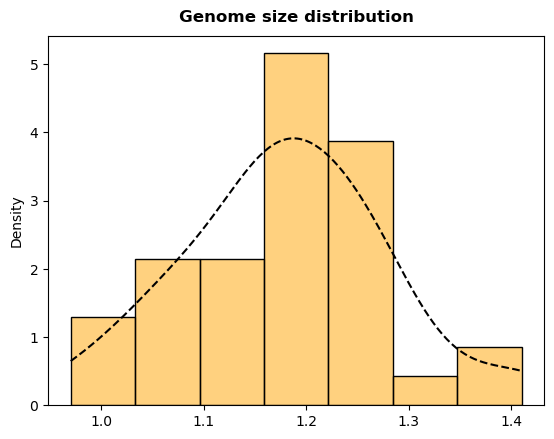

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=gdf_gbs,x="Genome size (2C. pg)",color="orange",ax=ax,kde=True, stat="density",line_kws={"linestyle" : "--"})
ax.set_xlabel("")
ax.lines[0].set_color("black")
ax.set_title(f"Genome size distribution", pad=10, weight="bold")

In [ ]:
norm_gs = shapiro(gdf_gbs["Genome size (2C. pg)"])
if norm_gs.pvalue > 0.05:
    print(f"Genome size distribution is normally distributed (pval = {norm_gs.pvalue:.4f})")

Genome size distribution is normally distributed (pval = 0.8546)


**Correlation to GPS position**

---

## Unsupervised clustering with madaclim layers

In [ ]:
gdf_gbs.head()

Genome size (2C. pg)  Longitude   Latitude  \
Species code                                               
ABA                           1.25  46.862400 -24.754100   
AMB                           1.27  48.943300 -18.452200   
AMBON                         1.16  46.419806 -15.574583   
ANK1                          1.17  49.543300 -12.949100   
ARE                           1.11  48.200000 -18.933300   

                                    geometry  \
Species code                                   
ABA           POINT (688328.240 7260998.023)   
AMB           POINT (916635.952 7955240.629)   
AMBON         POINT (652237.905 8277614.406)   
ANK1          POINT (993250.150 8564104.062)   
ARE           POINT (837072.915 7903496.321)   

                                                     all_layers  \
Species code                                                      
ABA           [155, 195, 188, 171, 136, 122, 120, 124, 138, ...   
AMB           [157, 203, 199, 185, 164, 149, 142, 139, 144, ...   
AMBON         [222, 236, 238, 235, 217, 199, 191, 193, 205, ...   
ANK1          [206, 228, 227, 224, 211, 192, 186, 188, 194, ...   
ARE           [130, 176, 166, 153, 126, 107, 109, 107, 114, ...   

              layer1 : Monthly minimum temperature (C x 10)_January  \
Species code                                                          
ABA                                                       155.0       
AMB                                                       157.0       
AMBON                                                     222.0       
ANK1                                                      206.0       
ARE                                                       130.0       

              layer2 : Monthly minimum temperature (C x 10)_February  \
Species code                                                           
ABA                                                       195.0        
AMB                                                       203.0        
AMBON                                                     236.0        
ANK1                                                      228.0        
ARE                                                       176.0        

              layer3 : Monthly minimum temperature (C x 10)_March  \
Species code                                                        
ABA                                                       188.0     
AMB                                                       199.0     
AMBON                                                     238.0     
ANK1                                                      227.0     
ARE                                                       166.0     

              layer4 : Monthly minimum temperature (C x 10)_April  \
Species code                                                        
ABA                                                       171.0     
AMB                                                       185.0     
AMBON                                                     235.0     
ANK1                                                      224.0     
ARE                                                       153.0     

              layer5 : Monthly minimum temperature (C x 10)_May  ...  \
Species code                                                     ...   
ABA                                                       136.0  ...   
AMB                                                       164.0  ...   
AMBON                                                     217.0  ...   
ANK1                                                      211.0  ...   
ARE                                                       126.0  ...   

              layer61 : Monthly potential evapotranspiration (mm.month-1)_June  \
Species code                                                                     
ABA                                                        50.0                  
AMB                                                        61.0 

## Climate-based clustering

As shown above, there was correlation between some of the climate variables and the geographical location of the samples, especially for Latitude. Using an unsupervised approach, let's see what our clusters will look like on the map based on the madaclim layers AND/OR GPS positions as features.

### Climate data standardization

No categorial data so no need to convert before scaling

In [ ]:
# Separating by layers
features = [f"{k} : {v}" for k,v in mada_layers.items()]
X = gdf_gbs[features]
X.head()

layer1 : Monthly minimum temperature (C x 10)_January  \
Species code                                                          
ABA                                                       155.0       
AMB                                                       157.0       
AMBON                                                     222.0       
ANK1                                                      206.0       
ARE                                                       130.0       

              layer2 : Monthly minimum temperature (C x 10)_February  \
Species code                                                           
ABA                                                       195.0        
AMB                                                       203.0        
AMBON                                                     236.0        
ANK1                                                      228.0        
ARE                                                       176.0        

              layer3 : Monthly minimum temperature (C x 10)_March  \
Species code                                                        
ABA                                                       188.0     
AMB                                                       199.0     
AMBON                                                     238.0     
ANK1                                                      227.0     
ARE                                                       166.0     

              layer4 : Monthly minimum temperature (C x 10)_April  \
Species code                                                        
ABA                                                       171.0     
AMB                                                       185.0     
AMBON                                                     235.0     
ANK1                                                      224.0     
ARE                                                       153.0     

              layer5 : Monthly minimum temperature (C x 10)_May  \
Species code                                                      
ABA                                                       136.0   
AMB                                                       164.0   
AMBON                                                     217.0   
ANK1                                                      211.0   
ARE                                                       126.0   

              layer6 : Monthly minimum temperature (C x 10)_June  \
Species code                                                       
ABA                                                       122.0    
AMB                                                       149.0    
AMBON                                                     199.0    
ANK1                                                      192.0    
ARE                                                       107.0    

              layer7 : Monthly minimum temperature (C x 10)_July  \
Species code                                                       
ABA                                                       120.0    
AMB                                                       142.0    
AMBON                                                     191.0    
ANK1                                                      186.0    
ARE                                                       109.0    

              layer8 : Monthly minimum temperature (C x 10)_August  \
Species code                                                         
ABA                                                       124.0      
AMB                                                       139.0      
AMBON                                                     193.0      
ANK1                                                      188.0      
ARE                                                       107.0      

              layer9 : Monthly minimum temperature (C x 10)_September  \
Species code                                           

In [ ]:
# Scaling data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pd.DataFrame(X_scaled).head()

0         1         2         3         4         5         6   \
0 -0.890067 -0.785269 -0.897862 -1.074336 -1.287619 -1.176651 -1.126965   
1 -0.811750 -0.373872 -0.363608 -0.498838 -0.375188 -0.298776 -0.398332   
2  1.733567  1.323144  1.530566  1.556509  1.351911  1.326918  1.224534   
3  1.107028  0.911746  0.996312  1.104333  1.156391  1.099321  1.058935   
4 -1.869035 -1.762339 -1.966370 -1.814261 -1.613486 -1.664359 -1.491282   

         7         8         9   ...        60        61        62        63  \
0 -1.068908 -0.915779 -0.935557  ... -1.119959 -1.027260 -0.966605 -0.760608   
1 -0.557931 -0.698575 -0.678192  ... -0.556519 -0.850476 -0.908640 -0.972604   
2  1.281584  1.509666  1.809671  ...  1.799688  1.860217  2.221468  2.419334   
3  1.111259  1.111459  1.123364  ...  1.389913  1.270936  1.236064  1.147357   
4 -1.648014 -1.784596 -1.836334  ... -1.222403 -1.262973 -1.314395 -1.290598   

         64        65        66        67        68        69  
0 -0.811644 -0.667160 -0.411554 -0.839854 -0.695047 -0.346835  
1 -0.811644 -0.716236 -0.516211 -0.756344 -0.936351 -1.263471  
2  2.382182  1.982912  1.315276  2.179700  2.358839  0.875346  
3  1.184497  1.148630  0.791994  1.181972  0.982217  0.875346  
4 -1.166514 -1.403292 -1.510447 -1.415635 -0.758340 -0.346835  

[5 rows x 70 columns]

In [ ]:
X_scaled.mean(axis=0)

array([-4.26835744e-16,  5.52673523e-16,  1.08678082e-16,  2.14543098e-16,
       -3.60072332e-17, -1.47029536e-16, -1.51530440e-16, -2.61052441e-16,
        2.40048222e-16,  1.70284207e-16,  3.20689421e-16, -9.45189872e-17,
       -2.58051838e-16, -1.20174141e-15,  7.09642555e-16,  2.88057866e-16,
       -9.57192283e-16,  1.65033152e-16, -6.60132609e-17, -2.10042194e-16,
        6.81136829e-16, -8.76176009e-16,  1.52130560e-15,  1.72609674e-15,
        1.20024111e-16, -3.06061482e-16,  1.26025316e-16,  4.05081374e-17,
       -4.80096443e-17,  2.70054249e-17, -3.00060277e-18,  2.40048222e-17,
       -5.40108498e-17, -1.08021700e-16,  2.52800783e-16, -1.89037974e-16,
        3.64573236e-16, -1.14022905e-16,  5.04101265e-16,  7.50150692e-17,
       -1.39077938e-15,  3.81076552e-16, -3.31566606e-16, -8.17664255e-16,
        2.46049427e-16, -5.45359553e-16,  4.92098854e-16,  2.04040988e-16,
       -2.82056660e-16,  1.44028933e-16,  2.07041591e-16, -1.62032550e-16,
        6.00120554e-17,  

### PCA for madaclim layers 1-70

1 component(s) = 58.55% of explained variance (cumul = 58.55%)
2 component(s) = 20.89% of explained variance (cumul = 79.44%)
3 component(s) = 9.39% of explained variance (cumul = 88.82%)
4 component(s) = 7.57% of explained variance (cumul = 96.39%)
5 component(s) = 1.10% of explained variance (cumul = 97.49%)
6 component(s) = 0.62% of explained variance (cumul = 98.11%)
7 component(s) = 0.54% of explained variance (cumul = 98.66%)
8 component(s) = 0.37% of explained variance (cumul = 99.03%)
9 component(s) = 0.22% of explained variance (cumul = 99.25%)
10 component(s) = 0.16% of explained variance (cumul = 99.42%)
11 component(s) = 0.13% of explained variance (cumul = 99.55%)
12 component(s) = 0.12% of explained variance (cumul = 99.66%)
13 component(s) = 0.08% of explained variance (cumul = 99.74%)
14 component(s) = 0.07% of explained variance (cumul = 99.81%)
15 component(s) = 0.04% of explained variance (cumul = 99.85%)
16 component(s) = 0.04% of explained variance (cumul = 99.89%)

PCA()

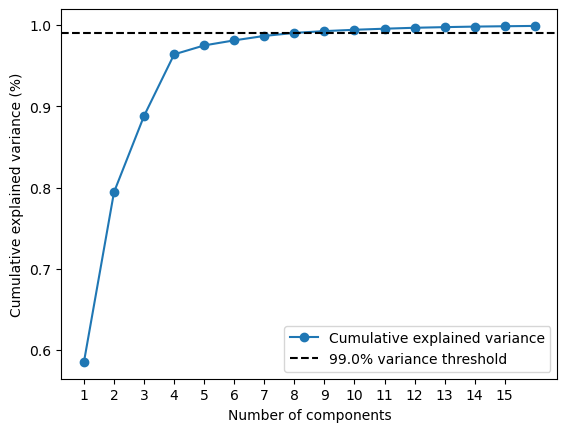

In [ ]:
def find_pca_ncompo(X, threshold):
    # Calculate cumulated variance
    pca = PCA()
    pca.fit(X)
    
    # Sum of explained variances for n_compo
    total = 0
    for i, compo in enumerate(pca.components_):
        total += pca.explained_variance_ratio_[i]
        print(
            f"{i+1} component(s) =",
            f"{pca.explained_variance_ratio_[i]*100:.2f}% of explained variance",
            f"(cumul = {total*100:.2f}%)"
        )
        if total*100 >= 99.9:
            max_compo = i
            break
    
    # Plot
    n_compo = np.arange(1, max_compo+1)
    cumul = pca.explained_variance_ratio_.cumsum()
    plt.figure()
    plt.plot(n_compo, cumul[:max_compo], marker="o")
    plt.xticks(np.arange(min(n_compo), max(n_compo)))
    plt.axhline(y=threshold, color="black", linestyle="--" )
    plt.legend(["Cumulative explained variance", f"{threshold*100}% variance threshold"])
    plt.ylabel("Cumulative explained variance (%)")
    plt.xlabel("Number of components")
    return pca
find_pca_ncompo(X_scaled, 0.99)

In [ ]:
# Dimensionality reduction with 8 components to capture 99% of the variance
pca = PCA(n_components=8)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

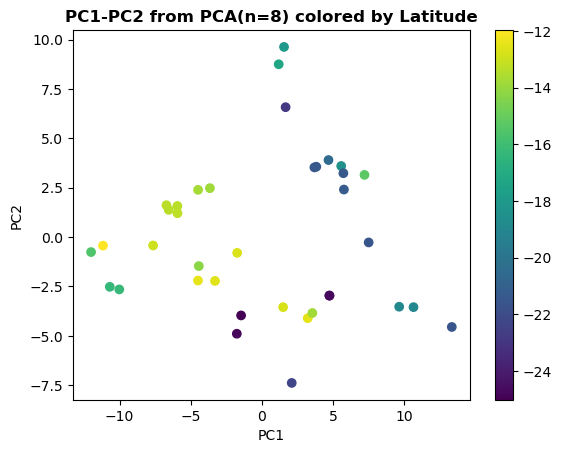

In [ ]:
# Plot the first 2 dimension for visualization purposes
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gdf_gbs["Latitude"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1-PC2 from PCA(n=8) colored by Latitude", weight="bold")
plt.colorbar()

Text(0.5, 1.0, 't-SNE projection from PCA(n=8) colored by Latitude')

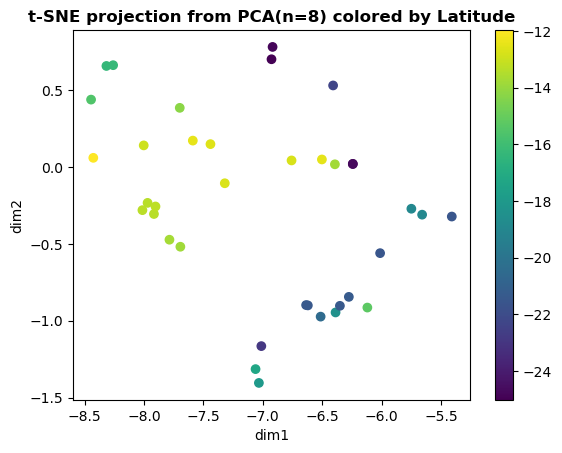

In [ ]:
# t-SNE viz with 2 compo
tsne = TSNE(random_state=0)
X_tsne = tsne.fit_transform(X_pca)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gdf_gbs["Latitude"])
plt.xlabel("dim1")
plt.ylabel("dim2")
plt.colorbar()
plt.title("t-SNE projection from PCA(n=8) colored by Latitude", weight="bold")

### Clustering

#### K-means
Using the 8PC-reduced data, let's determine the number of K clusters

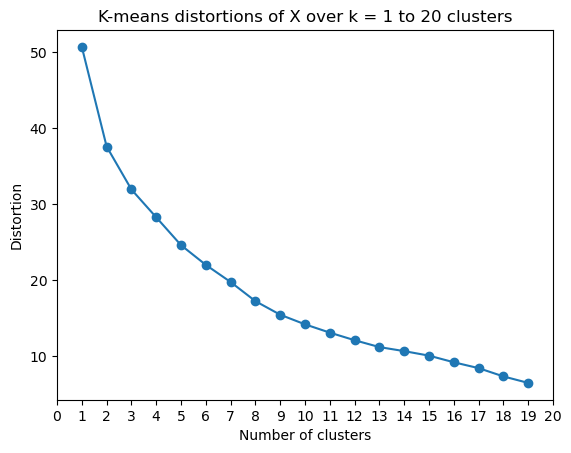

[50.644570790717864,
 37.54383967105194,
 31.89123736997579,
 28.23351215462066,
 24.567994664436302,
 21.975277391717874,
 19.720563633231478,
 17.203226576961047,
 15.417544458933591,
 14.154406587907213,
 13.063774953177159,
 12.065734638080114,
 11.162486939497317,
 10.631107088662807,
 10.037392579538887,
 9.164953078130873,
 8.394702844450633,
 7.304844074646544,
 6.449542508482596]

In [ ]:
# Elbow method
def elbow_method(X, min_clusters, max_clusters):
    # Kmeans for each min/max clusters
    distortions = []
    for i in range(min_clusters, max_clusters):
        km = KMeans(n_clusters=i, n_init=10).fit(X)
        distortions.append(np.sqrt(km.inertia_))
    # Plot distortions
    fig = plt.figure()
    
    plt.plot(range(min_clusters,len(distortions)+min_clusters), distortions, marker="o")
    plt.title(
        f"K-means distortions of {list(locals().keys())[0]} over k = {min_clusters} to {max_clusters} clusters"
    )
    plt.xlabel("Number of clusters")
    plt.xticks(range(min_clusters-1, max_clusters+1))
    plt.ylabel("Distortion")
    plt.show()
    
    return distortions

elbow_method(X_pca, 1, 20)

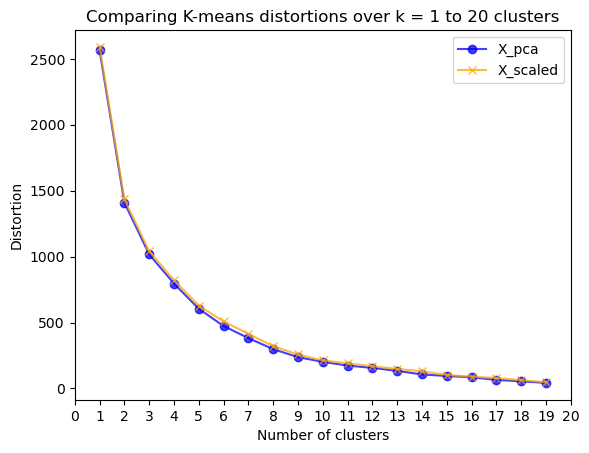

In [ ]:
# Comparing non-PCA vs 8PC
distos_pca = []
distos_scaled = []
min_clusters = 1
max_clusters = 20

for i in range(min_clusters, max_clusters):
    km_pca = KMeans(n_clusters=i, n_init=10).fit(X_pca)
    km_scaled = KMeans(n_clusters=i, n_init=10).fit(X_scaled)
    distos_pca.append(km_pca.inertia_)
    distos_scaled.append(km_scaled.inertia_)
# Plot distos_pca
fig = plt.figure()

plt.plot(range(min_clusters,len(distos_pca)+min_clusters), distos_pca, marker="o", c="blue", alpha=0.75)
plt.plot(range(min_clusters,len(distos_scaled)+min_clusters), distos_scaled, marker="x", c="orange", alpha=0.75)
plt.title(f"Comparing K-means distortions over k = {min_clusters} to {max_clusters} clusters")
plt.xlabel("Number of clusters")
plt.xticks(range(min_clusters-1, max_clusters+1))
plt.ylabel("Distortion")
plt.legend(["X_pca", "X_scaled"])
plt.show()

Not very clear, let's use the Silhouette score

For k = 2, silouhette avg = 0.3866288692181401
For k = 3, silouhette avg = 0.38019905183804126
For k = 4, silouhette avg = 0.34820543548157334
For k = 5, silouhette avg = 0.3966376486115509
For k = 6, silouhette avg = 0.43380921124946137
For k = 7, silouhette avg = 0.44694777088956134
For k = 8, silouhette avg = 0.4613861281822642
For k = 9, silouhette avg = 0.4803882129669264
For k = 10, silouhette avg = 0.47369764681194976
For k = 11, silouhette avg = 0.5022657047285667
For k = 12, silouhette avg = 0.48191179023293335
For k = 13, silouhette avg = 0.4861448808124455
For k = 14, silouhette avg = 0.46904024756612506
For k = 15, silouhette avg = 0.4565585349642577


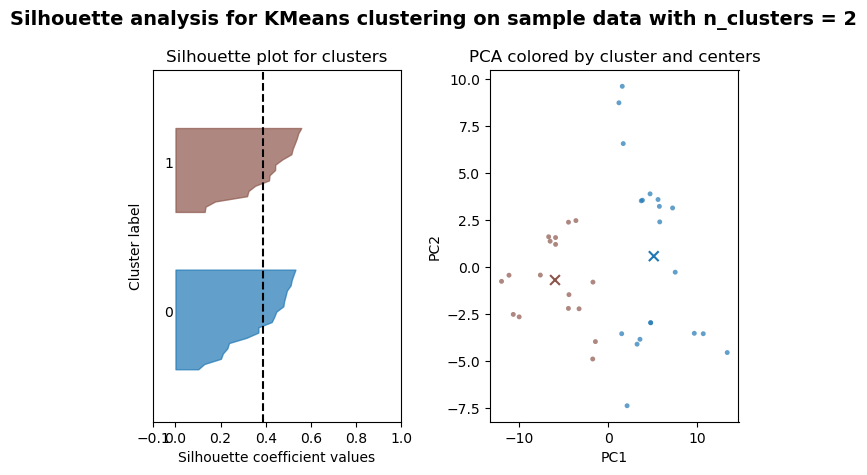

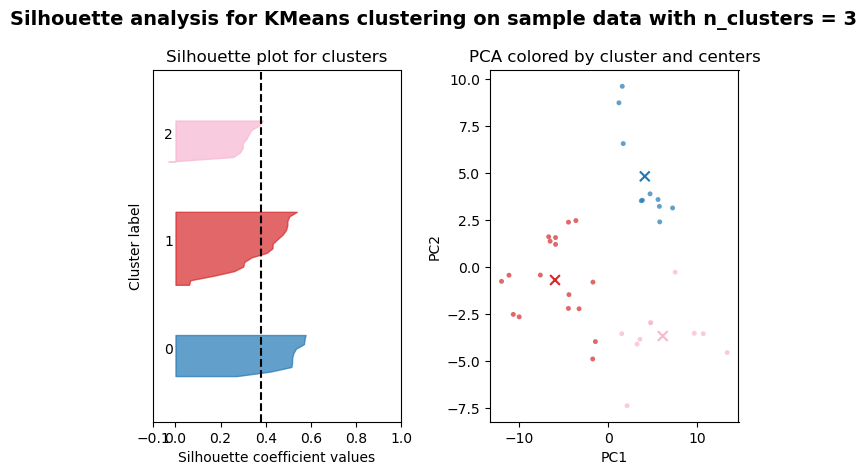

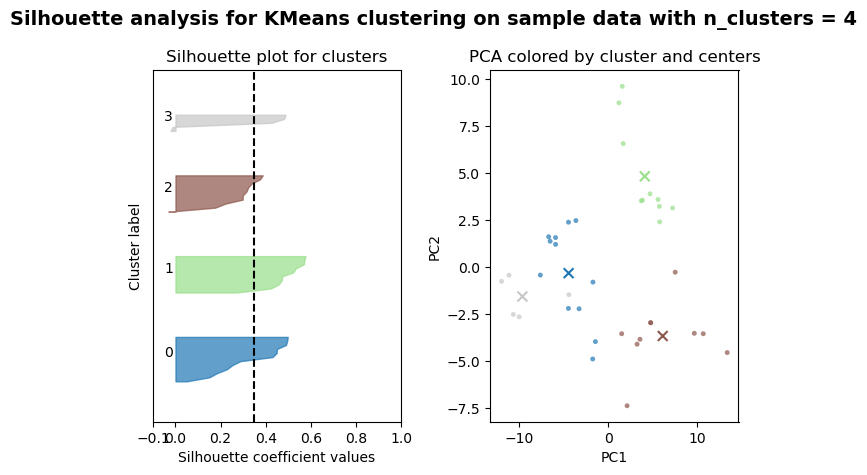

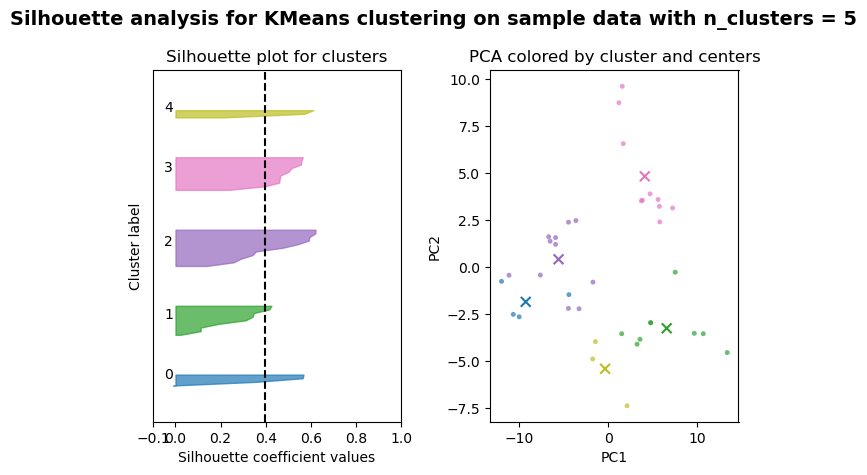

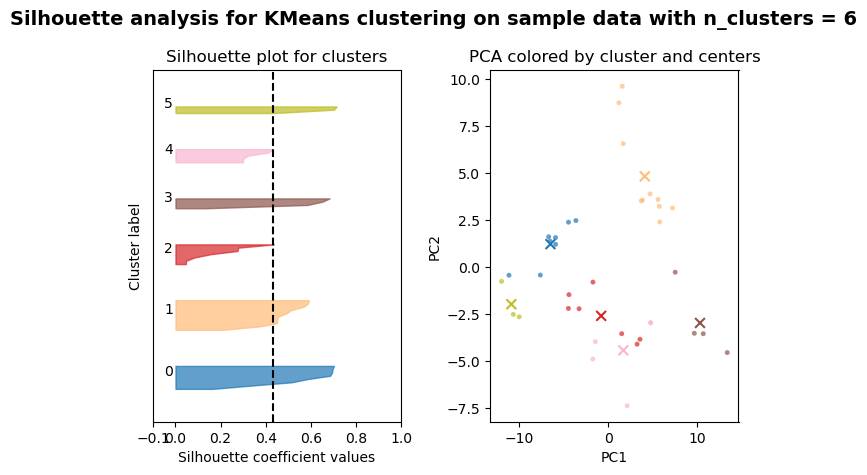

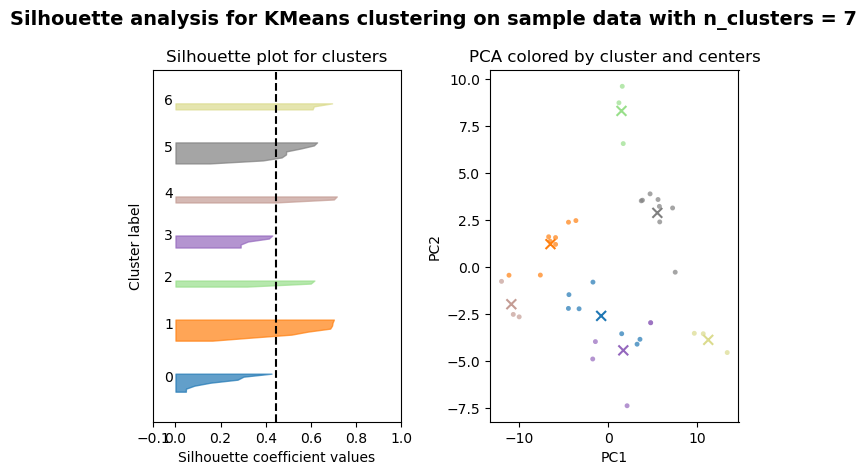

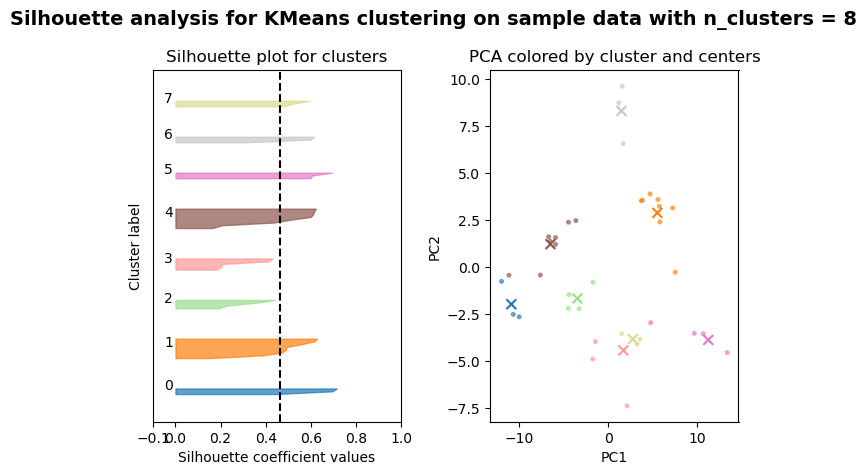

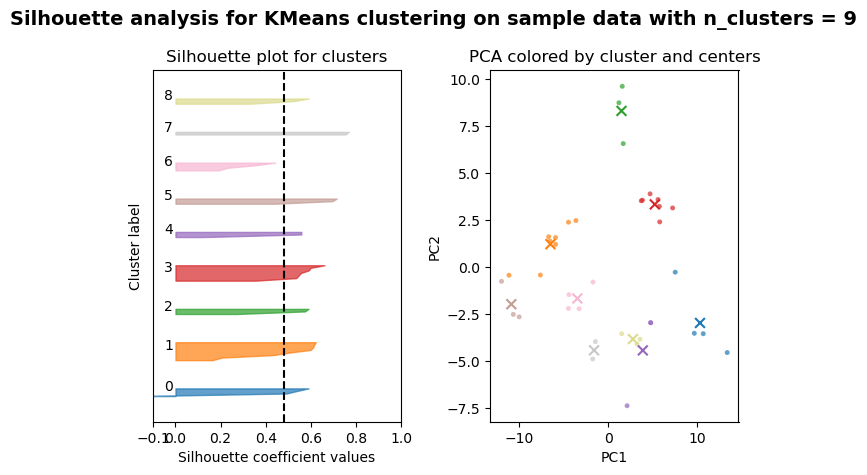

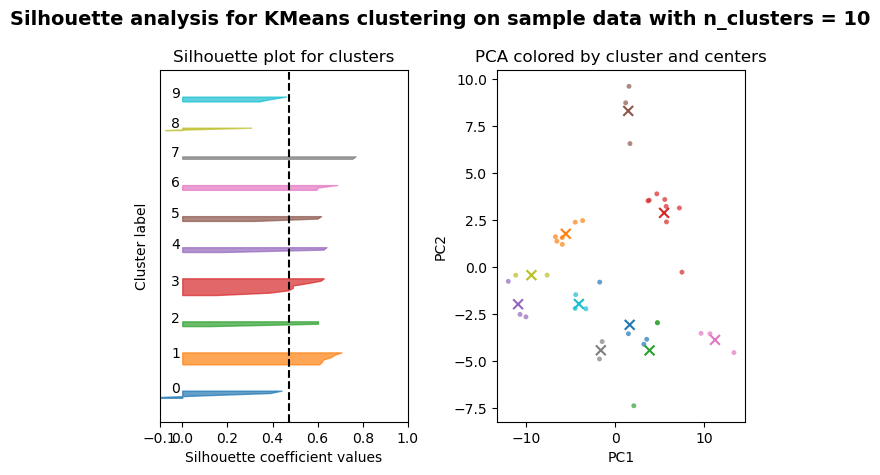

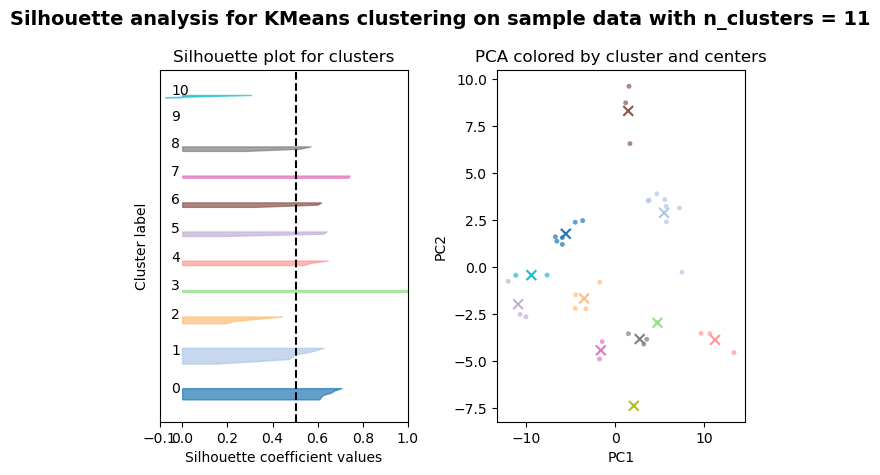

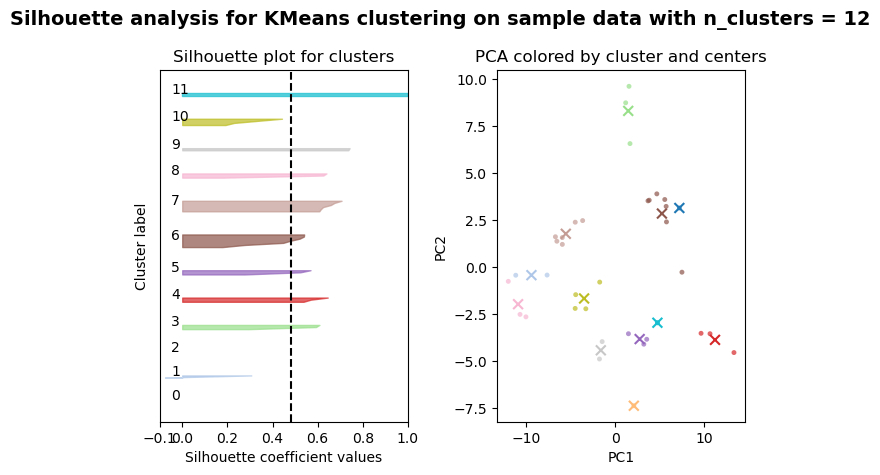

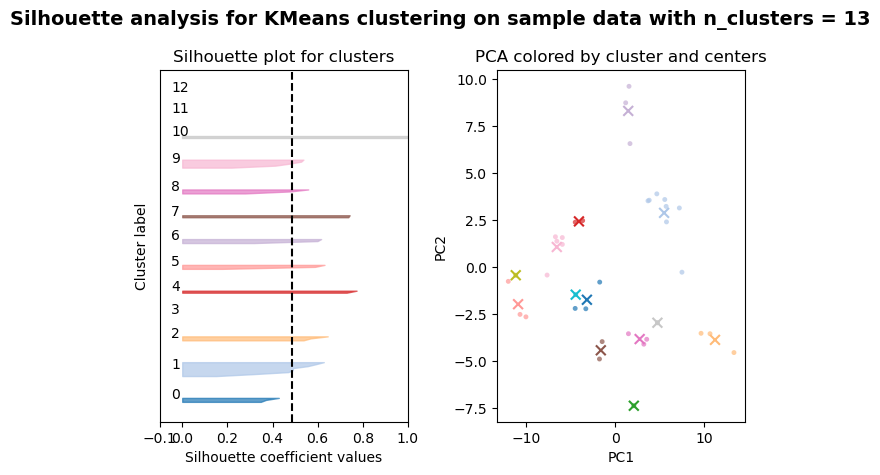

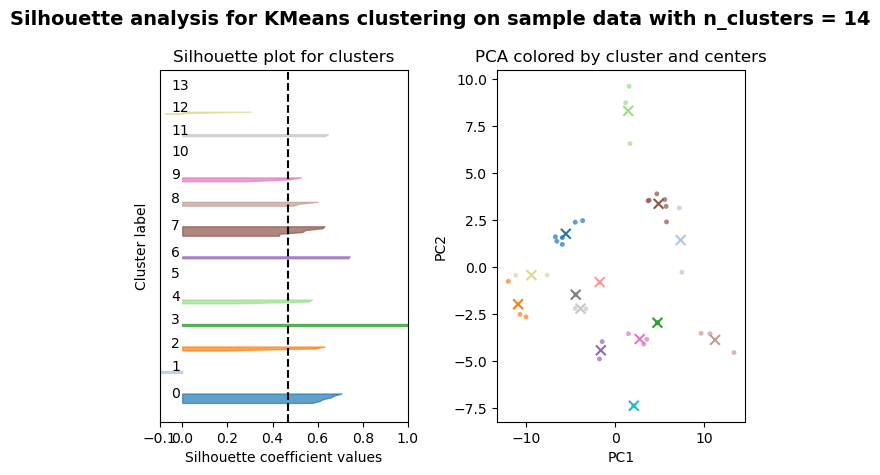

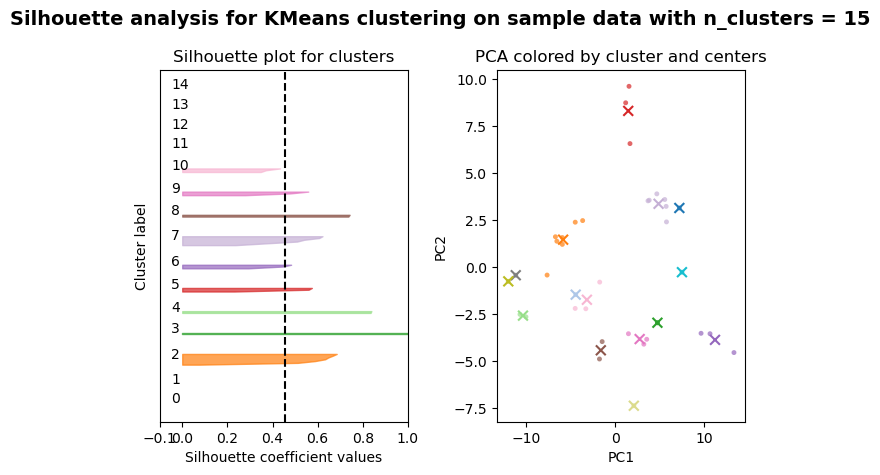

In [ ]:
# Inspired by sklearn docs
def silouhette_plot(X, min_clusters, max_clusters):
    range_n_clusters = list(range(min_clusters, max_clusters+1))
    # label_colors = [plt.cm.tab20(i) for i in range_n_clusters]
    
    for n_clusters in range_n_clusters:
        # Set fig params
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        
        # KMeans + silouhette avg
        km = KMeans(n_clusters=n_clusters, n_init=10).fit(X)
        silhouette_avg = silhouette_score(X, km.labels_)
        print(f"For k = {n_clusters}, silouhette avg = {silhouette_avg}")
        
        # Silouhette scores for each samples
        sample_silouhette_vals = silhouette_samples(X, km.labels_)
        y_lower = 10
        
        for i in range(n_clusters):
            # Sort sil scores per sample
            ith_cluster_silhouette_values = sample_silouhette_vals[km.labels_ == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            label_color = plt.cm.tab20(i / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=label_color,
                edgecolor=label_color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette plot for clusters")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="black", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot PCA
        pca = PCA(n_components=2).fit(X)
        data2d = pca.transform(X)
        cluster_colors = plt.cm.tab20(km.labels_.astype(float) / n_clusters)
        ax2.scatter(
            data2d[:,0], data2d[:,1], marker=".", s=50, lw=0, c=cluster_colors, alpha=0.7, edgecolor="k"
        )
        
        # Labeling the clusters
        centers2d = pca.transform(km.cluster_centers_)
        centers_colors = plt.cm.tab20(np.unique(km.labels_.astype(float) / n_clusters))
        ax2.scatter(centers2d[:, 0], centers2d[:, 1], marker="x", c=centers_colors, s=50)

        ax2.set_title("PCA colored by cluster and centers")
        ax2.set_xlabel("PC1")
        ax2.set_ylabel("PC2")

        plt.suptitle(
            f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
            fontsize=14,
            fontweight="bold",
        )
        fig.tight_layout()

    plt.show()
    
silouhette_plot(X_scaled, 2, 15)

With 8PCs-reduced data

For k = 2, silouhette avg = 0.391926362480854
For k = 3, silouhette avg = 0.39235620066652926
For k = 4, silouhette avg = 0.35688544469053024
For k = 5, silouhette avg = 0.4070884167612492
For k = 6, silouhette avg = 0.43812710005580446
For k = 7, silouhette avg = 0.44758239647762177
For k = 8, silouhette avg = 0.4668555767115038
For k = 9, silouhette avg = 0.5099277329796472
For k = 10, silouhette avg = 0.5205113139477354


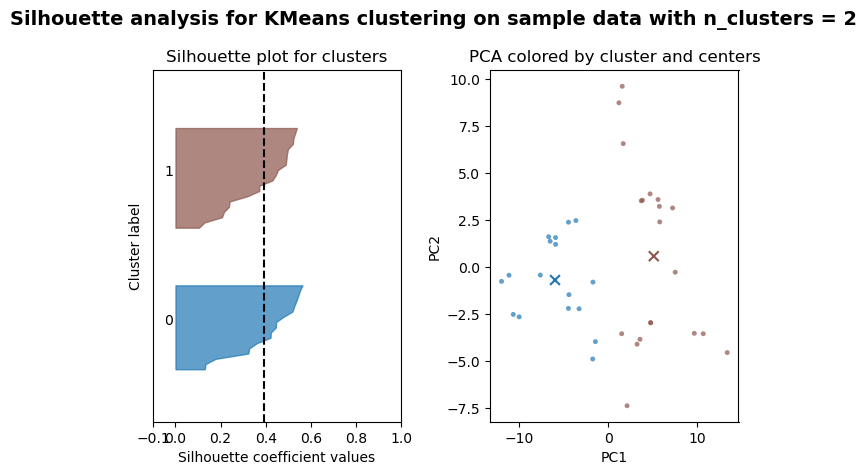

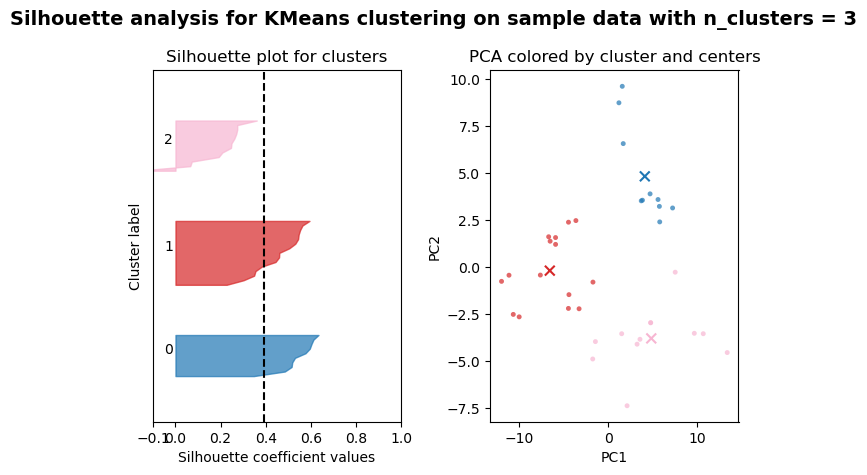

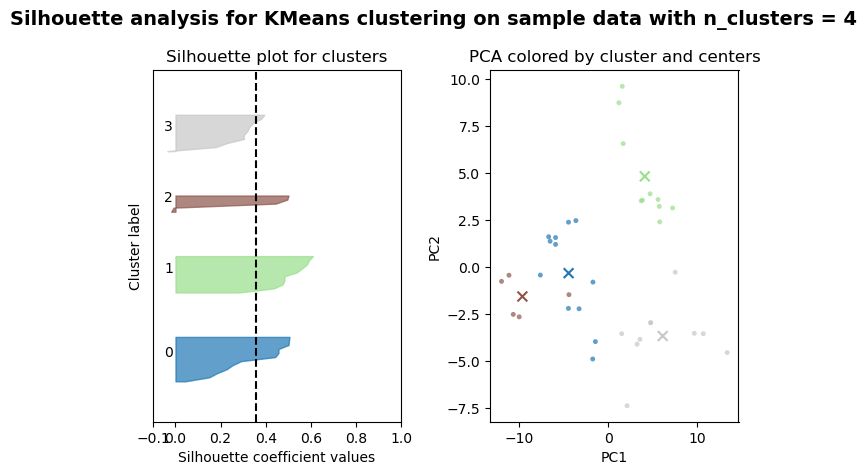

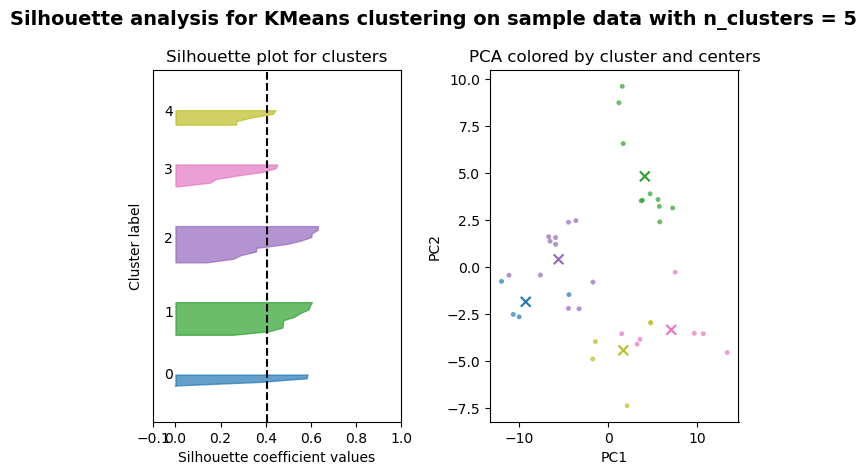

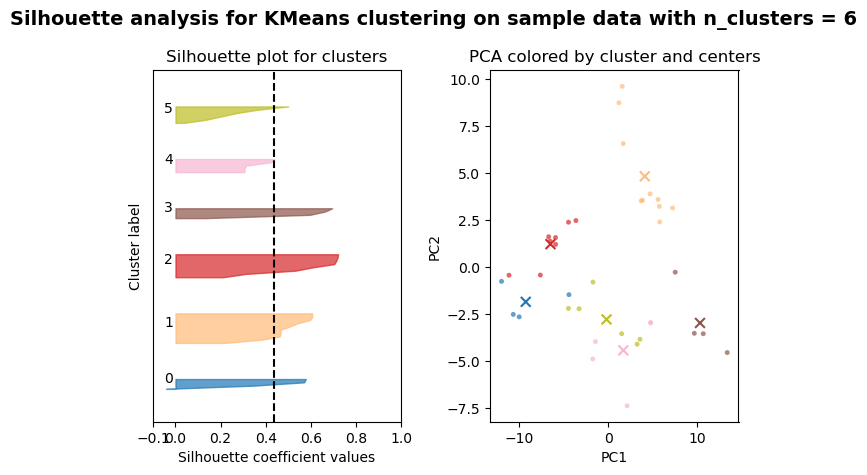

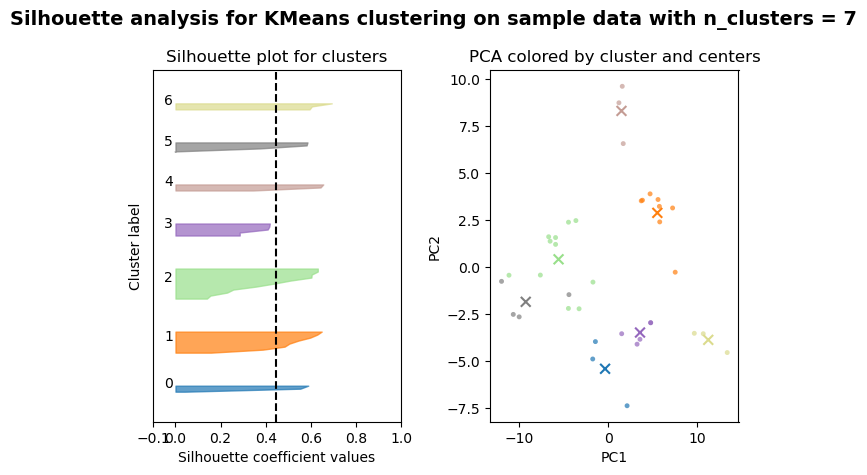

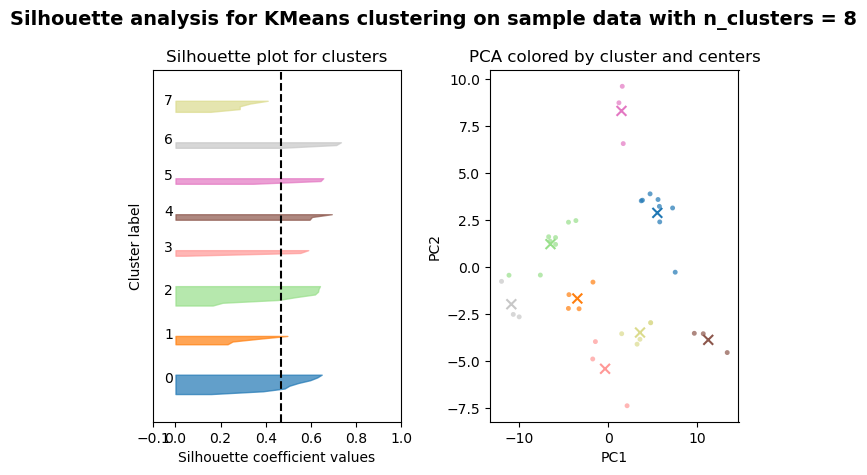

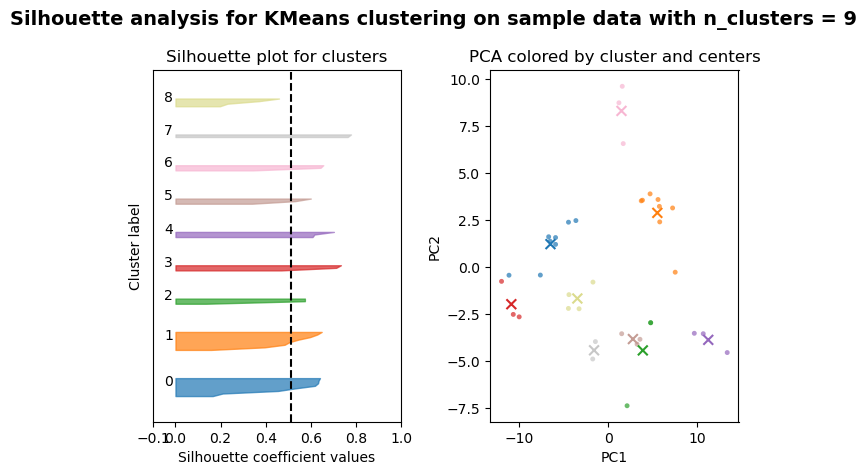

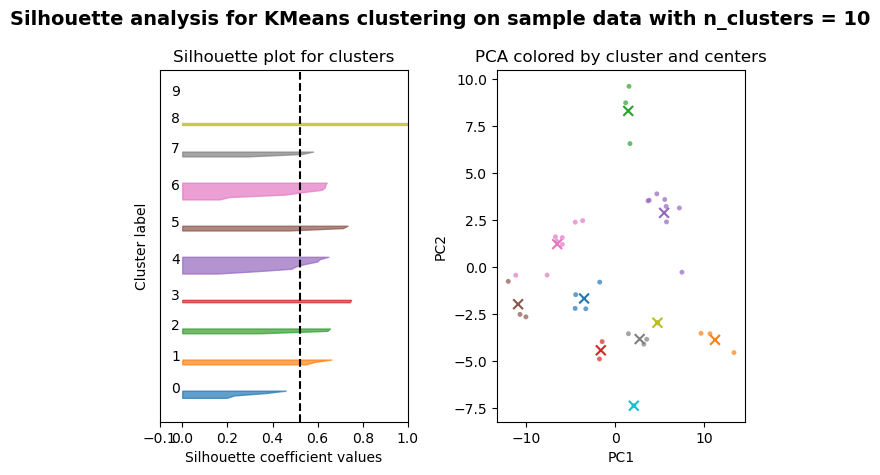

In [ ]:
silouhette_plot(X_pca, 2, 10)

Picking 5 to 8 clusters based on Silhouette score and PCA cluster overlap with 8PCs-reduced data

In [ ]:
# Fitting the model for 5 to 8 PCs
km_pca = KMeans(n_clusters=5, n_init=10).fit(X_pca)


In [ ]:
gdf_gbs["cluster"] = km_pca.labels_

In [ ]:
list(set(km_pca.labels_))

[0, 1, 2, 3, 4]

In [ ]:
# Wrap the kmeans clustering + map plotting together
def kmeans_map_plot(X, min_k, max_k, layer_num, gdf):
    if min_k > max_k:
        raise ValueError("min_k must be smaller than max_k")
    if min_k == 0:
        raise ValueError("Provide a K greater than 0")
    
    # Setup subplots with 2 cols always
    if min_k % 2 != 0 and max_k % 2 != 0:
        nrows = int((max_k - min_k) / 2 + 1)
    elif min_k % 2 == 0 and max_k % 2 == 0:
        nrows = int((max_k - min_k) / 2 + 1)
    else : 
        nrows = int((max_k - min_k + 1) / 2)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(5*nrows, 15))
    axes = axes.ravel()
    layer = mada_layers[f"layer{layer_num}"]
    
    # Open raster and fit kmeans for each k
    with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_mada:
        for i, k in enumerate(range(min_k, max_k+1)):
            # Fit the model and get clusters
            km = KMeans(n_clusters=k, n_init=10).fit(X)
                            
            axes[i] = rasterio.plot.show(
                    raster_mada.read(layer_num, masked=True),
                    transform=raster_mada.transform,
                    alpha=0.5,
                    cmap="Greys", 
                    ax=axes[i], 
                    title=f"layer{layer_num} : {layer} \nand K-Means with k={k} clusters",
                )
            # cax = plt.axes([0.85, 0.1, 0.075, 0.8])  #! DEPRECATED OPTIOSN
            # norm = colors.Normalize(vmin=gdf_gbs["cluster"].min(), vmax=gdf_gbs["cluster"].max())
            # cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
            # cbar = fig.colorbar(cb, cax=cax)
            # cbar.ax.set_yticklabels(gdf_gbs["cluster"].unique())
            
            # Get qualititavte color map according to k
            cmap = colors.ListedColormap(
                    plt.cm.get_cmap("Set1").colors[:k]
                    )

            # Get labels from each km-iteration 
            gdf["cluster"] = km.labels_
            
            gdf.plot(
                ax=axes[i], 
                column="cluster",
                c=km.labels_,
                cmap=cmap,
                markersize=15, 
                legend=True, 
                legend_kwds={
                    "spacing" : "uniform", 
                    # "cax" : cax, #! DEPRECATED ALT COLORBAR
                    "ticklocation" : "left",
                    "ticks" : range(k), #* KCLUST
                    "extend" : "both",
                }
                
            )
    fig.tight_layout()
    
    # Reset cluster labels
    gdf = gdf.drop(columns=["cluster"])
    
    # return gdf
            

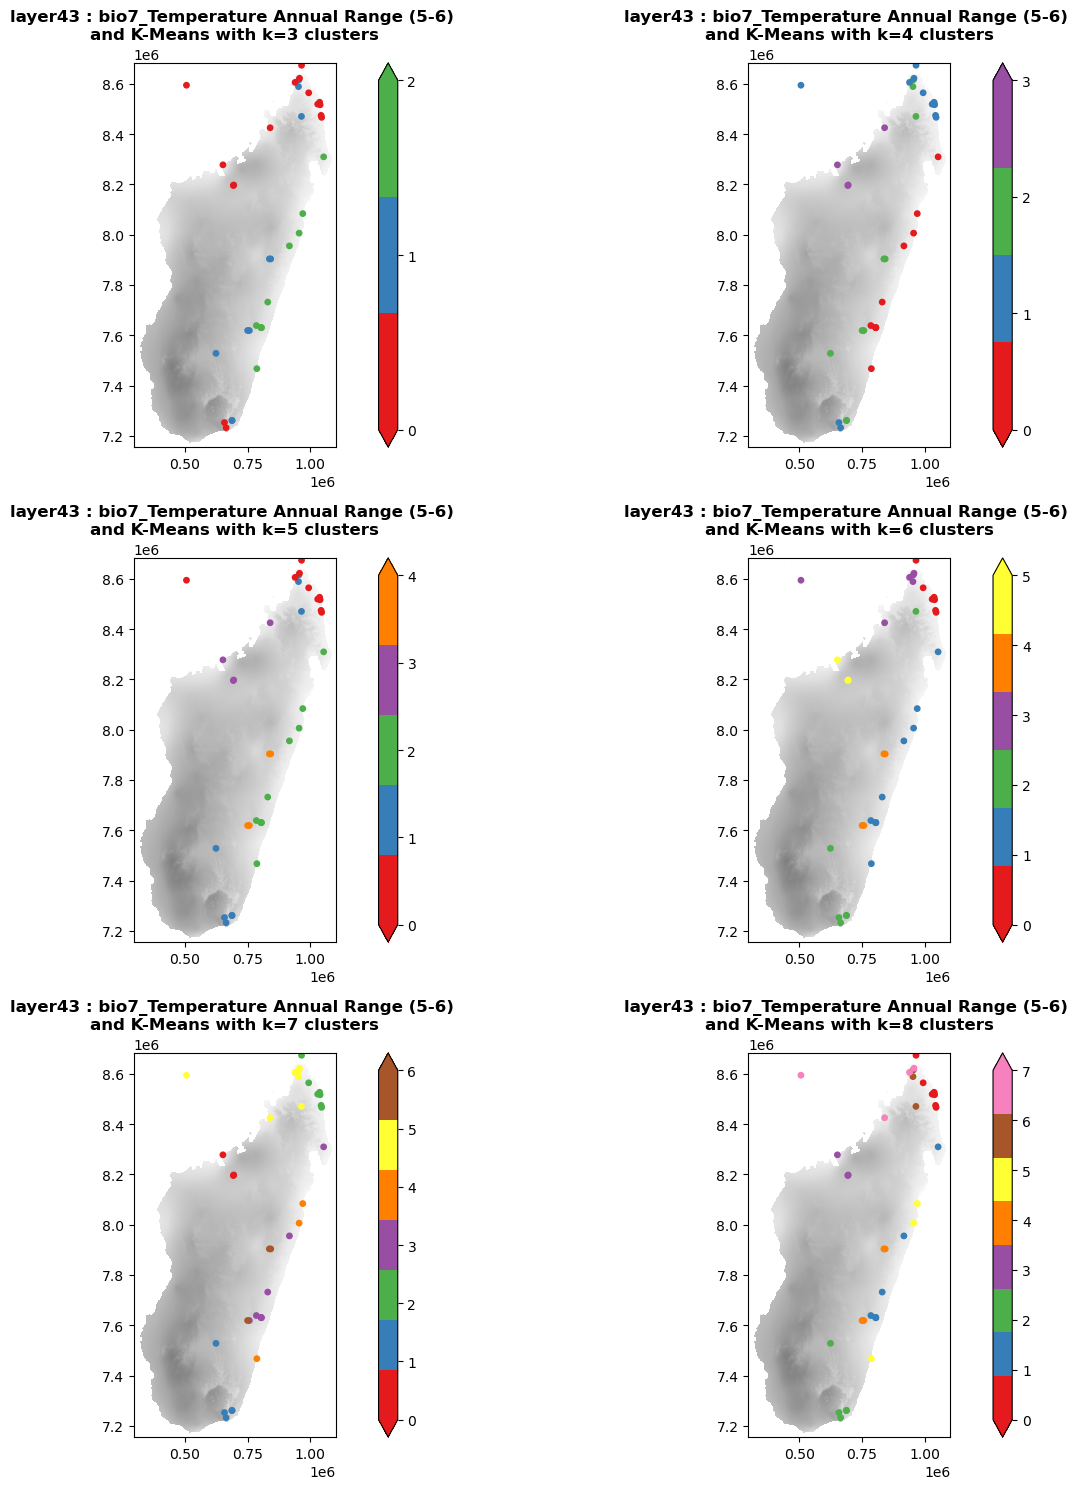

In [ ]:
# Scaled data
kmeans_map_plot(X_scaled, 3, 8, 43, gdf_gbs)

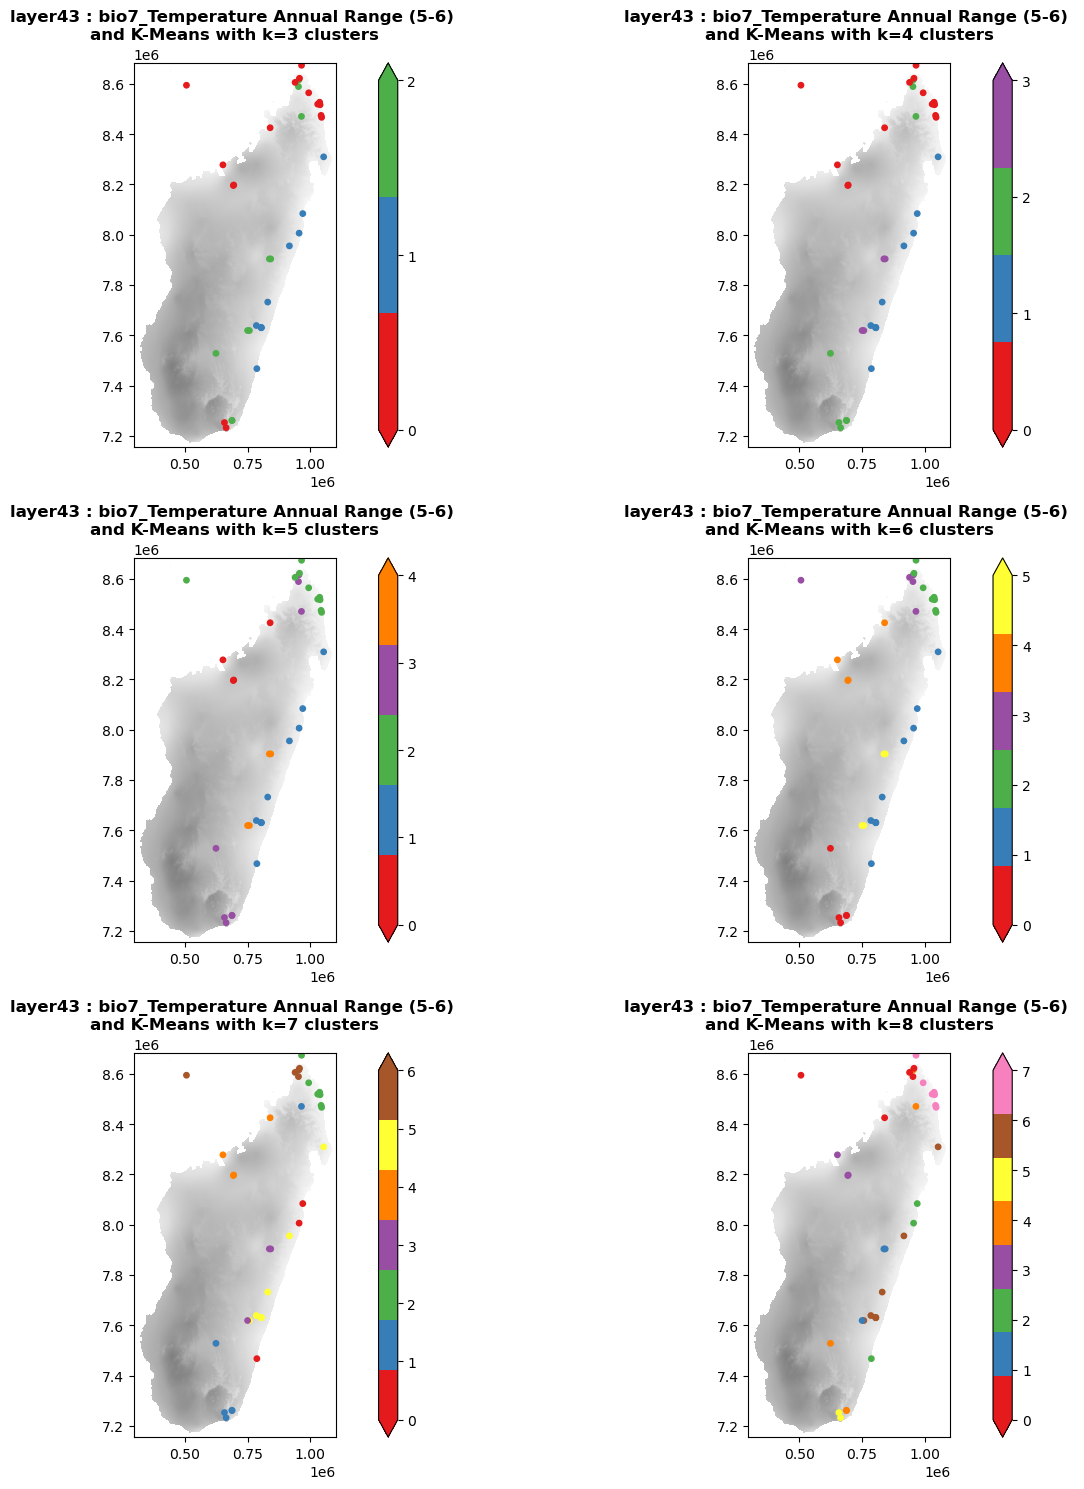

In [ ]:
kmeans_map_plot(X_pca, 3, 8, 43, gdf_gbs)

In [ ]:
# To validate on the previous map the colors of the clusters
gdf_gbs[["geometry","cluster", "Latitude"]].sort_values(by="Latitude").head(10)

geometry  cluster  Latitude
Species code                                                   
BERT          POINT (664808.037 7232213.963)        5 -25.01666
PER1          POINT (658169.137 7252603.015)        5 -24.83330
ABA           POINT (688328.240 7260998.023)        4 -24.75410
KIA2          POINT (688338.355 7260997.885)        4 -24.75410
FAR           POINT (787281.628 7467033.374)        2 -22.88000
SAK           POINT (624595.051 7527931.783)        4 -22.35000
MIL2          POINT (750334.648 7618740.006)        1 -21.51660
LAN           POINT (757247.218 7618631.529)        6 -21.51660
MON           POINT (805036.157 7629647.965)        6 -21.40970
AND2          POINT (805033.840 7630631.025)        6 -21.40083